Задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. 

В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды. Результаты предсказания по метрике RMSE не должны превышать **4 500**.

**Алгоритм решения задачи:**

- Загрузка исходных данных из файла;
- Разведывательный анализ данных;
- Подготовка данных к построению модели;
- Построение простой модели нейронной сети — baseline;
- Улучшение сети;
- Построение модели градиентного бустинга;
- Выводы по проекту.

**Характеристики звезд:**

- Относительная светимость L/Lo — светимость звезды относительно Солнца;
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды;
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды;
- Тип звезды.

<div style="border:solid Red 2px; padding: 40px">
<b>Выводы по проекту:</b>  

Для обсерватории "Небо на ладони" подготовлены 2 нейронной сети и модель градиентного бустинга для предсказывания температуру звезды на основе их характеристик с точностью **не хуже 5 000**. 

Проведен разведывательный анализ данных для каждого класса звезд. Выявлены закономерности для каждого из классов. В признак цвета звезды внесена корректировка исходя из названия. При этом, отмечено несоответствие цвета интервалам распределения температур. Данный факт ухудшил результат предсказаний моделей.

Исходные данные были подготовлены и разбиты на тренировочную и тестовую выборки. Тип данных изменен для корректного использования нейронными сетями и бустингом.

**Базовая модель нейронной сети** предсказывает температуру звезды с ошибкой RMSE около **4 550 К**. Модель включает в себя 3 скрытых слоев с различным количеством нейронов в каждом слое. В качестве функций активации выбрана ReLU, оптимизатор Adam со скоростью обучения 0.01. 

**Улучшенная модель нейронной сети** предсказывает температуру звезды с ошибкой RMSE около **4 480 К**. Модель включает в себя 2 скрытых слоев с различным количеством нейронов в каждом слое, регуляризацию BatchNorm и Dropuout. В качестве функций активации выбрана ReLU, оптимизатор Adam со скоростью обучения 0.0095. Подобраны оптимальные параметры модели и архитектура с помощью библиотеки Optuna.

**Модель градиентного бустинга XGBoost** предсказывает температуру звезды с ошибкой RMSE около **5 000 К**. Для модели подобраны оптимальные гиперпараметры на 100 попытках библиотекой Optuna.

Результаты всех моделей демонстрируют примерно одинаковые значени целевой метрики. Наибольшие отклонения в предсказаниях у моделей наблюдаются для звезд с номерами 177 и 227. При анализе их типов было выявлено, что параметры этих звезд не отличаются от средних значений в пределах соответсвующих классов.

Единый результат предсказания различных моделей свидетельствует о качественном разведывательном анализе данных, корректном обнаружении выбросов. Синтетические признаки также сыграли ключевую роль в улучшении точности предсказаний моделей.

## Загрузка данных

In [1]:
# Основные библиотеки
import pandas as pd
import numpy as np
from math import ceil
import datetime as dt

# Библиотеки для визуализации
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Библиотека для построения корреляции
import phik

# Библиотека для нейронной сети
import torch
import torch.nn as nn

# Библиотеки подготовки данных и расчета целевой метрики
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import (mean_squared_error, 
                             make_scorer)
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Библиотека для градиентного бустинга
from xgboost import XGBRegressor

# Библиотека для улучшения моделей
import optuna
from optuna.samplers import TPESampler

# Исходные константы
L0 = 3.828e26
R0 = 6.9551e8

Загружаем данные из локального датасета.

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv',index_col=0)

Проверяем информацию о признаках планет.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


Имеем данные о 240 звездах. В данных отсутствуют пропуски. Среди признаков имеются температура, светимость относительно солнца, радиус относительно солнца, абсолютная звездная величина, цвет звезды и ее тип. Выведем случайные 10 звезд.

In [4]:
data.sample(10)

Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
135             3243           0.00230        0.7300                   14.75   
95             11250         672.00000        6.9800                   -2.30   
34              5800           0.81000        0.9000                    5.05   
53              3749      550000.00000     1648.0000                   -8.05   
167            26373      198000.00000       39.0000                   -5.83   
122             3218           0.00054        0.1100                   20.02   
151             8945          38.00000        2.4870                    0.12   
138             3324           0.00340        0.3400                   12.23   
203            13340           0.00109        0.0116                   12.90   
37              6380           1.35000        0.9800                    2.93   

     Star type    Star color  
135          1           Red  
95           3    Blue-white  
34           3  yellow-white  
53           5        Orange  
167          4          Blue  
122          0           Red  
151          3    Blue-White  
138          1           Red  
203          2          Blue  
37           3  yellow-white

Проведем проверку на явные дубликаты.

In [5]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют. 

Для удобства сменим названия столбцов. Относительным величинам добавим приставку relative, так как в последстивии при создании синтетических признаков добавим абсолютные значения. Для исследования данных в целом можно использовать и относительные величины, порядок числе роли не играет, главное распределение.

In [6]:
data.columns = ['temperature', 'luminosity_relative', 'radius_relative', 'abs_magnitude', 'type', 'color']

Построим описательную статистику датасета.

In [7]:
data.describe()

temperature  luminosity_relative  radius_relative  abs_magnitude  \
count    240.000000           240.000000       240.000000     240.000000   
mean   10497.462500        107188.361635       237.157781       4.382396   
std     9552.425037        179432.244940       517.155763      10.532512   
min     1939.000000             0.000080         0.008400     -11.920000   
25%     3344.250000             0.000865         0.102750      -6.232500   
50%     5776.000000             0.070500         0.762500       8.313000   
75%    15055.500000        198050.000000        42.750000      13.697500   
max    40000.000000        849420.000000      1948.500000      20.060000   

             type  
count  240.000000  
mean     2.500000  
std      1.711394  
min      0.000000  
25%      1.000000  
50%      2.500000  
75%      4.000000  
max      5.000000

**Краткий вывод:** датасет содержит 240 звезд, пропуски среди признаков отсутствуют. 

**Температура звезд** Изменяется в диапазоне от 1 939 до 40 000 К. Среднее значение около 10 500, стандартное отклонение 9 500 градусов. Медиана - 5 776 К, что в 2 раза ниже среднего. Это указывает на смещение значений вправо.

**Относительная светимость** Минимальное значение 0.00008, максимальное 849 420 единиц. Среднее значение около 107 188, стандартное отклонение 179 432 единиц, медиана принимает значение 0.0705, сильно меньше среднего. Это значит, что больше половины звезд имеют светимость в 14 раз меньше солнца. При этом не менее 25% звезд в датасете в 200 000 раз больше. Данные очень сильно смещены вправо из-за больших значений. Но данная особенность это нормальное явление в космосе и коррекция значений невозможна.

**Отностительный радиус** повторяет распределение относительной светимости. минимальное значение 0.0084, медиана 0.7625 и максимальное значение 1948. При этом среднее значение 237, а стандартное отклонение 517. Данные сильно смещены вправо. Проверка максимального значение показала некую нестыковку с реальными данными, но порядок значений правильный. Самая большая звезда Stephenson 2-18 имеет радиус 2150 солнечных. Разница в данных примем за особенность измерений обсерватории.

**Абсолютная звездная величина** изменяется от -11.92 до 20.06 единиц. Среднее значение - 4.38, стандартное отклоенение - 10.53. Для сравнения, у солнца данный признак приблизительно 4.8, что близко к среднему значению датасета.

Последний числовой признак **тип звезды** является категориальным и не имеет описательного значения в данной статистике.

### Целевой признак температура звезды

Первую успешную попытку классифицировать звёзды предпринял в 1863 году итальянский астроном и священник Анджело Секки. Он заметил сильную корреляцию между видимыми цветами звёзд и линиями поглощения в их спектрах и на основании этого разделил звёзды на четыре спектральных класса, к которым позже добавился пятый. В дальнейшем, при составлении каталога Генри Дрейпера, астрономы Гарвардской обсерватории выделили большое количество спектров, названных латинскими буквами в порядке ослабевания в них линий водорода. Эта система с изменениями легла в основу системы классификации звёзд, используемой и поныне.

Основные спектральные классы звёзд в порядке уменьшения температуры — O, B, A, F, G, K, M. Изначально классы назывались в алфавитном порядке по ослабеванию в них линий водорода, но затем некоторые классы были объединены, а также была обнаружена их связь с температурой, поэтому в порядке убывания температуры последовательность стала выглядеть именно так. Каждый из классов делится на 10 подклассов от 0 до 9 в порядке уменьшения температуры, кроме O: первоначально он делился на подклассы от O5 до O9, но затем были введены подклассы вплоть до O2. Иногда используются полуцелые подклассы, как, например, B0,5. Более высокотемпературные классы и подклассы называются ранними, низкотемпературные — поздними. Звёзды распределены по классам крайне неравномерно: к классу M принадлежит примерно 73 % звёзд Млечного Пути, к классу K ещё около 15 %, в то время как звёзд класса O — 0,00002 %.

Кроме основных спектральных классов, существуют и дополнительные. Классы C (иногда делится на R и N) и S — низкотемпературные углеродные и циркониевые звёзды соответственно. Классы L, T, Y — классы коричневых карликов в порядке понижения температуры, идущие после класса M.

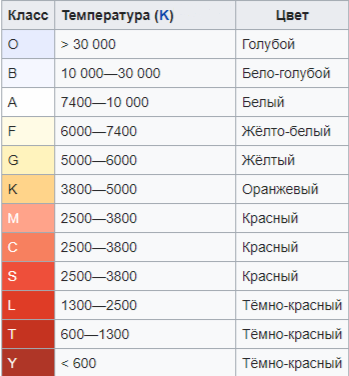

**Краткий вывод:** цвет и температура звезды имеют практически полную корреляцию. Эта информация будет полезна при проверки данных по цвету звезды.

Построим гистограмму распределения температуры.

In [8]:
fig = px.histogram(data, x='temperature', nbins=100, title='Гистограмма температуры звезд',
                   labels={'temperature': 'Значение температура'})
fig.update_layout(yaxis_title='Количество совпадений')
fig.update_traces(marker=dict(line=dict(color='black', width=1)))
fig.update_layout(width=1000, height=600)
fig.show()

Из рассмотреных статистик ранее нам известно, что температура звезд изменяется от 1 938 до 40 000 градусов Кельвина. При этом большое количество звезд имеют температуру менее 5 000 градусов. Построим диаграмму "ящик с усами".

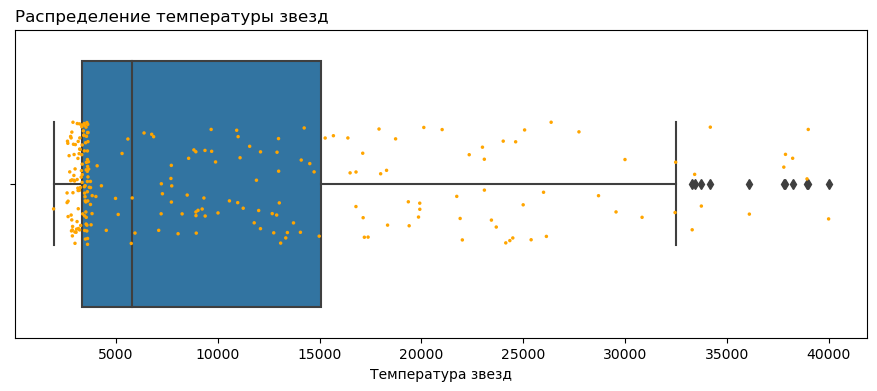

In [9]:
plt.figure(figsize = (11,4))
ax = sns.boxplot(x=data['temperature'])

# Наложим на график точки со значением температуры
ax = sns.stripplot(x=data['temperature'], color="orange", jitter=0.2, size=2.5)

# Добавим название диаграммы и оси Х
plt.title('Распределение температуры звезд', loc="left")
plt.xlabel('Температура звезд')
plt.show()

Средняя температура составляет около 2500 градусов, с разбросом в 1,5 квартильных размаха, который составляет 15 000 градусов. Значения, превышающие 32 000 градусов, могут рассматриваться как выбросы, но стоит отметить, что такие высокие температуры встречаются в реальности у горячих звезд. Исключение таких значений может отрицательно сказаться на точности прогнозирования характеристик этих звёзд.

С другой стороны, есть одно отклоняющееся значение с температурой 1938 градусов, которое значительно ниже остальных. Интересно, что в открытых источниках указано, что температуры звёзд обычно колеблются от 2 000 до 3 000 градусов. Это отличие подчеркивает необычность данного значения в контексте ожидаемых температур звёзд.

In [10]:
fig = px.scatter(data, x='temperature', y='type', 
                 labels={'temperature': 'Температура', 'type' : 'Тип звезды'})
fig.update_traces(marker=dict(color='Yellow', line=dict(width=1, color='Black')))
fig.update_layout(title_text='Зависимость между температурой и типом звезды', title_x=0.5)
fig.show()

**Краткий вывод:** для каждого типа классификации звезды преобладают собственные температуры.

Построим зависимость радиуса от типа звезды. Для построения графика используем логарифмированный абсолютный радиус, так как имеется различие в порядках между карликовыми звездами и гипергигантами.

In [11]:
fig = px.scatter(x=np.log(data['radius_relative']*R0), y=data['type'], 
                 labels={'x': 'Абсолютный радиус', 'y' : 'Тип звезды'})
fig.update_traces(marker=dict(color='Green', line=dict(width=1, color='Black')))
fig.update_layout(title_text='Зависимость между радиусом и типо звезды', title_x=0.5)
fig.show()

**Краткий вывод:** для каждого типа классификации звезды преобладают свойственные ей размеры. 

Последним построим график логарифмированной абсолютной яркости звезды.

In [12]:
fig = px.scatter(x=np.log(data['luminosity_relative']*L0), y=data['type'], 
                 labels={'x': 'Абсолютная светимость', 'y' : 'Тип звезды'})
fig.update_traces(marker=dict(color='Blue', line=dict(width=1, color='Black')))
fig.update_layout(title_text='Зависимость между радиусом и типо звезды', title_x=0.5)
fig.show()

Аналогично предыдущим графикам светимость зависит от типа звезды.

**Вывод:** последующее исследование данных стоит производить по каждому типу звезды в отдельности. У каждого типа свои основные характеристики и распределения.

### Коричневый карлик

Коричневые карлики — субзвёздные объекты, которые обладают промежуточными физическими характеристиками между планетами и звёздами. Их массы лежат в диапазоне приблизительно от 0,013 до 0,075 M⊙. Коричневые карлики могут поддерживать термоядерные реакции в своих недрах, но мощность реакций в них никогда не сравнивается с их собственной светимостью, поэтому такие объекты не выходят на постоянную светимость, как звёзды, а сжимаются и тускнеют.

Коричневые карлики имеют очень низкие светимости и температуры: светимости составляют менее 0,04 L⊙, а обычно — на порядки меньше. Температуры не превышают 2800 K, а у самых холодных коричневых карликов — около 300 K (для справки максимальная температура Земли 330 К). Радиусы коричневых карликов, вне зависимости от их масс, близки к радиусу Юпитера. В центральных областях некоторое время происходят термоядерные реакции: ядерное горение дейтерия может идти даже в самых маломассивных коричневых карликах, а более массивные способны поддерживать ядерное горение лития или даже ядерное горение водорода. Однако дейтерий и литий быстро исчерпываются, а горение водорода в коричневых карликах быстро прекращается, в отличие от звёзд.

Для начала разведочного анализа данных построим статистики для данного типа звезд.

In [13]:
def data_describe(type_star):
    return data[data['type']==type_star].describe()
    
data_describe(0)

temperature  luminosity_relative  radius_relative  abs_magnitude  type
count    40.000000            40.000000        40.000000      40.000000  40.0
mean   2997.950000             0.000693         0.110015      17.563500   0.0
std     332.276295             0.000888         0.025783       1.213111   0.0
min    1939.000000             0.000138         0.057000      16.050000   0.0
25%    2812.750000             0.000315         0.093150      16.700000   0.0
50%    2935.000000             0.000520         0.106000      17.145000   0.0
75%    3242.500000             0.000737         0.120250      18.352500   0.0
max    3531.000000             0.005600         0.190000      20.060000   0.0

Построим распределение относительной светимости для данного типа звезд.

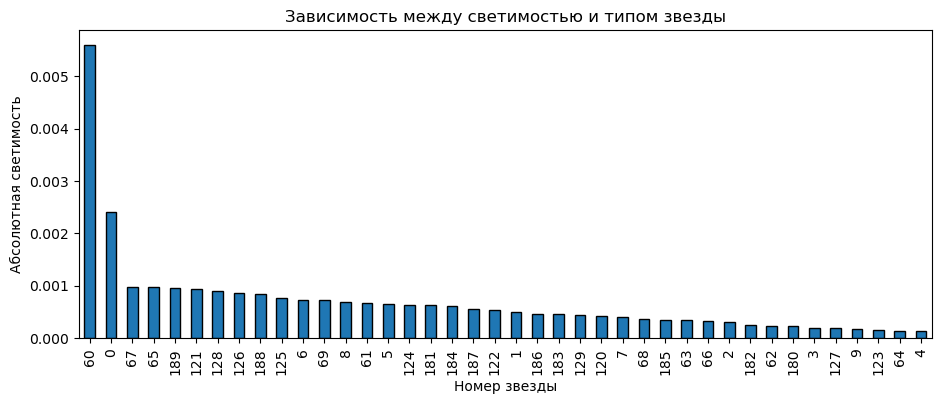

In [14]:
def bar_lum(type_star):
    plt.figure(figsize = (11,4))
    data[data['type']==type_star]['luminosity_relative'].sort_values(ascending=False).plot(kind='bar', edgecolor='black')
    plt.title('Зависимость между светимостью и типом звезды')
    plt.ylabel('Абсолютная светимость')
    plt.xlabel('Номер звезды')
    plt.show()
    
bar_lum(0)

Из графика видно, что звезды под номерами 60 и 0 сильно отличаются по светимости от своих собратьев. 

Построим график зависимости светимости от температуры.

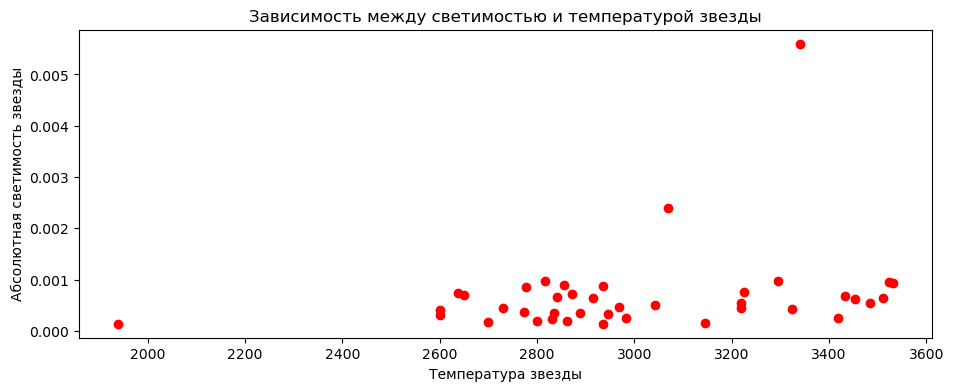

In [15]:
def plot_lum(type_star):
    plt.figure(figsize = (11,4))
    plt.plot(data[data['type']==type_star]['temperature'], 
             data[data['type']==type_star]['luminosity_relative'], 'ro')
    plt.title('Зависимость между светимостью и температурой звезды')
    plt.ylabel('Абсолютная светимость звезды')
    plt.xlabel('Температура звезды')
    plt.show()
    
plot_lum(0)

На данном графике явно видно, что 3 звезды сильно отличаются от выборки. В [википедии](https://ru.wikipedia.org/wiki/Коричневый_карлик#Общие_параметры) описано, что светимость коричневых карликов не превышает 0,04 светимости солнца. В связи с чем данные значения имеют место быть.

Следующим проверим отностильные радиусы звезд. Построим столбчатую диаграмму.

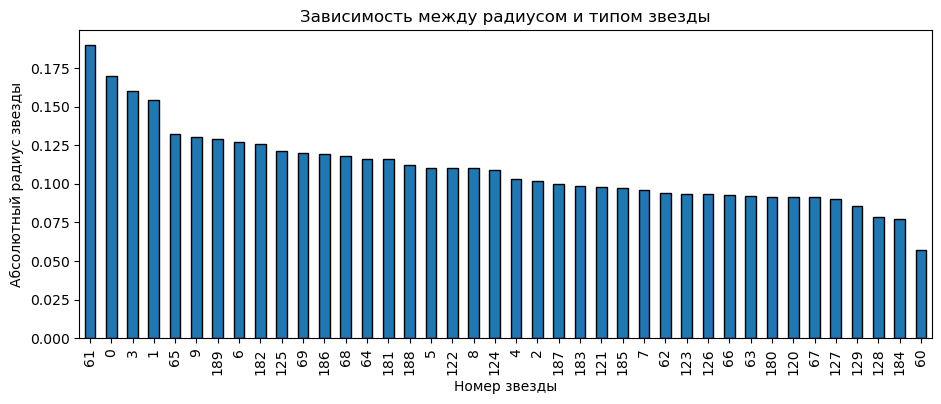

In [16]:
def bar_rad(type_star):
    plt.figure(figsize = (11,4))
    data[data['type']==type_star]['radius_relative'].sort_values(ascending=False).plot(kind='bar', edgecolor='black')
    plt.title('Зависимость между радиусом и типом звезды')
    plt.ylabel('Абсолютный радиус звезды')
    plt.xlabel('Номер звезды')
    plt.show()

bar_rad(0)

Относительные радиусы звузд имеют примерно один порядок, звезда под номером 60 немного меньше остальных.

Построим график зависимости радиуса от температуры.

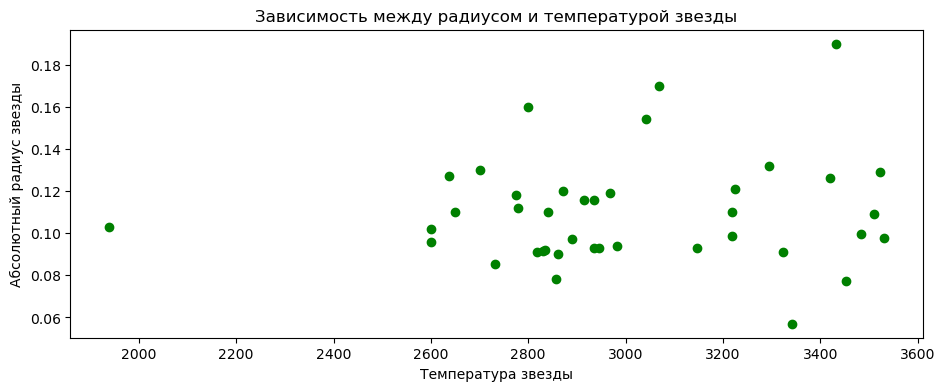

In [17]:
def plot_rad(type_star):
    plt.figure(figsize = (11,4))
    plt.plot(data[data['type']==type_star]['temperature'], 
             data[data['type']==type_star]['radius_relative'], 'go')
    plt.title('Зависимость между радиусом и температурой звезды')
    plt.ylabel('Абсолютный радиус звезды')
    plt.xlabel('Температура звезды')
    plt.show()
    
plot_rad(0)

Звезда, имеющая температуру ниже 2 000 хоть и выбивается из общей массы, но в целом имеет средний радиус по сравнению с остальными.

Построим графики абсолютной звездной величины.

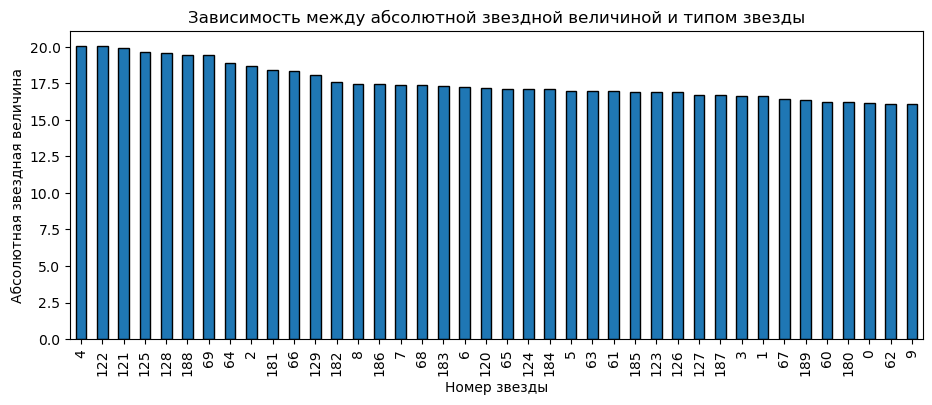

In [18]:
def bar_mag(type_star):
    plt.figure(figsize = (11,4))
    data[data['type']==type_star]['abs_magnitude'].sort_values(ascending=False).plot(kind='bar', edgecolor='black')
    plt.title('Зависимость между абсолютной звездной величиной и типом звезды')
    plt.ylabel('Абсолютная звездная величина')
    plt.xlabel('Номер звезды')
    plt.show()
    
bar_mag(0)

Построим график зависимости абсолютной звездной величины от температуры.

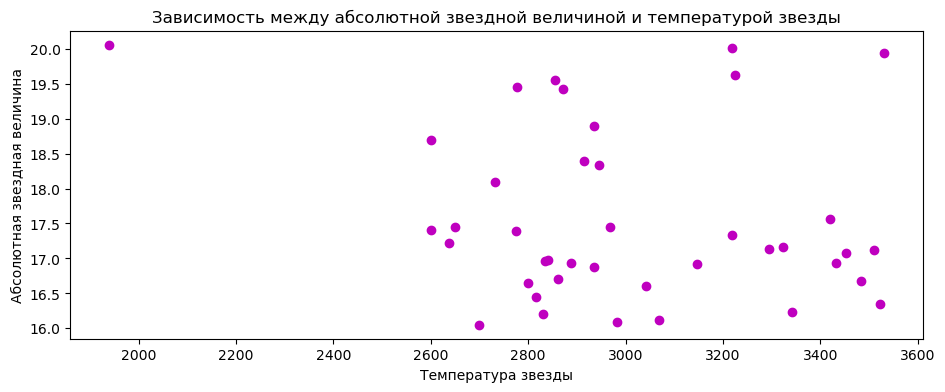

In [19]:
def plot_mag(type_star):
    plt.figure(figsize = (11,4))
    plt.plot(data[data['type']==type_star]['temperature'], 
             data[data['type']==type_star]['abs_magnitude'], 'mo')
    plt.title('Зависимость между абсолютной звездной величиной и температурой звезды')
    plt.ylabel('Абсолютная звездная величина')
    plt.xlabel('Температура звезды')
    plt.show()

plot_mag(0)

Из всех звезд данной группы, выделяется звезда с низкой температурой.

Проверим какие цвета звезд присутствуют в выборке.

In [20]:
data[data['type']==0]['color'].value_counts()

Red    40
Name: color, dtype: int64

Все звезды имеют красный цвет. 

В ходе разведывательного анализа данных установлена одна выбивающаяся звезда с температурой ниже 2 000 градусов. В связи с чем, принято решение замены температуры этой звезды на среднюю для класса. Остальные звезды не имеют линейной зависимости от температуры и готовы для обучения и предсказания нейронной сети.

In [21]:
data.loc[(data['type']==0)&(data['temperature']<2000), 'temperature'] = data[data['type']==0]['temperature'].mean()

D:\anaconda\lib\site-packages\phik\data_quality.py:82: UserWarning:

Not enough unique value for variable color for analysis 1. Dropping this column



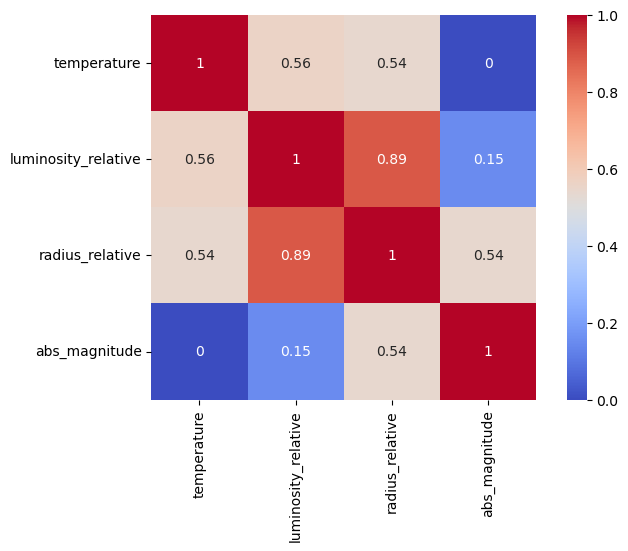

In [22]:
def corr_matrix(type_star):
    cor_columns = ['temperature', 'luminosity_relative', 'radius_relative','abs_magnitude', 'color']
    matrix = data[data['type']==type_star][cor_columns].phik_matrix(interval_cols=cor_columns[:-1])
    plt.figure(figsize = (8,5))
    sns.heatmap(matrix.round(2), cmap='coolwarm', annot=True, square=True)
    plt.show()
    
corr_matrix(0)

Из матрицы корреляции видно, что для коричневого карлика отсутствует корреляция между температурой и абсолютной звездной величиной. При этом между радиусом и светимостью имеется сильная корреляция. Так как значение температуры для этого типа представлено одни значением, то корреляцию по этому признаку построить невозможно.

С целевым признаком с значением более 50% коррелируют светимость и радиус.

### Красный карлик

Красные карлики довольно сильно отличаются от других звёзд. Масса красных карликов не превышает трети солнечной массы (нижний предел массы или предел Кумара — 0,0767 при обычном содержании тяжёлых элементов M☉, затем идут коричневые карлики). Температура фотосферы красного карлика может достигать 3500 К, что превышает температуру спирали лампы накаливания, поэтому, вопреки своему названию, красные карлики, аналогично лампам, испускают свет не красного, а скорее охристо-желтоватого оттенка. Звезды этого типа испускают очень мало света, иногда в 10 000 раз меньше чем Солнце. Из-за низкой скорости термоядерного сгорания водорода красные карлики имеют очень большую продолжительность жизни — от десятков миллиардов до десятков триллионов лет (красный карлик с массой в 0,1 массы Солнца будет гореть 10 триллионов лет). В недрах красных карликов невозможны термоядерные реакции с участием гелия, поэтому они не могут превратиться в красные гиганты. Со временем они постепенно сжимаются и всё больше нагреваются, пока не израсходуют весь запас водородного топлива, и постепенно превращаются в голубые карлики, а затем — в белые карлики с гелиевым ядром. Но с момента Большого взрыва прошло ещё недостаточно времени, чтобы красные карлики смогли сойти с главной последовательности.

Для начала разведочного анализа данных построим статистики для данного типа звезд.

In [23]:
data_describe(1)

temperature  luminosity_relative  radius_relative  abs_magnitude  type
count    40.000000            40.000000        40.000000      40.000000  40.0
mean   3283.825000             0.005406         0.348145      12.539975   1.0
std     269.637258             0.007330         0.154453       1.422816   0.0
min    2621.000000             0.000190         0.098000      10.120000   1.0
25%    3132.750000             0.001315         0.240000      11.367500   1.0
50%    3314.000000             0.003150         0.338000      12.605000   1.0
75%    3527.500000             0.006675         0.409750      13.564250   1.0
max    3692.000000             0.039000         0.730000      14.940000   1.0

Построим распределение относительной светимости для данного типа звезд.

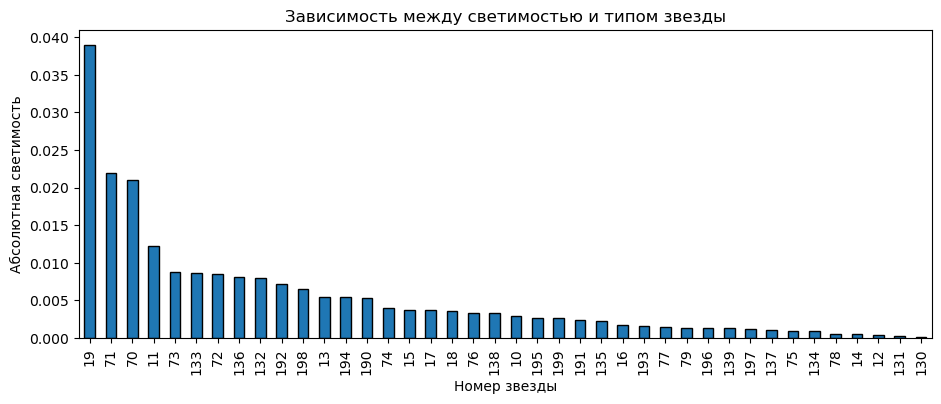

In [24]:
bar_lum(1)

Среди звезд типа красный карлик по светимости выделяются 3 звезды - 19, 71 и 70, светимость которых выше 0.02.

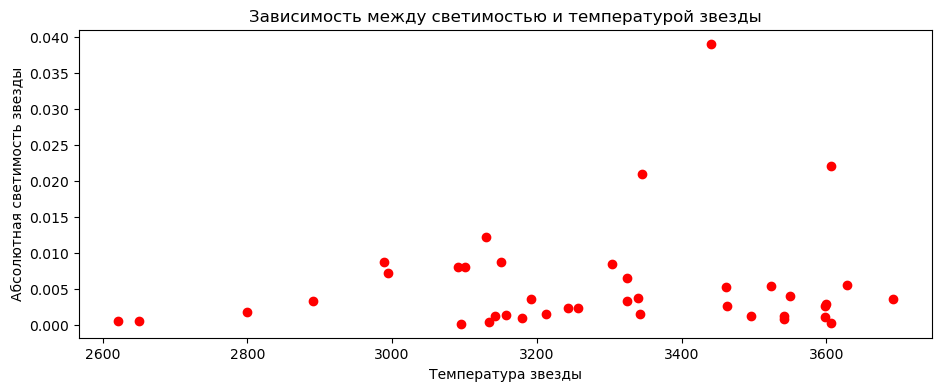

In [25]:
plot_lum(1)

На точечном графике наглядно видно отдаление этих звезд от общей массы. Такое различие физически допустимо для звезд этого типа. Так же заметна линейная зависимость между светимостью и температурой.

Построим столбчатую диаграмму распределения радиусов звезд и график зависимости радиуса и температуры.

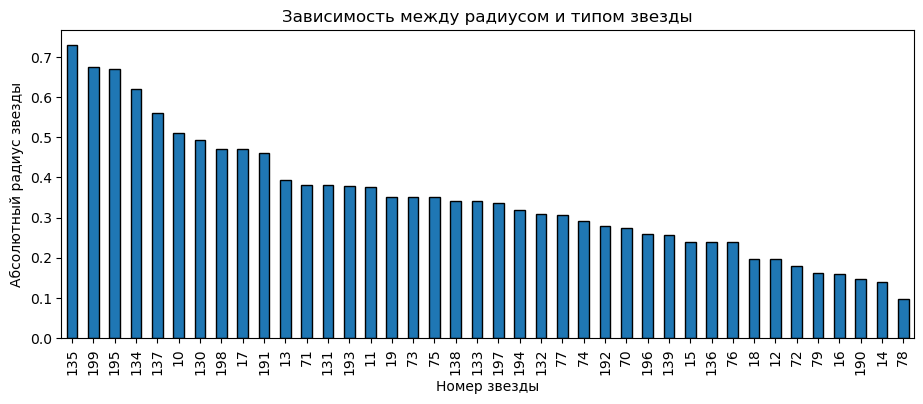

In [26]:
bar_rad(1)

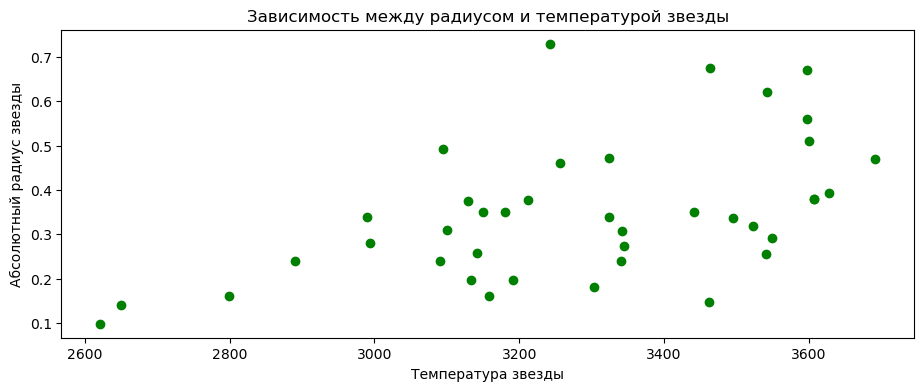

In [27]:
plot_rad(1)

На столчатом графике заметно равномерное распределение радиусов, без особых скачков. В графике зависимости радиуса и температуры наблюдается аналогичная некая зависимость, при увеличении температуры увеличивается и значение радиуса. Эту зависимость можно отследить на диаграмме Герцпрунга-Рассела. 

Построим график зависимости абсолютной звездной величины и температуры.

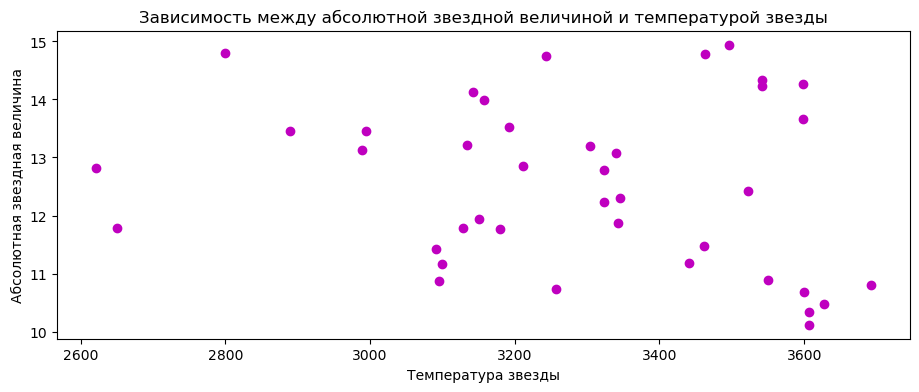

In [28]:
plot_mag(1)

Для данного параметра нет особой линейной зависимости. Выделяются только 2 звезды с температурой около 2 600 градусов.

Проверим какие цвета присуще красным карликам.

In [29]:
data[data['type']==1]['color'].value_counts()

Red    40
Name: color, dtype: int64

Как и следовало ожидать красные карлики имеют красный цвет. Данный класс не имеет выбрасов, светимость и радиус имеют зависимость от температуры звезды.

D:\anaconda\lib\site-packages\phik\data_quality.py:82: UserWarning:

Not enough unique value for variable color for analysis 1. Dropping this column



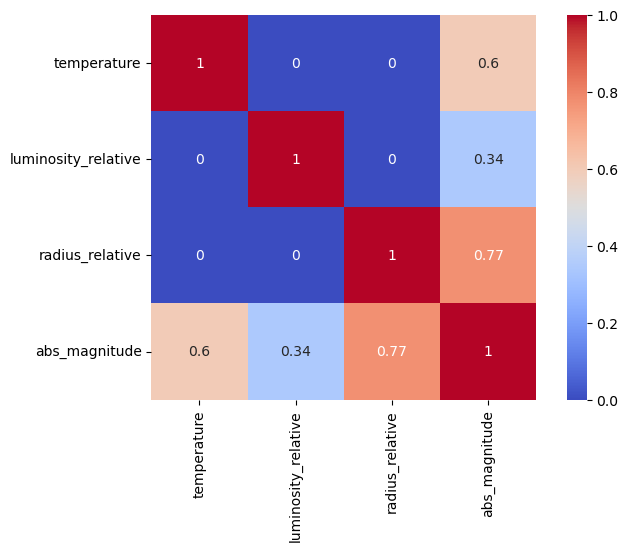

In [30]:
corr_matrix(1)

Для красного карлика имеется корреляция лишь между абсолютной звездной величиной и остальными признаками. При этом корреляция с температурой составляет 60%. Корреляция между абсолютной звездной величиной и радиусом составляет 77%, что достаточно высоко. Так как значение температуры для этого типа представлено одни значением, то корреляцию по этому признаку построить невозможно.

### Белый карлик

Белые карлики — звёзды, состоящие из электронно-ядерной плазмы, лишённые источников термоядерной энергии и светящиеся благодаря своей тепловой энергии, постепенно остывая в течение миллиардов лет.

Белые карлики образуются в процессе эволюции звёзд, чья масса недостаточна для превращения в нейтронную звезду, а именно не превышает около 10 масс Солнца, каковых в нашей галактике более 97 % от общего количества. Когда звезда главной последовательности малой или средней массы заканчивает превращение водорода в гелий, она расширяется, становясь красным гигантом. Красный гигант поддерживается термоядерными реакциями превращения гелия в углерод и кислород. Если масса красного гиганта оказывается недостаточной для подъёма температуры ядра до уровня, необходимого для термоядерных реакций с участием полученного углерода, происходит его накопление в ядре звезды, вместе с кислородом. Звезда сбрасывает внешнюю оболочку, формируя планетарную туманность, а бывшее ядро звезды становится белым карликом, состоящим из углерода и кислорода.

Сформировавшиеся белые карлики представляют собой компактные звёзды с массами, сравнимыми или большими, чем масса Солнца, но с радиусами в 100 раз меньшими и, соответственно, болометрическими светимостями в ~10 000 раз меньше солнечной.

Для начала разведочного анализа данных построим статистики для данного типа звезд.

In [31]:
data_describe(2)

temperature  luminosity_relative  radius_relative  abs_magnitude  type
count     40.000000            40.000000        40.000000      40.000000  40.0
mean   13931.450000             0.002434         0.010728      12.582500   2.0
std     4957.655189             0.008912         0.001725       1.278386   0.0
min     7100.000000             0.000080         0.008400      10.180000   2.0
25%     9488.750000             0.000287         0.009305      11.595000   2.0
50%    13380.000000             0.000760         0.010200      12.340000   2.0
75%    17380.000000             0.001227         0.012025      13.830000   2.0
max    25000.000000             0.056000         0.015000      14.870000   2.0

Построим столбчатую диаграмму и график зависимости светимости и температуры звезды.

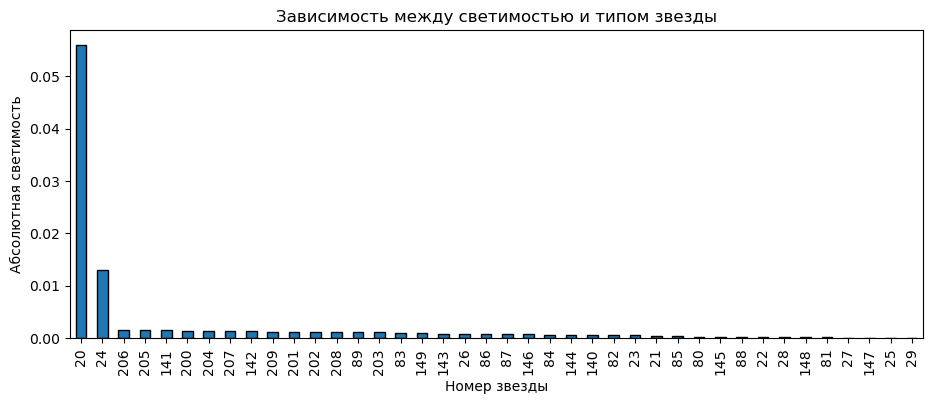

In [32]:
bar_lum(2)

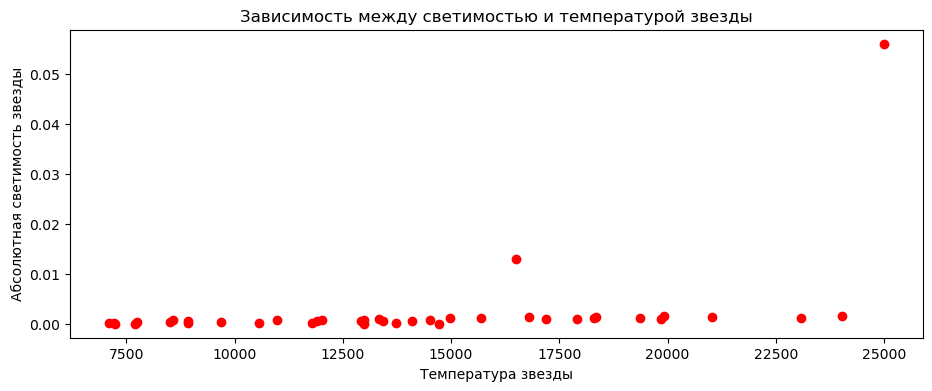

In [33]:
plot_lum(2)

На графиках явно видно выбросы 2 звезд под номерами 20 и 24. Их светимость в 10-50 раз больше остальных. Модель будет неверно предсказывать температуру таких звезд. Поэтому следует уменьшить откорректировать их светимость. Например поставив максимальное значение для данного типа.

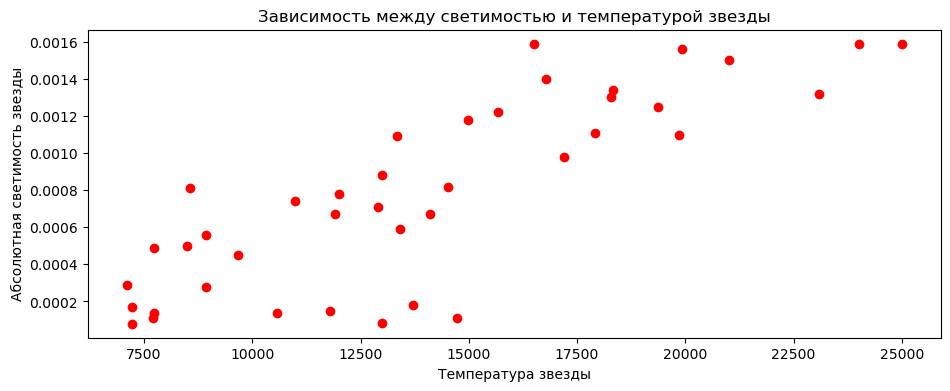

In [34]:
data.loc[[20, 24],'luminosity_relative'] = data.loc[206,'luminosity_relative']
plot_lum(2)

Теперь на графике имеется линейная зависимость между светимостью и температурой.

Построим аналогичные графики для радиуса звезд.

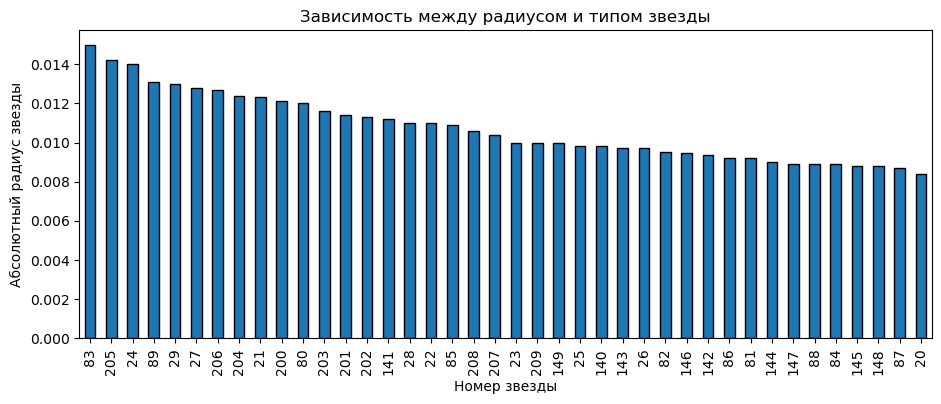

In [35]:
bar_rad(2)

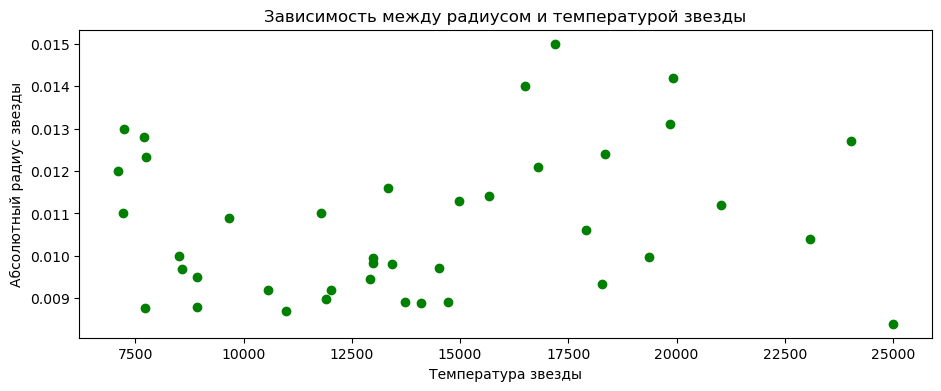

In [36]:
plot_rad(2)

За исключением нескольких звезд, наблюдается зависимость радиуса и температуры.

Построим график зависимости абсолютной звездной величины и температуры звезды.

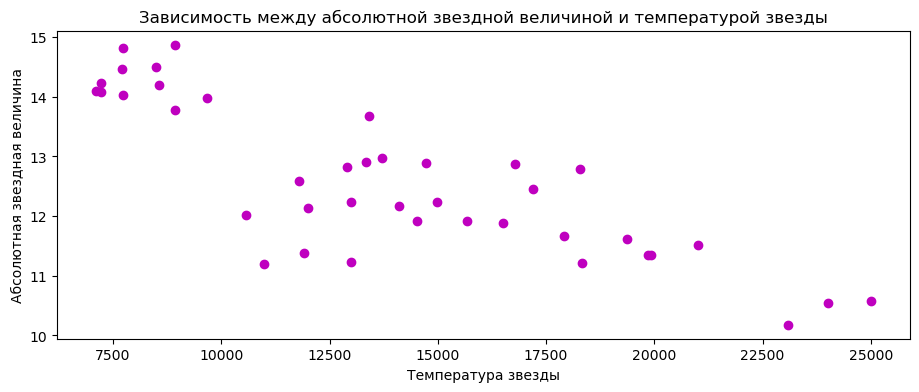

In [37]:
plot_mag(2)

На данном графике видна обратная зависимость, а так же деление звезд на 3 группы.

Последним признаком яляется цвет звезды.

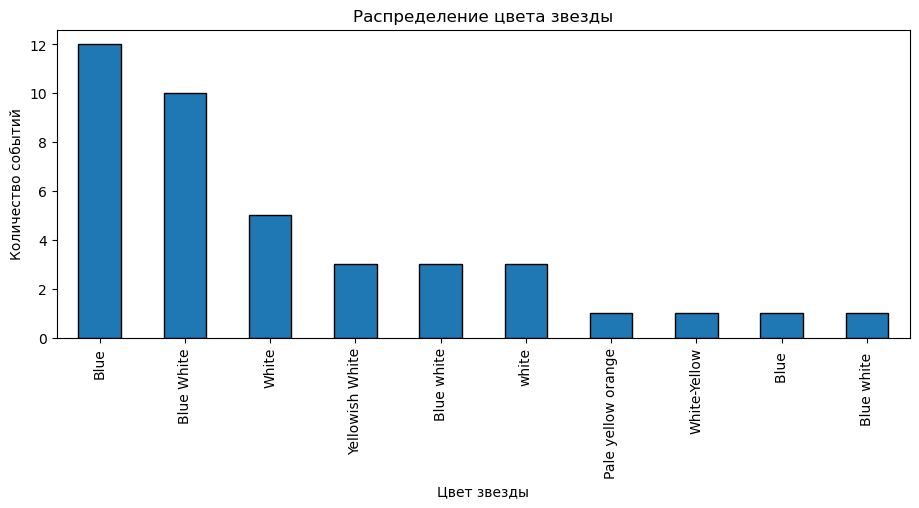

In [38]:
plt.figure(figsize = (11,4))
data[data['type']==2]['color'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Распределение цвета звезды')
plt.ylabel('Количество событий')
plt.xlabel('Цвет звезды')
plt.show()

В данном типе звезды уже 10 цветов, большинство из которых имеют приставку "белый". Указанные цвета соответствуют диаграмме Герцшпрунга — Расселла.

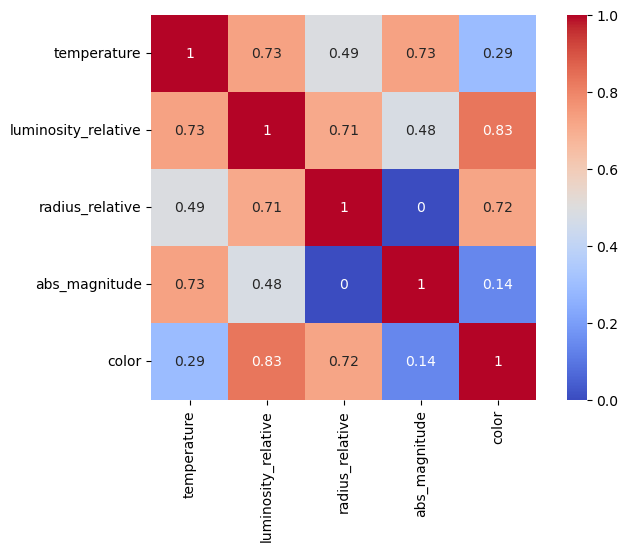

In [39]:
corr_matrix(2)

Среди признаков белых карликов имеется сильная корреляция между цветом и светимостью, достигающая значения 83%. Так же цвет коррелирует с радиусом с 72% значением. Между радиусом и абсолютной звездной величиной отсутствует корреляция.

Для данного типа звезд целевой признак сильно коррелирует со светимостью и абсолютной звездной величиной.

### Звезды главной последовательности

Главная последовательность — стадия эволюции звёзд, а также область на диаграмме Герцшпрунга — Рассела, образованная звёздами на этой стадии, и соответствующий класс светимости.

На главную последовательность звёзды попадают после стадии протозвезды — когда их единственным источником энергии становятся термоядерные реакции синтеза гелия из водорода, идущие в ядре. В этот момент возраст звезды считается нулевым и она находится на так называемой начальной главной последовательности. По мере исчерпания водорода звезда становится немного ярче, отходит от начальной главной последовательности и, когда в ядре не остаётся водорода, звезда окончательно покидает главную последовательность, причём то, как это происходит, зависит от массы звезды. Однако в любом случае дальнейшие стадии эволюции длятся гораздо меньше, чем стадия главной последовательности, и, как следствие, абсолютное большинство звёзд во Вселенной, включая Солнце, принадлежит главной последовательности. Планетные системы звёзд главной последовательности с небольшой массой представляют интерес при поиске обитаемых планет — ввиду длительного существования и стабильных размеров зоны обитаемости.

На диаграмме Герцшпрунга — Рассела главная последовательность проходит по диагонали: из верхнего левого угла (высокие светимости, синий цвет) в правый нижний угол (низкие светимости, красный цвет). Таким образом, значения масс, размеров, температур и светимостей звёзд главной последовательности тесно связаны друг с другом и лежат в довольно широком диапазоне.

Для начала разведочного анализа данных построим статистики для данного типа звезд.

In [40]:
data_describe(3)

temperature  luminosity_relative  radius_relative  abs_magnitude  type
count     40.000000            40.000000         40.00000      40.000000  40.0
mean   16018.000000         32067.386275          4.43030      -0.367425   3.0
std    10661.234972         69351.195858          2.80139       3.613592   0.0
min     4077.000000             0.085000          0.79500      -4.700000   3.0
25%     7479.250000             6.297500          1.28750      -3.702500   3.0
50%    12560.500000           738.500000          5.71250      -1.180000   3.0
75%    23030.000000         12962.500000          6.36750       2.425000   3.0
max    39000.000000        204000.000000         10.60000       6.506000   3.0

Построим столбчатую диаграмму и график зависимости светимости и температуры звезды.

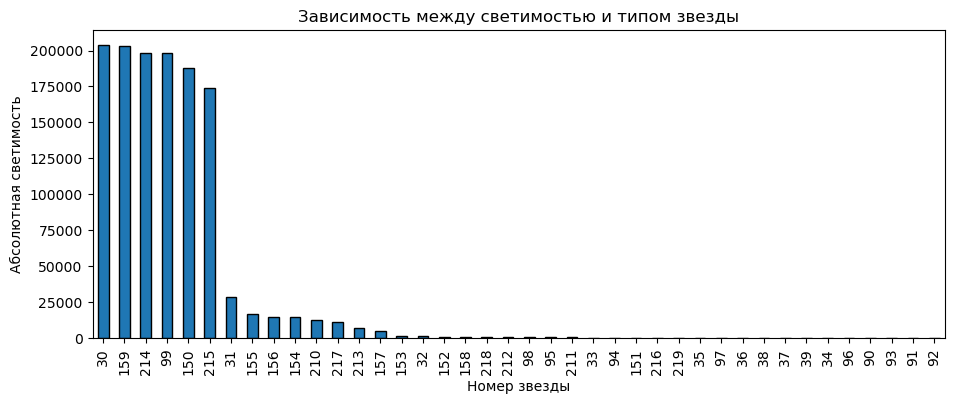

In [41]:
bar_lum(3)

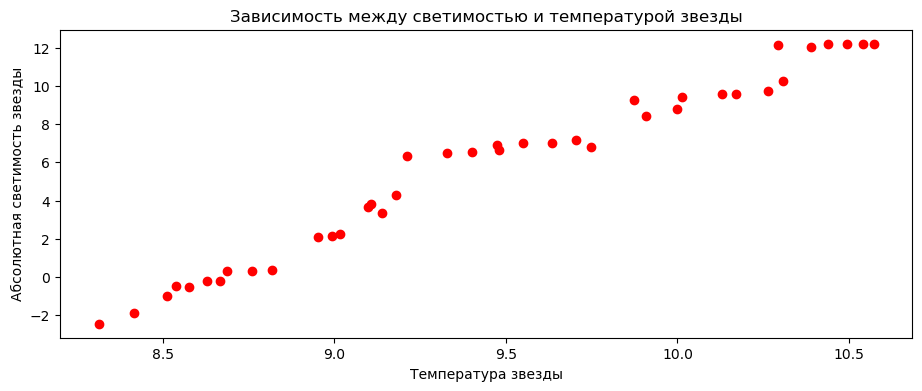

In [42]:
plt.figure(figsize = (11,4))
plt.plot(np.log(data[data['type']==3]['temperature']), 
         np.log(data[data['type']==3]['luminosity_relative']), 'ro')
plt.title('Зависимость между светимостью и температурой звезды')
plt.ylabel('Абсолютная светимость звезды')
plt.xlabel('Температура звезды')
plt.show()

Исходя из описания главной последовательности, в нее могут входить самые разнообразные звезды, как яркие так и тусклые. Что мы и видим на графиках светимости звезд. При этом использование основного графика не целесообразно, в данном случае лучше использовать логарифмированные графики, на которых видная зависимость температуры и светимости звезд.



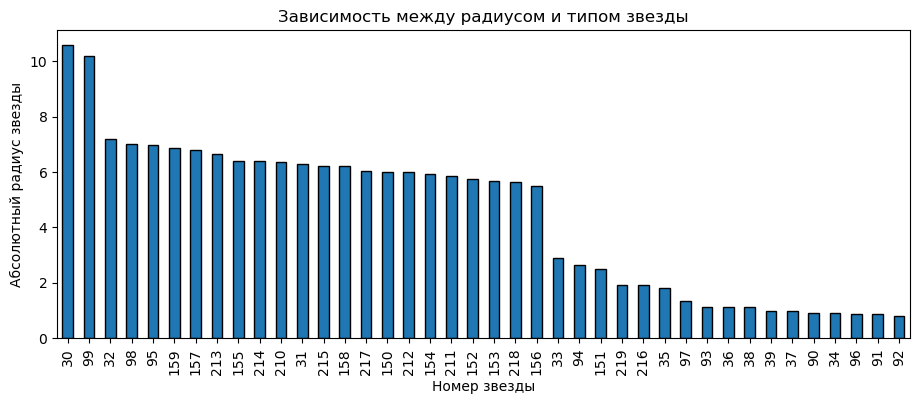

In [43]:
bar_rad(3)

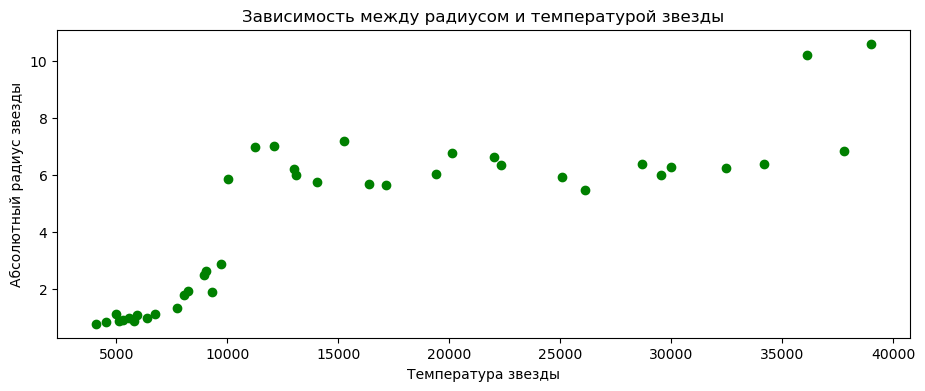

In [44]:
plot_rad(3)

Среди радиусов звезд главной последовательности можно отметить деление на 3 группы с наличием зависимости от температуры. Данная особенность подтверждает основные свойства этого типа звезд: радиус и температура находится в широком диапазоне и имеется зависимость между этими величинами.

Построим зависимость между абсолютной звездной величиной и температурой звезд.

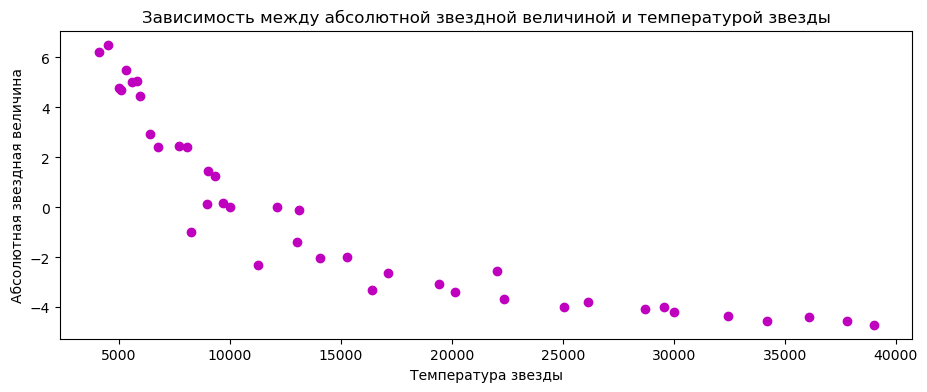

In [45]:
plot_mag(3)

На графике имеется гиперболическая зависимость звездной величиеы и температуры.

Последним проверим распределение звезд по цветам.

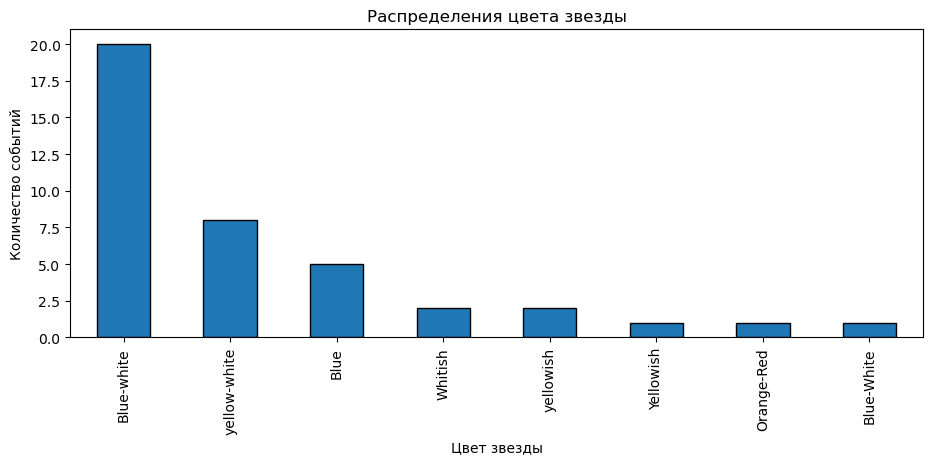

In [46]:
plt.figure(figsize = (11,4))
data[data['type']==3]['color'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Распределения цвета звезды')
plt.ylabel('Количество событий')
plt.xlabel('Цвет звезды')
plt.show()

У звезд главной последовательности имеется цветовое разнообразие, но в отличии от описания, нету явно красного цвета. 

В целом звезды этого типа представлены очень разнообразным образом, что соответсвует реальному положению дел. У признаков наблюдаются линейные и нелинейные зависимости от температуры.

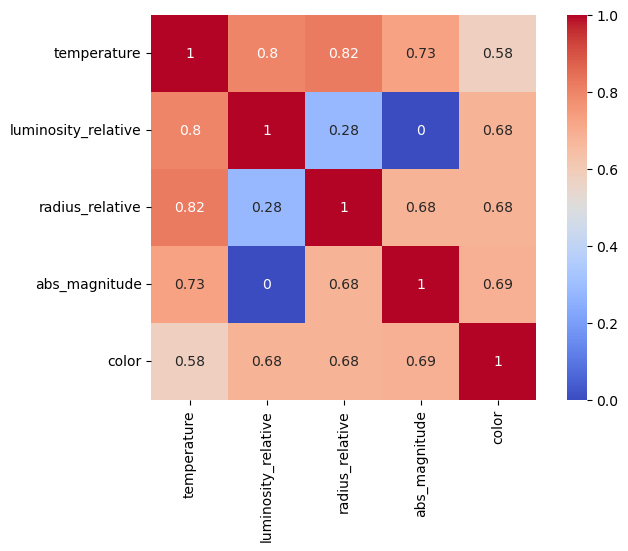

In [47]:
corr_matrix(3)

Для звезд главной последовательности имеется сильная корреляция между всеми признаками. Исколючение составляют светимость-радиус и светимость-абсолютная звездная величина.

Целевой признак имеет корреляция от 58 до 82% с остальными признаками. Это не удивительно, ведь температура свечения присутствует почти во всех формулах для вычисления характеристик звезд.

### Сверхгиганты

Сверхгиганты — одни из наиболее ярких, крупных и массивных звёзд, светимость которых может в миллионы раз превышать солнечную, а радиус — в тысячи раз. Эти звёзды занимают верхнюю часть диаграммы Герцшпрунга — Рассела и составляют класс светимости I. У них наблюдается сильный звёздный ветер, практически все они переменны.

Сверхгиганты — молодые и короткоживущие звёзды, относящиеся к населению I. Они качественно отличаются от менее массивных звёзд ходом своей эволюции. Сверхгиганты способны поддерживать в своих недрах такие термоядерные реакции, для прохождения которых необходимы высокие температуры и плотности, и синтезировать тяжёлые элементы, вплоть до железа. В какой-то момент ядро звезды коллапсирует, выделяется большое количество энергии, внешние слои уносятся и наблюдается взрыв сверхновой типа II, а от звезды остаётся нейтронная звезда или чёрная дыра. Сверхгиганты и порождаемые ими сверхновые — основной источник гелия и альфа-элементов, выбрасываемых в межзвёздную среду.

Для начала разведочного анализа данных построим статистики для данного типа звезд.

In [48]:
data_describe(4)

temperature  luminosity_relative  radius_relative  abs_magnitude  type
count     40.000000            40.000000        40.000000      40.000000  40.0
mean   15347.850000        301816.250000        51.150000      -6.369925   4.0
std    10086.784628        175756.378119        27.656826       0.560051   0.0
min     3008.000000        112000.000000        12.000000      -7.450000   4.0
25%     6899.500000        197250.000000        25.750000      -6.807500   4.0
50%    12821.000000        242145.000000        43.500000      -6.235000   4.0
75%    23181.250000        344160.000000        80.250000      -5.961250   4.0
max    40000.000000        813000.000000        98.000000      -5.240000   4.0

Построим столбчатую диаграмму и график зависимости светимости и температуры звезды.

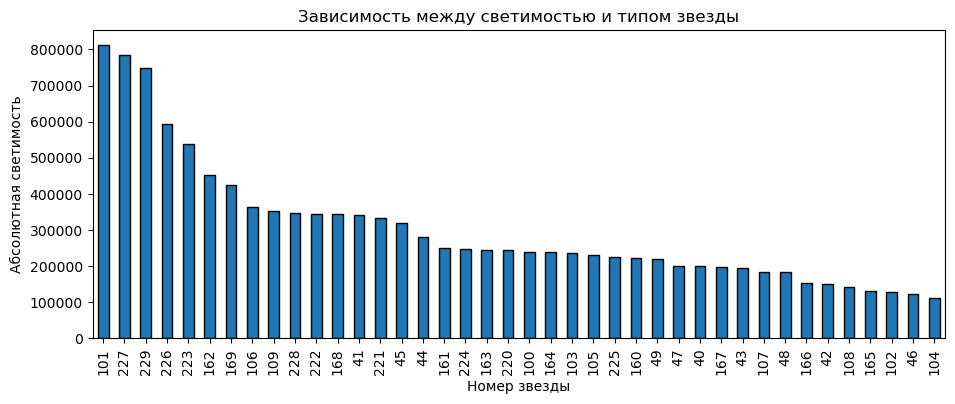

In [49]:
bar_lum(4)

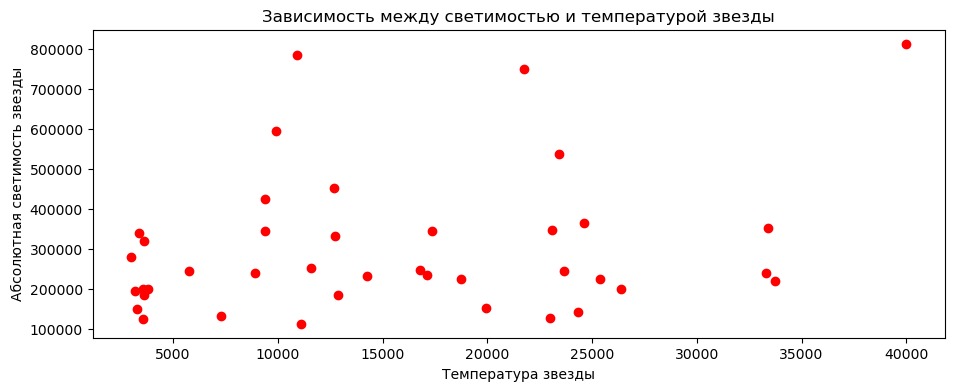

In [50]:
plot_lum(4)

Сверхгиганты имеют наибольшую светимость, но зависимость между светимостью и температурой звезд отсутствует, звезды с температурами 33 000 градусов имеют светимость ниже некоторых звезд 10 000 - 11 000 градусов Кельвина.

Построим графики радиусов звезд.

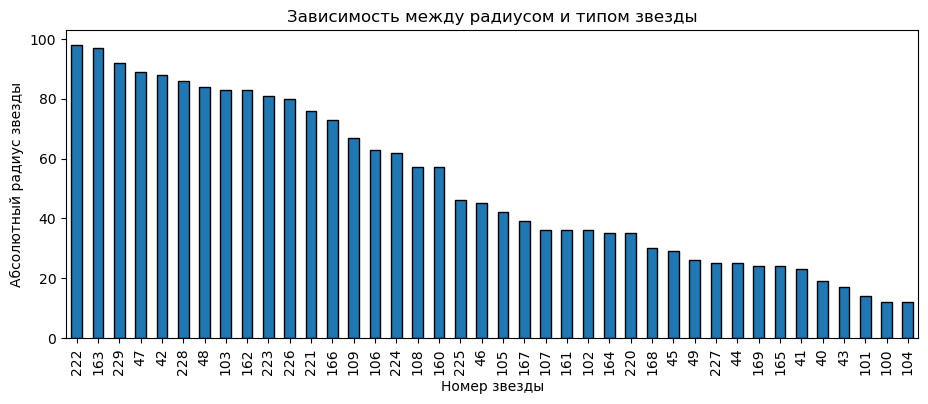

In [51]:
bar_rad(4)

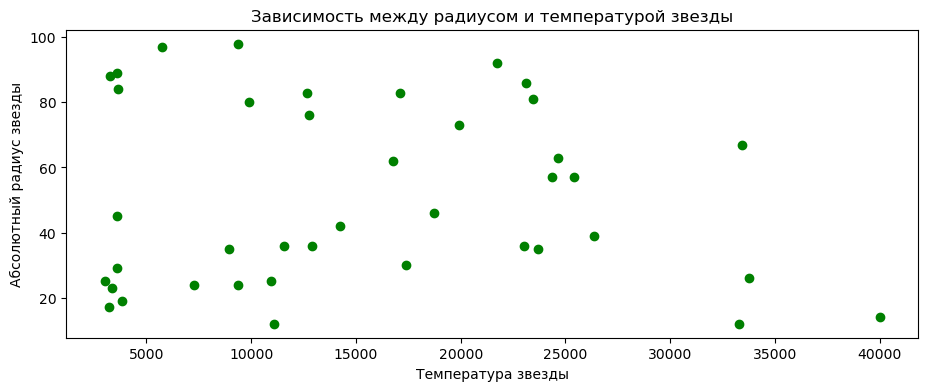

In [52]:
plot_rad(4)

Радиусы наблюдаемых обсерваторией сверхгигантов так же не зависят от температуры, хоть и присутствует снижение разброса радиусов ближе к наивысшей температуре. Что удивительно, радиусы звезд не превышают 100 солнечных, а минимальный и вовсе составляет всего 12 солнечных. 

Построим график зависимости абсолютной звездной величины и температуры звезд.

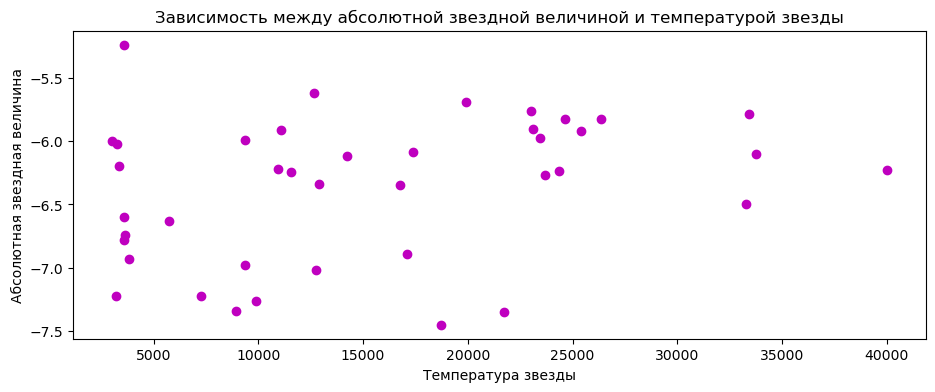

In [53]:
plot_mag(4)

Абсолютные звездные величины точно соответсвуют типичным значениям данного класса, ото -4 до -8 единиц.

Проверим какимицветами представлены звезды сверхгиганты.

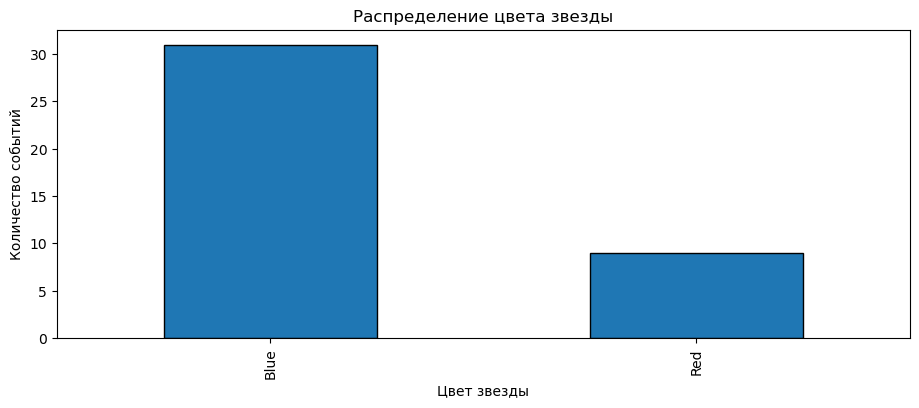

In [54]:
plt.figure(figsize = (11,4))
data[data['type']==4]['color'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Распределение цвета звезды')
plt.ylabel('Количество событий')
plt.xlabel('Цвет звезды')
plt.show()

Сверхгиганты в выборке имеют синий и красный цвет. Википедия говорит, что кроме данных цветов имеются так же и желтые сверхгиганты, например всем нам известная Полярная звезда.

Все признаки соответсвуют действительности, лишь светимость у некоторых сверхгигантов меньше типичной. Так же отсутствует какая-либо зависимость между температурой и другими признаками звезд.

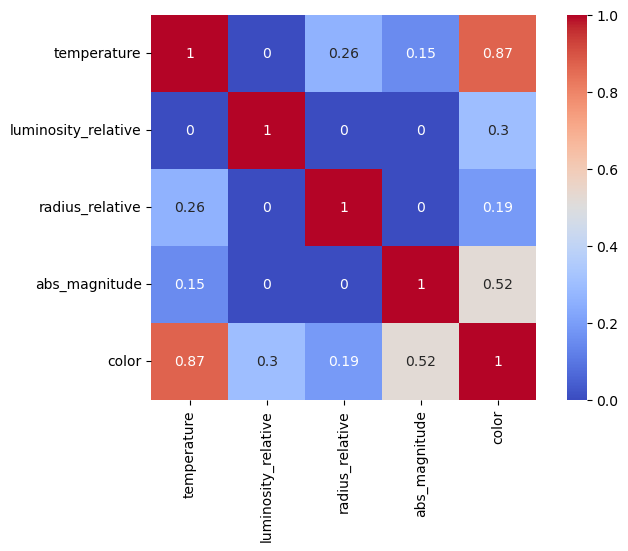

In [55]:
corr_matrix(4)

Сверхгиганты имеют низкую корреляцию меду признаками. Лишь температура и цвет звезды имеют корреляцию 80%. Отсутвует корреляция с признаком светимости и абсолютной звездной величиной с остальными признаками, кроме цвета звезды.

### Гипергиганты

Гипергигант — звезда огромной массы и размеров, имеющая на диаграмме Герцшпрунга — Рассела класс светимости 0. Гипергиганты определяются как самые мощные, самые тяжёлые, самые яркие и одновременно самые редкие и короткоживущие сверхгиганты. Обычно гипергигантами считаются сверхгиганты ярче −8m. KY Лебедя является примером пограничной звезды; объект с меньшей светимостью уже не будет классифицироваться как гипергигант.

Масса гипергиганта намного превышает массу любой звезды, даже сверхгиганта — так, типичный гипергигант в 6 раз более массивный, чем такая мощная звезда, как Ригель. Типичная масса гипергиганта — 100—120 масс Солнца и более, вплоть до 200—250 масс Солнца (самой массивной известной на данный момент считается R136a1, имеющая массу 315 масс Солнца). По размерам гипергиганты не больше сверхгигантов, однако их масса намного больше, поэтому они приближаются к теоретическому пределу массы, являющейся критической, на грани перехода к формированию чёрной дыры, и крайне неустойчивы. Самой большой по размерам звездой, известной науке, является Stephenson 2-18. Радиус звезды составляет 2150 радиусов Солнца. Излучение их тоже очень велико, а процессы, которые проходят в ходе их очень быстрой эволюции, грандиозны.

Светимость гипергигантов может превышать 500 тысяч светимостей Солнца, а иногда она составляет миллионы светимостей Солнца, так, типичный гипергигант более чем в десять раз ярче Ригеля.

Температура поверхности гипергигантов сильно различается — она может быть как 3200 К, так и выше 35 000 К. Большинство гипергигантов классифицируются как яркие голубые переменные звёзды типа S Золотой Рыбы.

Гипергиганты имеют крайне маленькую продолжительность жизни — так, продолжительность жизни гипергиганта равна в среднем одному-двум, максимум — нескольким миллионам лет. Причина этого в том, что из-за большой массы гипергиганта создаётся громадное давление и температура, пропорционально ускоряющие процесс ядерного синтеза, что в свою очередь компенсирует силы гравитации и не дает звезде сколлапсировать. Такие массивные звёзды являются большой редкостью, в нашей Галактике всего насчитывается примерно десяток гипергигантов.

Для начала разведочного анализа данных построим статистики для данного типа звезд.

In [56]:
data_describe(5)

temperature  luminosity_relative  radius_relative  abs_magnitude  type
count     40.000000            40.000000        40.000000      40.000000  40.0
mean   11405.700000        309246.525000      1366.897500      -9.654250   5.0
std    11816.991886        199343.999427       255.561357       1.453605   0.0
min     3399.000000         74000.000000       708.900000     -11.920000   5.0
25%     3603.750000        173000.000000      1193.000000     -10.875000   5.0
50%     3766.000000        266500.000000      1352.500000      -9.915000   5.0
75%    18976.000000        365957.500000      1525.000000      -8.147500   5.0
max    38940.000000        849420.000000      1948.500000      -7.580000   5.0

Построим столбчатую диаграмму и график зависимости светимости и температуры звезды.

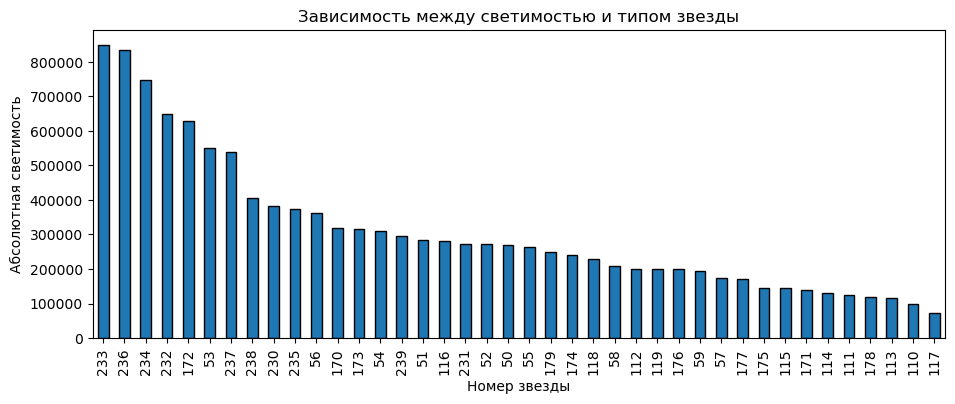

In [57]:
bar_lum(5)

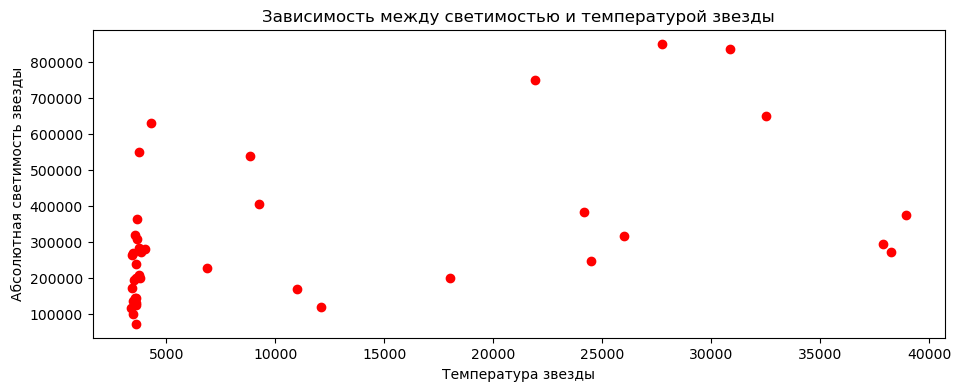

In [58]:
plot_lum(5)

In [59]:
data[data['type']==5]['temperature'].describe()

count       40.000000
mean     11405.700000
std      11816.991886
min       3399.000000
25%       3603.750000
50%       3766.000000
75%      18976.000000
max      38940.000000
Name: temperature, dtype: float64

Светимость гипергигантов изменяется в широком диапазоне, от 50 000 до 850 000 светимостей солнца. При этом большинство звезд сосредлоточено в районе 3 700 градусов. В связи с чем не может быть речи о зависимости от температуры.

Построим графики радиусов звезд.

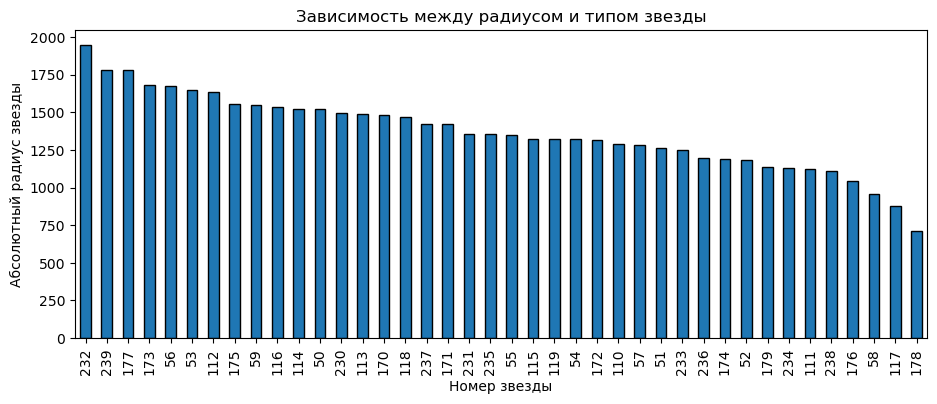

In [60]:
bar_rad(5)

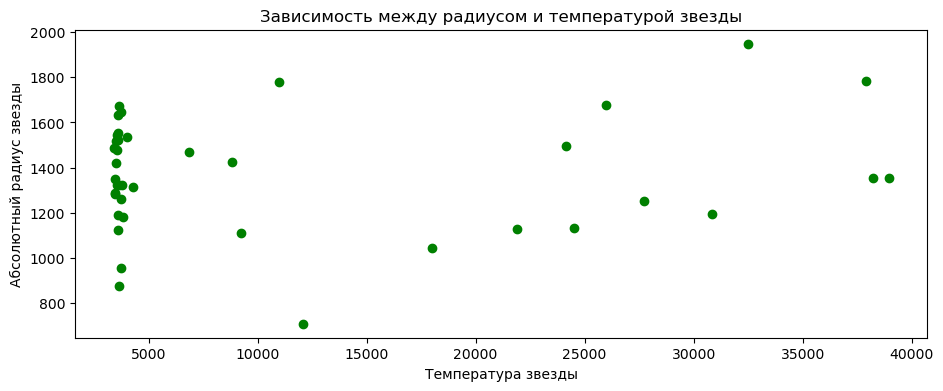

In [61]:
plot_rad(5)

Аналогично выводу по предыдущему графику, из-за скученности температур звезд около 3 700 К, отсутствует зависимость с другими признаками. Размеры гипергигантов действительно имеют очень внушительные размеры, до 2 000 радиусов солнца.

Построим график абсолютной звездной величины.

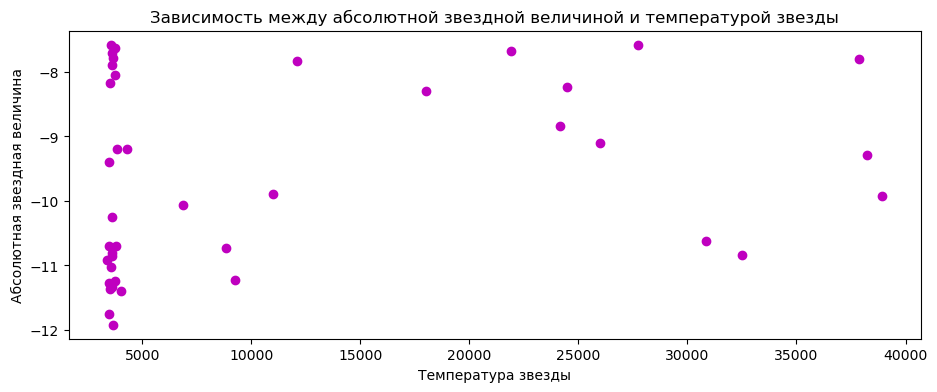

In [62]:
plot_mag(5)

Значения абсолютной звездной величины немного превышают данные диаграммы Герцшпрунга - Рассела, в которой звездная величина не превышает значения -10.

Построим столбчатую диаграмму цветов гипергигантов.

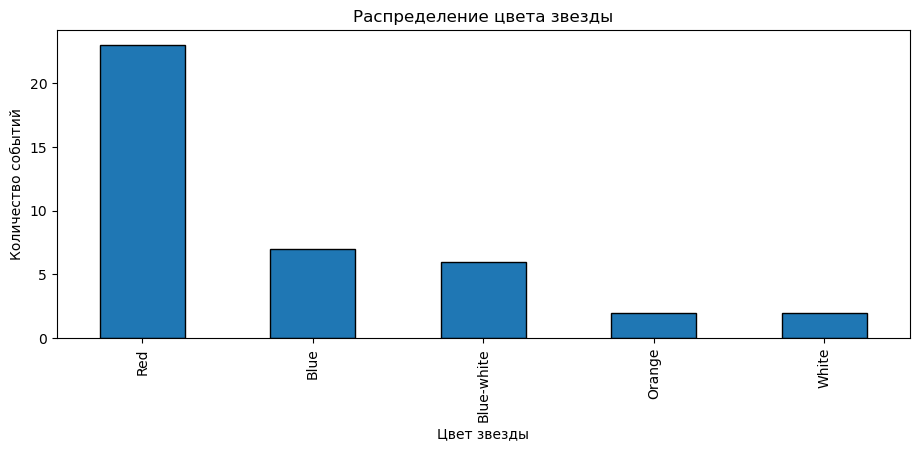

In [63]:
plt.figure(figsize = (11,4))
data[data['type']==5]['color'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Распределение цвета звезды')
plt.ylabel('Количество событий')
plt.xlabel('Цвет звезды')
plt.show()

Гипергиганты представлены всеми основными цветами спектра, от синего до красного.

**Промежуточный итог:** звезды типа гипергиганты соответствуют опеределению данному на портале Википедия. Некоторые признаки превышают значения в описании, но в целом распределение схоже. Из-за "скученности" температуры в районе 3 700 К, отсутствует зависимость с температурой звезд.

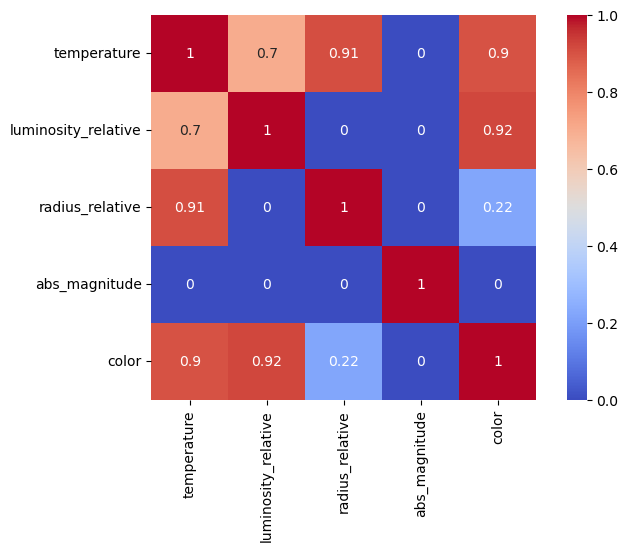

In [64]:
corr_matrix(5)

Наибульшую корреляцию с целевым признаком среди всех типов звезд имеют сверхгиганты. При этом, в отличии от остальных для этого типа полностью остутствует корреляция с признаком абсолютной звездной величины.

**Промежуточный итог:** каждый тип звезд отличается своими особенностями. Корреляция в разных типах абсолютно разная. В связи с чем различие в соотношении типов звезд в тренировочной и тестовой выборках будет сильно влиять на предсказание нейросети. 

### Цвет звезд

В процессе выполнения разведовательного анализа данных исследователь пытается исправить данные используя имеющиеся у него знания. При отсутствии компетенций следует обращаться к коллегам. Ввиду малых знаний относительно зависимостей признаков звезд коррекция данных проводится лишь в части цвета звезд, так как между цветом и температурой имеется прямая зависимость. Для остальных значений в предыдущем разделе проведена проверка на адекватность данных.

В признаке цвета звезд присутствует слишком много уникальных значений,часть из которых является неявными дубликатами.

In [65]:
data['color'].nunique()

19

In [66]:
data['color'].sort_values().unique()

array(['Blue', 'Blue ', 'Blue White', 'Blue white', 'Blue white ',
       'Blue-White', 'Blue-white', 'Orange', 'Orange-Red',
       'Pale yellow orange', 'Red', 'White', 'White-Yellow', 'Whitish',
       'Yellowish', 'Yellowish White', 'white', 'yellow-white',
       'yellowish'], dtype=object)

Приведем все звезды к основным 7 цветам: синий, бело-синий, белый, бело-желтный, желтый, оранжевый и красный. Перед этим нужно привести к нижнему регистру и удалить лишние пробелы в значениях признака.

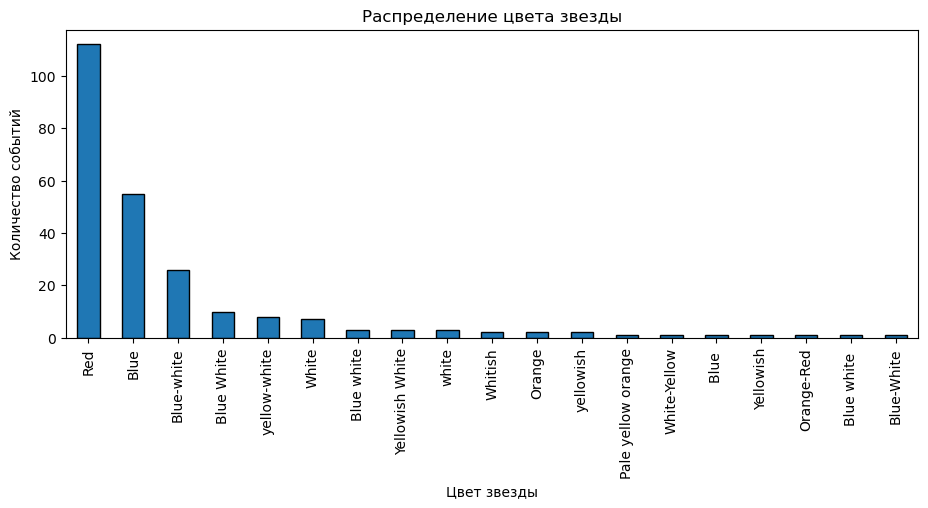

In [67]:
plt.figure(figsize = (11,4))
data['color'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Распределение цвета звезды')
plt.ylabel('Количество событий')
plt.xlabel('Цвет звезды')
plt.show()

Наибольшее количество звезд имеют красный цвет. Построим график зависимости цвета от температуры.

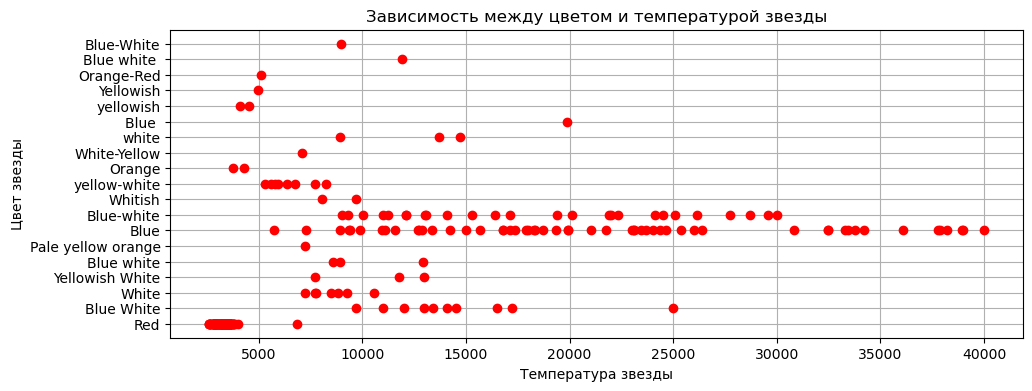

In [68]:
plt.figure(figsize = (11,4))
plt.plot(data['temperature'], data['color'], 'ro')
plt.title('Зависимость между цветом и температурой звезды')
plt.ylabel('Цвет звезды')
plt.xlabel('Температура звезды')
plt.grid(True)
plt.show()

Из графика видно, что цвета не совпадают с типичным для звезд значением. Так же некоторые цвета перекрывают другие, особенно синий цвет, который по характеристике спектра должен иметь температуру выше 30 000 К, а имеет от 6 000 до 40 000.

Поэтому заменим цвет соответствующий характерным спектрам. Для этого занова переопределим признак.

In [69]:
data['color'] = data['color'].str.strip().str.lower()

data['color'] = data['color'].replace('blue', 'b')
data['color'] = data['color'].replace(['blue white', 'blue-white'], 'bw')
data['color'] = data['color'].replace(['white', 'whitish'], 'w')
data['color'] = data['color'].replace(['white-yellow', 'yellow-white', 'yellowish white'], 'yw')
data['color'] = data['color'].replace(['yellowish', 'pale yellow orange'], 'y')
data['color'] = data['color'].replace(['orange', 'orange-red'], 'o')
data['color'] = data['color'].replace('red', 'r')

Построим график зависимости между цветом и температурой звезды после преобразования признака.

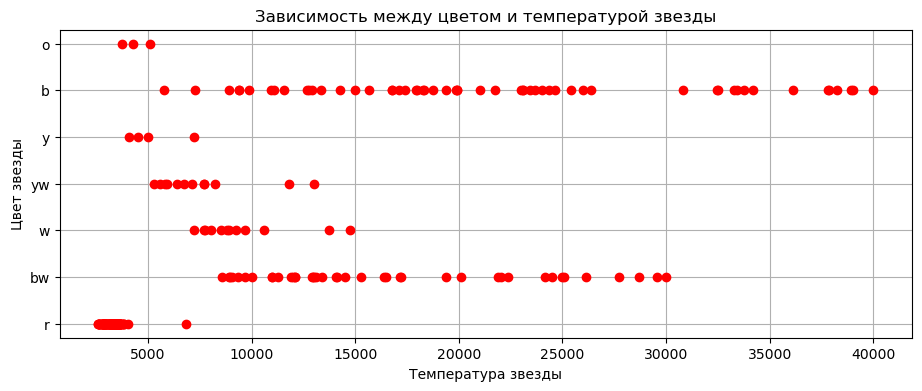

In [70]:
plt.figure(figsize = (11,4))
plt.plot(data['temperature'], data['color'], 'ro')
plt.title('Зависимость между цветом и температурой звезды')
plt.ylabel('Цвет звезды')
plt.xlabel('Температура звезды')
plt.grid(True)
plt.show()

Часть цветов температур перекрываются другими цветами. В некоторых цветах наблюдаются выбросы (например для y, yw, w). Самый многочисленный цвет - это голубой, диапазон которого изменяется от 6 500 до 40 000 К.

### Корреляция признаков

При разведовательном анализе данных для каждого типа построены матрицы корреляции phik. Из которых видно, что у каждого типа имеются свои закономерности в корреляциях. Для генеральной совокупности данных сделаем матрицу корреляции отдельно.

Построим матрицу корреляции phik с указанием численных признаков.

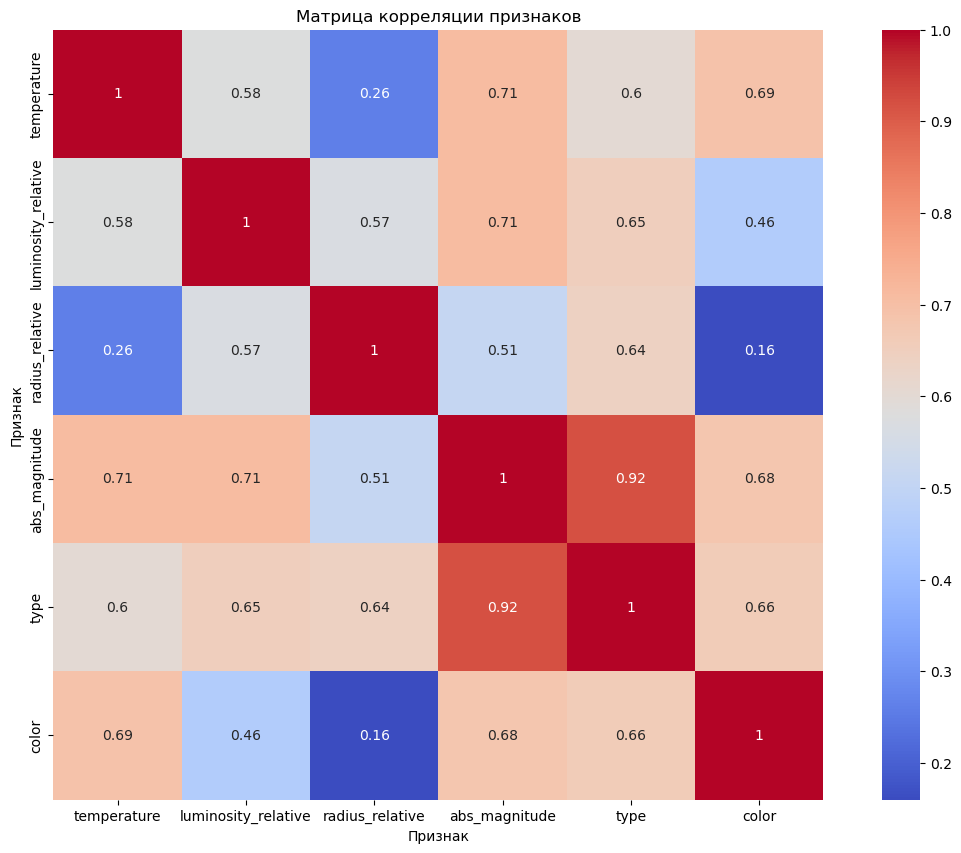

In [71]:
data_corr = data.phik_matrix(interval_cols=['temperature', 'luminosity_relative', 'radius_relative', 'abs_magnitude'])

plt.figure(figsize = (15,10))
sns.heatmap(data_corr.round(2), cmap='coolwarm', annot=True, square=True)
plt.title('Матрица корреляции признаков')
plt.ylabel('Признак')
plt.xlabel('Признак')
plt.show()

**Выводы из матрицы корреляции:**

- Температура и яркость. Существует сильная положительная корреляция между температурой звезды и её абсолютной звездной величиной, что подтверждает ожидаемую закономерность. Более горячие звезды обычно обладают более высокой яркостью.

- Связь с типом звезды. Абсолютная звездная величина коррелирует с типом звезды. Это свидетельствует о том, что тип звезды может быть частично определен исходя из её яркости. Также температура и цвет звезды тесно связаны с её типом.

- Относительная светимость. Между температурой и относительной светимостью существует умеренная положительная корреляция. Более горячие звезды имеют тенденцию быть более яркими, хотя данная зависимость не является столь сильной, как связь между температурой и другими параметрами.

- Радиус. Параметр радиуса звезды демонстрирует слабую или умеренную корреляцию с другими характеристиками. Это может указывать на то, что радиус звезды не всегда имеет прямую линейную зависимость с другими изучаемыми параметрами.

### Синтетические признаки

Одним из способов улучшения предсказания модели является добавление синтетических признаков. В текущем проекте будем работать с исходными признаками светимости и радиуса. Цвет и тип - категориальные, абсолютная звездная величина находится в небольшом диапазоне. А вот для радиуса и светимости можно посчитать абсолютные значения, добавить логирифмирование абсолютного и относительного значения для уменьшения разброса между карликовыми звездами и гипергигантами.

In [72]:
data['radius'] = data['radius_relative'] * R0
data['radius_log_abs'] = np.log(data['radius'])
data['radius_log_rel'] = np.log(data['radius_relative'])
data['radius_sqrt_abs'] = np.sqrt(data['radius'])
data['radius_sqrt_rel'] = np.sqrt(data['radius_relative'])

data['luminosity'] = data['luminosity_relative'] * L0
data['luminosity_log_abs'] = np.log(data['luminosity'])
data['luminosity_log_rel'] = np.log(data['luminosity_relative'])
data['luminosity_sqrt_abs'] = np.sqrt(data['luminosity'])
data['luminosity_sqrt_rel'] = np.sqrt(data['luminosity_relative'])

Таким образом создано 10 дополнительных признаков, которые помогут нейронной сети произвести предсказания. В целом таких признаков можно создать гараздо больше, используя тригонометрические и другие математические функции для каждого признака в отдельности. Но такие синтетические признаки сильно "раздуют" исходный датасет и время предсказания кратно увеличится.

## Предобработка и анализ данных

Из разведовательного анализа данных выявлена зависимость признаков в зависимости от типа звезды. Различное распределение типов в тренировочном и тестовом выборках сильно снизит качество предсказания модели, так как она станет в большей степени полагаться на данные тренировочной выборки. В частном случае в тренировочном датасете может отсутствовать один из типов, либо присутствовать в малом количестве, когда в тестовом составлять более половины. В таком случае модель будет некорректно предсказывать температуру данного типа. Для решения этой проблемы следуется разбить исходный датасет по типам и создавать выборки по равным количествам звезд каждого типа.

Для тестовой выборки отведем 25% исходного датасета. Для сохранения пропорций классов используем параметр stratify. Выведем на экран размеры выборок.

In [73]:
# Создаем списки для хранения тренировочных и тестовых данных
train_data = pd.DataFrame(columns=data.columns)
test_data = pd.DataFrame(columns=data.columns)

# Разделяем каждый датасет на тренировочную и тестовую выборки
for type in range(6):
    # Разделяем данные на тренировочную и тестовую выборки
    train_set, test_set = train_test_split(data[data['type']==type], test_size=0.25, random_state=42, shuffle=True)
    
    # Добавляем данные в соответствующие списки
    train_data = pd.concat([train_data, train_set])
    test_data = pd.concat([test_data, test_set])
# Перемешаем данные и выделим из него целевой признак
train_data = train_data.sample(frac=1, random_state=42)
test_data = test_data.sample(frac=1, random_state=42)
features_train = train_data.drop('temperature', axis=1)
features_test = test_data.drop('temperature', axis=1)
target_train = train_data['temperature']
target_test = test_data['temperature']
# Выведем на экран размеры выборок
print(features_train.shape, features_test.shape)

(180, 15) (60, 15)


Среди всех признаков выделим категориальные и численные. Запишем их в отдельные переменные.

In [74]:
columns_category = ['type', 'color']
columns_numeric = ['luminosity_relative', 'radius_relative', 'abs_magnitude', 
                   'radius', 'radius_log_abs','radius_log_rel', 'radius_sqrt_abs', 
                   'radius_sqrt_rel', 'luminosity','luminosity_log_abs', 
                   'luminosity_log_rel', 'luminosity_sqrt_abs', 'luminosity_sqrt_rel']

Для удобства преобразования используем ColumnTransformer. Численные признаки преобразуем StandardScaler, а категориальные ОНЕ. Такой выбор вызван особенностью работы с данными нейронных сетей. Другая особенность в том, что нейросеть лучше предсказывает с отсутствием параметра drop='first' для кодировщика OHE.

In [75]:
preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), columns_numeric),
                ("category", OneHotEncoder(handle_unknown='ignore', sparse=False), columns_category)
            ]
        )

Произведем преобразование данных. Для обучения выберем тренировочные данные.

In [76]:
preprocessor.fit(features_train)

features_train_p = preprocessor.transform(features_train)
features_test_p = preprocessor.transform(features_test)

## Построение базовой нейронной сети

За базовую модель принято решение взять нейросеть с 2 скрытыми слоями. В качестве функции активации выбрана ReLU, так как она лучше работает с моделями регрессии.

Нейросеть работает с данными вида тензор. Преобразуем имеющиеся данные в удобный для нее вид.

In [77]:
X_train = torch.FloatTensor(features_train_p)
X_test = torch.FloatTensor(features_test_p)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

Далее создадим базовую нейронную сеть и расчитаем целевую метрику RMSE для тестовой выборки. При выполнении проекта немного менялись исходные данные для нейросети такие как количество нейронов, размер батчей и количество эпох. В базовой модели не используются методы регуляризации.

In [78]:
# Исходные данные для случайных значений модели
torch.manual_seed(2023)
torch.use_deterministic_algorithms(True)

# Создаем базовую модель и задаем для нее количество нейронов на каждом слое

in_neirons = X_train.shape[1]
hidden_neirons_1 = 12
hidden_neirons_2 = 8
hidden_neirons_3 = 4
out_neirons = 1

net = nn.Sequential(
    nn.Linear(in_neirons, hidden_neirons_1), 
    nn.ReLU(),
    nn.Linear(hidden_neirons_1, hidden_neirons_2), 
    nn.ReLU(),
    nn.Linear(hidden_neirons_2, hidden_neirons_3), 
    nn.ReLU(),
    nn.Linear(hidden_neirons_3, out_neirons), 
    nn.ReLU()
)

# Укажем оптимизатор Adam со скоростью обучения 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
# Функция потерь будет MSELoss
loss = nn.MSELoss()
# Размер батча зададим 10, в целом его можно спокойно менять
batch_size = 10
num_batches = ceil(len(X_train)/batch_size)
# Количество эпох
num_epochs = 100

# Создаем цикл обучения и предсказания нейросети
for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    # Подбор весов на тренировочной выборке
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = net.forward(X_batch).flatten()

        loss_value = loss(preds, y_batch)

        loss_value.backward()

        optimizer.step()
    # Предсказания на тестовой выборке
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test)
        rmse = mean_squared_error(y_test, test_preds.detach().numpy(), squared=False)
        print(f'Epoch {epoch} complite with RMSE = {rmse}')

Epoch 0 complite with RMSE = 14042.1591796875
Epoch 10 complite with RMSE = 8447.7998046875
Epoch 20 complite with RMSE = 6120.68408203125
Epoch 30 complite with RMSE = 5675.36328125
Epoch 40 complite with RMSE = 5502.828125
Epoch 50 complite with RMSE = 5299.84716796875
Epoch 60 complite with RMSE = 5093.6474609375
Epoch 70 complite with RMSE = 4911.19970703125
Epoch 80 complite with RMSE = 4773.49755859375
Epoch 90 complite with RMSE = 4639.8232421875
Epoch 99 complite with RMSE = 4536.859375


Базовая модель на 100 эпохах предсказывает с метрикой RMSE равной **4 540 К**. Данное значение близко к границе минимально-требуемого для выполнения задания по улучшению сети.

Построим график "Факт-Прогноз" температур звезд.

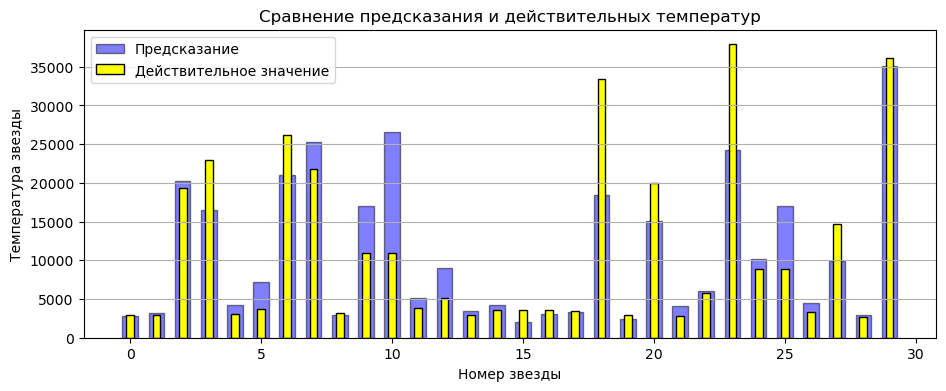

In [79]:
def final_bar(predict, num_bar=30):
    x = np.arange(num_bar)
    plt.figure(figsize = (11,4))
    plt.bar(x, predict[:num_bar], width = 0.6, color = 'blue', edgecolor = 'black', label='Предсказание', alpha=0.5)
    plt.bar(x, y_test[:num_bar], width = 0.3, color = 'yellow', edgecolor = 'black', label='Действительное значение')
    plt.title('Сравнение предсказания и действительных температур')
    plt.ylabel('Температура звезды')
    plt.xlabel('Номер звезды')
    plt.legend()
    plt.grid(axis='y')
    plt.show()
    
final_bar(test_preds.data.flatten())

Анализируя график сопоставления предсказанных и фактических значений температур звёзд, можно утверждать, что нейронная сеть успешно предсказывает температуру для некоторых звёзд с высокой точностью, в то время как для других (например, звёзд с номерами 3, 6, 9, 10, 18, 23 и тд) наблюдается значительное расхождение, достигающее **15 000** К.

Такое расхождение можно объяснить тремя причинами:
- **Недостаточным обучением нейронной сети;**
- **Ограниченным объёмом исходных данных;**
- **Особенностями или неточностями в признаках определённых звёзд.**

Для решения данных проблем необходимо использовать соответствующие методы: 

Для дополнительного обучения модели можно изменить архитектуру слоёв (количество скрытых слоёв, количество нейронов в слоях, добавить регуляризацию, изменить функции активации).

Для устранения ограниченности набора данных можно добавить новые данные, дублировать имеющиеся данные или провести аугментацию существующих.

В случае, если предыдущие методы не принесут ожидаемых результатов и расхождение в предсказаниях для определённых звёзд останется значительным, необходимо провести индивидуальный анализ каждой звезды, учитывая её тип. Возможно, для этого типа звёзд признаки характеризуются необычно или находятся за пределами диапазона остальных звёзд. Также возможна ошибка в измерении характеристик для данной звезды.

Так же следует обратиться к экспертам интересующей сферы, возможно они подскажут особенности и методы решения. Взаимодействие с профессионалами является одним из наилучших способов быстрого углубления в предметную область.

## Улучшение нейронной сети

С целью улучшения результатов нейронной сети необходимо провести подбор оптимальных параметров. Для этих целей есть несколько решений.

**Grid Search** 

Самый естественный способ организовать перебор наборов параметров — сделать перебор по сетке:
- для каждого параметра фиксируется несколько значений;
- перебираются все комбинации значений различных параметров, на каждой из этих комбинаций модель обучается и тестируется;
- выбирается комбинация, на которой модель показывает лучшее значение метрики.

Большой минус данного метода: если комбинаций параметров слишком много, либо каждое обучение длится долго, алгоритм не завершится за разумное время.

**Random Search**

Если количество комбинаций параметров очень большое, можно какими-то способами пытаться справляться с этой проблемой:

- взять меньше значений каждого параметра, но тогда есть шансы пропустить наилучшую комбинацию;
- оптимизировать параметры последовательно, а не перебирать их комбинации, но снова есть шанс получить неоптимальное решение;
- перебирать не все комбинации параметров, а только случайное подмножество.

Последний способ называется Random Search. Для каждого параметра задаётся распределение, из которого выбирается его значение, и комбинация параметров составляется семплированием из этих распределений. Таким образом, благодаря случайному выбору очередной комбинации гиперпараметров можно найти оптимальную комбинацию за меньшее число итераций.

**Optuna**

Другим методом подбора гиперпараметров является библиотека Optuna. **Optuna** — это фреймворк для для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения. Она подбирает эти параметры методом проб и ошибок.

Ключевые особенности фреймворка:
- настраиваемое пространство поиска параметров. Разработчик может самостоятельно задать пространство для поиска параметров, используя базовый синтаксис Python (циклы, условия);
- алгоритмы SoTA для выбора параметров из пространства заданного разработчиком (samplers) и для ранней остановки бесперспективных экспериментов (pruners). В Optuna представлены различные алгоритмы семплирования и прунинга, разработчик может выбрать какой-то конкретный, оставить дефолтный, или написать свой собственный;
- легкость расспаралеливания процесса поиска параметров. Также к Optuna можно прикрутить dashboard с визуализацией обучения в реальном времени.

Зададим количество эпох обучения.

In [80]:
EPOCHS = 400

Для перебора параметров модели создадим функцию изменяемой модели. Зададим от 1 до 5 скрытых слоев. Каждому слою добавим свои параметры регуляризации.

In [81]:
def changeable_model(trial):
    # Зададим количество слоев
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []
    # Количество нейронов на входе
    in_features = X_train.shape[1]
    
    # Цикл создания скрытых слоев для модели
    for i in range(n_layers):
        # Количество нейронов на выходе
        out_features = trial.suggest_int("n_units_{}".format(i), 2, 30)
        # Добавление функции активации и регуляризации
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        momentum = trial.suggest_float("momentum_{}".format(i), 0.1, 0.4, step=0.01)
        eps = trial.suggest_float("eps_{}".format(i), 1e-6, 1e-4, log=True)
        layers.append(nn.BatchNorm1d(out_features, momentum=momentum, eps=eps))
        p = trial.suggest_float("dropout_{}".format(i), 0.1, 0.5, step=0.05)
        layers.append(nn.Dropout(p))
        in_features=out_features
    # Выходной слой
    layers.append(nn.Linear(out_features, 1))
    layers.append(nn.ReLU())
    return nn.Sequential(*layers)

Создадим функцию для подбора параметров библиотекой Optuna. В качестве перебираемых параметров выберем скорость обучения и размер батчей.

In [82]:
def objective(trial: optuna.Trial):
    
    # Исходные данные для случайных значений модели
    torch.manual_seed(2023)
    torch.use_deterministic_algorithms(True)
    
        
    # Улучшаемая модель с дополнительными слоями Dropout и BatchNorm
    net = changeable_model(trial)
    
    # Остальные перебираемые параметры
    lr = trial.suggest_float("lr", 1e-3, 1e-2, log=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    batch_size = trial.suggest_int("batch_size", 10, 30, 5)
    num_batches = ceil(len(X_train)/batch_size)
    
    # Функция потерь
    loss = nn.MSELoss(reduction='sum') 
    
    # Список для записи метрики на тестовой выборке
    result_list = []
    
    
    # Создаем цикл обучения и предсказания нейросети
    for epoch in range(EPOCHS):
        order = np.random.permutation(len(X_train))
        net.train()
        
        # Подбор весов на тренировочной выборке
        for batch_idx in range(num_batches):
            # Деление на батчи
            start_index = batch_idx * batch_size
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            # Обнуление градиента
            optimizer.zero_grad()
            
            # Прямой проход
            preds = net(X_batch).flatten()
            
            loss_value = loss(preds, y_batch)
            
            # Обратный проход
            loss_value.backward()
            optimizer.step()
            
        # Предсказания на тестовой выборке
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            rmse_opt = mean_squared_error(y_test, test_preds.detach().numpy(), squared=False)
            result_list.append(rmse_opt)
            
    # Сохраняем список с метриками для вывода на экран        
    trial.set_user_attr("result_list", result_list)
    return rmse_opt

Напишем функцию для вывода значений метрик.

In [83]:
# Определение Callback для вывода метрик
def custom_callback(study: optuna.Study, trial: optuna.Trial):
    trial.user_attrs["result_list"]
    result_list = trial.user_attrs["result_list"]
    print(f"Trial {trial.number}: result={result_list}")

Samplers в Optuna это набор алгоритмов для поиска параметров. Зададим поиск параметров с минимизацией метрики, sampler - TPESampler, pruner - HyperbandPruner. 

Samplers в Optuna это набор алгоритмов для поиска параметров. 

Pruners в Optuna - это набор алгоритмов для прореживания экспериментов. Pruning - это механизм который позволяет обрывать эксперименты , которые с большой долей вероятности приведут к не оптимальным результатам.

In [84]:
study = optuna.create_study(direction="minimize", 
                            sampler = TPESampler(seed=42),
                            pruner = optuna.pruners.HyperbandPruner(),
                            study_name=f"Training_example_{dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
study.optimize(objective, n_trials=200, callbacks=[custom_callback])

[I 2023-12-06 10:05:57,616] A new study created in memory with name: Training_example_2023-12-06_10-05-57
[I 2023-12-06 10:06:15,728] Trial 0 finished with value: 7027.42041015625 and parameters: {'n_layers': 2, 'n_units_0': 29, 'momentum_0': 0.32, 'eps_0': 1.575132049977973e-05, 'dropout_0': 0.15000000000000002, 'n_units_1': 6, 'momentum_1': 0.11, 'eps_1': 5.39948440978744e-05, 'dropout_1': 0.35, 'lr': 0.005105903209394756, 'batch_size': 10}. Best is trial 0 with value: 7027.42041015625.


Trial 0: result=[14041.938, 12970.243, 12770.329, 10668.67, 7027.4204]


[I 2023-12-06 10:06:26,631] Trial 1 finished with value: 13794.46875 and parameters: {'n_layers': 5, 'n_units_0': 26, 'momentum_0': 0.16, 'eps_0': 2.310201887845294e-06, 'dropout_0': 0.15000000000000002, 'n_units_1': 10, 'momentum_1': 0.26, 'eps_1': 7.30953983591291e-06, 'dropout_1': 0.2, 'n_units_2': 19, 'momentum_2': 0.14, 'eps_2': 3.839629299804171e-06, 'dropout_2': 0.25, 'n_units_3': 15, 'momentum_3': 0.33999999999999997, 'eps_3': 2.5081156860452325e-06, 'dropout_3': 0.30000000000000004, 'n_units_4': 19, 'momentum_4': 0.11, 'eps_4': 1.640928673064794e-05, 'dropout_4': 0.15000000000000002, 'lr': 0.001161586598924645, 'batch_size': 30}. Best is trial 0 with value: 7027.42041015625.


Trial 1: result=[14042.77, 14005.514, 14004.826, 13922.619, 13794.469]


[I 2023-12-06 10:06:58,566] Trial 2 finished with value: 5053.85205078125 and parameters: {'n_layers': 5, 'n_units_0': 25, 'momentum_0': 0.19, 'eps_0': 1.5679933916723006e-06, 'dropout_0': 0.4, 'n_units_1': 14, 'momentum_1': 0.13, 'eps_1': 9.780337016659406e-06, 'dropout_1': 0.1, 'n_units_2': 28, 'momentum_2': 0.18, 'eps_2': 2.1137059440645735e-05, 'dropout_2': 0.2, 'n_units_3': 17, 'momentum_3': 0.26, 'eps_3': 2.342658105820405e-06, 'dropout_3': 0.5, 'n_units_4': 24, 'momentum_4': 0.39, 'eps_4': 6.161049539380962e-05, 'dropout_4': 0.35, 'lr': 0.008353610755311758, 'batch_size': 10}. Best is trial 2 with value: 5053.85205078125.


Trial 2: result=[14041.499, 6468.738, 6418.7134, 5384.6294, 5053.852]


[I 2023-12-06 10:07:07,531] Trial 3 finished with value: 10478.599609375 and parameters: {'n_layers': 1, 'n_units_0': 3, 'momentum_0': 0.2, 'eps_0': 5.989003672254308e-06, 'dropout_0': 0.2, 'lr': 0.006741204610702764, 'batch_size': 15}. Best is trial 2 with value: 5053.85205078125.


Trial 3: result=[14042.28, 13527.374, 13466.736, 12154.626, 10478.6]


[I 2023-12-06 10:07:15,613] Trial 4 finished with value: 4840.2587890625 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.14, 'eps_0': 4.0215545266902885e-05, 'dropout_0': 0.1, 'n_units_1': 30, 'momentum_1': 0.33, 'eps_1': 2.4970737145052737e-06, 'dropout_1': 0.1, 'lr': 0.006538248584518042, 'batch_size': 25}. Best is trial 4 with value: 4840.2587890625.


Trial 4: result=[14042.187, 11517.015, 11774.474, 7071.037, 4840.259]


[I 2023-12-06 10:07:29,341] Trial 5 finished with value: 5642.0576171875 and parameters: {'n_layers': 4, 'n_units_0': 24, 'momentum_0': 0.12000000000000001, 'eps_0': 5.211124595788262e-06, 'dropout_0': 0.15000000000000002, 'n_units_1': 27, 'momentum_1': 0.29000000000000004, 'eps_1': 4.589824181495651e-06, 'dropout_1': 0.1, 'n_units_2': 11, 'momentum_2': 0.2, 'eps_2': 2.878805718308926e-05, 'dropout_2': 0.35, 'n_units_3': 27, 'momentum_3': 0.24000000000000002, 'eps_3': 1.7345566642360946e-06, 'dropout_3': 0.4, 'lr': 0.005764810670114668, 'batch_size': 20}. Best is trial 4 with value: 4840.2587890625.


Trial 5: result=[14042.486, 12114.501, 12152.004, 8404.609, 5642.0576]


[I 2023-12-06 10:07:38,684] Trial 6 finished with value: 13534.4638671875 and parameters: {'n_layers': 4, 'n_units_0': 16, 'momentum_0': 0.26, 'eps_0': 7.1627869998973385e-06, 'dropout_0': 0.1, 'n_units_1': 5, 'momentum_1': 0.1, 'eps_1': 1.874221098555571e-05, 'dropout_1': 0.2, 'n_units_2': 16, 'momentum_2': 0.38, 'eps_2': 3.1519872951938878e-06, 'dropout_2': 0.25, 'n_units_3': 23, 'momentum_3': 0.17, 'eps_3': 1.4254757044027448e-06, 'dropout_3': 0.2, 'lr': 0.0014495102383254683, 'batch_size': 30}. Best is trial 4 with value: 4840.2587890625.


Trial 6: result=[14042.769, 13977.463, 13976.241, 13815.527, 13534.464]


[I 2023-12-06 10:08:00,044] Trial 7 finished with value: 5338.60986328125 and parameters: {'n_layers': 5, 'n_units_0': 20, 'momentum_0': 0.37, 'eps_0': 4.0489662225846776e-05, 'dropout_0': 0.15000000000000002, 'n_units_1': 27, 'momentum_1': 0.26, 'eps_1': 4.119839624605191e-05, 'dropout_1': 0.5, 'n_units_2': 11, 'momentum_2': 0.13, 'eps_2': 2.856737429847189e-06, 'dropout_2': 0.25, 'n_units_3': 25, 'momentum_3': 0.36, 'eps_3': 1.0325337616482043e-06, 'dropout_3': 0.30000000000000004, 'n_units_4': 14, 'momentum_4': 0.16, 'eps_4': 1.7367237151593152e-06, 'dropout_4': 0.25, 'lr': 0.008768184989765535, 'batch_size': 15}. Best is trial 4 with value: 4840.2587890625.


Trial 7: result=[14042.306, 10312.961, 10162.831, 6030.3706, 5338.61]


[I 2023-12-06 10:08:07,824] Trial 8 finished with value: 13931.7314453125 and parameters: {'n_layers': 3, 'n_units_0': 22, 'momentum_0': 0.21000000000000002, 'eps_0': 8.781408196485981e-05, 'dropout_0': 0.5, 'n_units_1': 9, 'momentum_1': 0.25, 'eps_1': 3.9972068191218075e-06, 'dropout_1': 0.2, 'n_units_2': 3, 'momentum_2': 0.28, 'eps_2': 1.0124137770478631e-05, 'dropout_2': 0.1, 'lr': 0.0018995313441382811, 'batch_size': 30}. Best is trial 4 with value: 4840.2587890625.


Trial 8: result=[14042.77, 14026.44, 14026.792, 13987.354, 13931.731]


[I 2023-12-06 10:08:15,724] Trial 9 finished with value: 12415.833984375 and parameters: {'n_layers': 2, 'n_units_0': 6, 'momentum_0': 0.25, 'eps_0': 9.360540102485371e-05, 'dropout_0': 0.2, 'n_units_1': 21, 'momentum_1': 0.33, 'eps_1': 2.9872741995638434e-06, 'dropout_1': 0.4, 'lr': 0.002332293128354266, 'batch_size': 25}. Best is trial 4 with value: 4840.2587890625.


Trial 9: result=[14042.511, 13846.352, 13834.747, 13304.986, 12415.834]


[I 2023-12-06 10:08:21,662] Trial 10 finished with value: 11795.9873046875 and parameters: {'n_layers': 1, 'n_units_0': 12, 'momentum_0': 0.1, 'eps_0': 2.2005828785027454e-05, 'dropout_0': 0.30000000000000004, 'lr': 0.003760175079515846, 'batch_size': 25}. Best is trial 4 with value: 4840.2587890625.


Trial 10: result=[14042.398, 13741.169, 13724.357, 12979.177, 11795.987]


[I 2023-12-06 10:08:44,359] Trial 11 finished with value: 5056.03076171875 and parameters: {'n_layers': 3, 'n_units_0': 16, 'momentum_0': 0.17, 'eps_0': 2.1906337752612386e-06, 'dropout_0': 0.4, 'n_units_1': 17, 'momentum_1': 0.38, 'eps_1': 1.172845878705271e-06, 'dropout_1': 0.1, 'n_units_2': 30, 'momentum_2': 0.26, 'eps_2': 6.226961155596014e-05, 'dropout_2': 0.5, 'lr': 0.009546591481173353, 'batch_size': 10}. Best is trial 4 with value: 4840.2587890625.


Trial 11: result=[14041.29, 5260.269, 5300.579, 5316.4204, 5056.031]


[I 2023-12-06 10:08:53,352] Trial 12 finished with value: 10037.76171875 and parameters: {'n_layers': 2, 'n_units_0': 12, 'momentum_0': 0.13, 'eps_0': 1.1672711987380456e-06, 'dropout_0': 0.35, 'n_units_1': 15, 'momentum_1': 0.18, 'eps_1': 1.4158661763591798e-05, 'dropout_1': 0.1, 'lr': 0.004066040168360781, 'batch_size': 20}. Best is trial 4 with value: 4840.2587890625.


Trial 12: result=[14042.569, 13456.025, 13444.983, 11984.925, 10037.762]


[I 2023-12-06 10:09:05,871] Trial 13 finished with value: 11556.9033203125 and parameters: {'n_layers': 4, 'n_units_0': 30, 'momentum_0': 0.24000000000000002, 'eps_0': 1.2362332330094216e-05, 'dropout_0': 0.45000000000000007, 'n_units_1': 21, 'momentum_1': 0.18, 'eps_1': 1.5375439354101972e-06, 'dropout_1': 0.25, 'n_units_2': 29, 'momentum_2': 0.33999999999999997, 'eps_2': 2.5695327964024526e-05, 'dropout_2': 0.1, 'n_units_3': 4, 'momentum_3': 0.1, 'eps_3': 2.3043966339781028e-05, 'dropout_3': 0.5, 'lr': 0.00788352767402213, 'batch_size': 25}. Best is trial 4 with value: 4840.2587890625.


Trial 13: result=[14042.6455, 13667.257, 13620.359, 12608.756, 11556.903]


[I 2023-12-06 10:09:18,038] Trial 14 finished with value: 4784.60498046875 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.30000000000000004, 'eps_0': 2.6823743333196e-05, 'dropout_0': 0.30000000000000004, 'n_units_1': 30, 'momentum_1': 0.36, 'eps_1': 9.135316826867313e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.009800520408808399, 'batch_size': 15}. Best is trial 14 with value: 4784.60498046875.


Trial 14: result=[14040.149, 6119.9175, 6092.262, 4858.5264, 4784.605]


[I 2023-12-06 10:09:30,108] Trial 15 finished with value: 4881.3984375 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.31, 'eps_0': 3.4765276890239615e-05, 'dropout_0': 0.25, 'n_units_1': 30, 'momentum_1': 0.39, 'eps_1': 2.3777410225969584e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.00997952708906405, 'batch_size': 15}. Best is trial 14 with value: 4784.60498046875.


Trial 15: result=[14039.921, 6040.614, 6579.8936, 4486.2476, 4881.3984]


[I 2023-12-06 10:09:36,674] Trial 16 finished with value: 7632.0068359375 and parameters: {'n_layers': 1, 'n_units_0': 12, 'momentum_0': 0.30000000000000004, 'eps_0': 4.267839481192196e-05, 'dropout_0': 0.30000000000000004, 'lr': 0.005985539106635462, 'batch_size': 20}. Best is trial 14 with value: 4784.60498046875.


Trial 16: result=[14041.773, 13092.717, 12980.547, 10613.273, 7632.007]


[I 2023-12-06 10:09:46,931] Trial 17 finished with value: 13209.6220703125 and parameters: {'n_layers': 3, 'n_units_0': 18, 'momentum_0': 0.37, 'eps_0': 2.250193940735048e-05, 'dropout_0': 0.25, 'n_units_1': 30, 'momentum_1': 0.33999999999999997, 'eps_1': 6.422744387746464e-06, 'dropout_1': 0.30000000000000004, 'n_units_2': 3, 'momentum_2': 0.4, 'eps_2': 1.3418811268292804e-06, 'dropout_2': 0.5, 'lr': 0.004779483209460104, 'batch_size': 25}. Best is trial 14 with value: 4784.60498046875.


Trial 17: result=[14042.6455, 13919.6045, 13934.094, 13667.823, 13209.622]


[I 2023-12-06 10:09:56,234] Trial 18 finished with value: 5291.22998046875 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.4, 'eps_0': 5.4706481263113584e-05, 'dropout_0': 0.35, 'n_units_1': 24, 'momentum_1': 0.33999999999999997, 'eps_1': 1.0121057234753235e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.007056737789801069, 'batch_size': 20}. Best is trial 14 with value: 4784.60498046875.


Trial 18: result=[14042.039, 11547.009, 10953.337, 6729.2754, 5291.23]


[I 2023-12-06 10:10:05,011] Trial 19 finished with value: 12160.509765625 and parameters: {'n_layers': 1, 'n_units_0': 7, 'momentum_0': 0.28, 'eps_0': 2.451005529521569e-05, 'dropout_0': 0.25, 'lr': 0.00300732459975186, 'batch_size': 15}. Best is trial 14 with value: 4784.60498046875.


Trial 19: result=[14042.487, 13777.817, 13765.249, 13150.344, 12160.51]


[I 2023-12-06 10:10:14,159] Trial 20 finished with value: 5080.54296875 and parameters: {'n_layers': 2, 'n_units_0': 9, 'momentum_0': 0.35, 'eps_0': 6.149728845142351e-05, 'dropout_0': 0.1, 'n_units_1': 24, 'momentum_1': 0.31, 'eps_1': 2.360157530066918e-06, 'dropout_1': 0.25, 'lr': 0.006571051769121421, 'batch_size': 20}. Best is trial 14 with value: 4784.60498046875.


Trial 20: result=[14042.123, 11813.073, 11632.185, 7602.878, 5080.543]


[I 2023-12-06 10:10:27,340] Trial 21 finished with value: 4513.73193359375 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.32, 'eps_0': 3.183834680237958e-05, 'dropout_0': 0.25, 'n_units_1': 30, 'momentum_1': 0.4, 'eps_1': 2.207600149951405e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.009821696124334535, 'batch_size': 15}. Best is trial 21 with value: 4513.73193359375.


Trial 21: result=[14039.561, 6845.5195, 5739.548, 4990.5264, 4513.732]


[I 2023-12-06 10:10:44,571] Trial 22 finished with value: 5652.37158203125 and parameters: {'n_layers': 3, 'n_units_0': 22, 'momentum_0': 0.33999999999999997, 'eps_0': 2.807197892723545e-05, 'dropout_0': 0.35, 'n_units_1': 27, 'momentum_1': 0.4, 'eps_1': 1.8854455142849348e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 21, 'momentum_2': 0.32, 'eps_2': 8.16235070239796e-05, 'dropout_2': 0.4, 'lr': 0.009794396105238318, 'batch_size': 15}. Best is trial 21 with value: 4513.73193359375.


Trial 22: result=[14041.593, 7508.264, 7927.7046, 4687.8716, 5652.3716]


[I 2023-12-06 10:10:58,123] Trial 23 finished with value: 4484.46337890625 and parameters: {'n_layers': 2, 'n_units_0': 22, 'momentum_0': 0.28, 'eps_0': 1.6372092522312452e-05, 'dropout_0': 0.2, 'n_units_1': 29, 'momentum_1': 0.36, 'eps_1': 3.591858437521111e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.007568390884522653, 'batch_size': 15}. Best is trial 23 with value: 4484.46337890625.


Trial 23: result=[14041.081, 7591.0337, 8488.565, 5101.578, 4484.4634]


[I 2023-12-06 10:11:07,929] Trial 24 finished with value: 5368.9326171875 and parameters: {'n_layers': 1, 'n_units_0': 23, 'momentum_0': 0.28, 'eps_0': 1.577898810791885e-05, 'dropout_0': 0.2, 'lr': 0.007977015967906204, 'batch_size': 15}. Best is trial 23 with value: 4484.46337890625.


Trial 24: result=[14041.657, 8711.096, 8549.559, 4989.4253, 5368.9326]


[I 2023-12-06 10:11:28,185] Trial 25 finished with value: 5096.560546875 and parameters: {'n_layers': 2, 'n_units_0': 27, 'momentum_0': 0.28, 'eps_0': 1.6189302466254154e-05, 'dropout_0': 0.25, 'n_units_1': 25, 'momentum_1': 0.36, 'eps_1': 4.054797327935861e-06, 'dropout_1': 0.25, 'lr': 0.0075578190991067665, 'batch_size': 10}. Best is trial 23 with value: 4484.46337890625.


Trial 25: result=[14041.115, 7330.6055, 5867.6514, 4610.819, 5096.5605]


[I 2023-12-06 10:11:45,484] Trial 26 finished with value: 4561.52099609375 and parameters: {'n_layers': 3, 'n_units_0': 20, 'momentum_0': 0.23, 'eps_0': 1.027985978438332e-05, 'dropout_0': 0.30000000000000004, 'n_units_1': 20, 'momentum_1': 0.37, 'eps_1': 5.720553643875582e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 24, 'momentum_2': 0.21000000000000002, 'eps_2': 1.123862542845816e-06, 'dropout_2': 0.4, 'lr': 0.008423124159779343, 'batch_size': 15}. Best is trial 23 with value: 4484.46337890625.


Trial 26: result=[14041.973, 8774.656, 9166.811, 4710.8706, 4561.521]


[I 2023-12-06 10:12:11,320] Trial 27 finished with value: 4477.34521484375 and parameters: {'n_layers': 3, 'n_units_0': 21, 'momentum_0': 0.23, 'eps_0': 8.967691217979822e-06, 'dropout_0': 0.2, 'n_units_1': 19, 'momentum_1': 0.4, 'eps_1': 5.353675404679219e-06, 'dropout_1': 0.2, 'n_units_2': 24, 'momentum_2': 0.21000000000000002, 'eps_2': 1.0086221256075893e-06, 'dropout_2': 0.4, 'lr': 0.0056902671548617135, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 27: result=[14042.134, 9049.235, 8527.089, 5570.965, 4477.345]


[I 2023-12-06 10:12:41,908] Trial 28 finished with value: 11330.6689453125 and parameters: {'n_layers': 4, 'n_units_0': 21, 'momentum_0': 0.22, 'eps_0': 8.06393601022979e-06, 'dropout_0': 0.2, 'n_units_1': 17, 'momentum_1': 0.4, 'eps_1': 3.1061243528541866e-06, 'dropout_1': 0.2, 'n_units_2': 24, 'momentum_2': 0.23, 'eps_2': 5.938724992733109e-06, 'dropout_2': 0.4, 'n_units_3': 2, 'momentum_3': 0.39, 'eps_3': 8.463959338824569e-05, 'dropout_3': 0.1, 'lr': 0.00540828932166988, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 28: result=[14042.279, 13579.368, 13516.87, 12411.058, 11330.669]


[I 2023-12-06 10:13:07,210] Trial 29 finished with value: 5173.798828125 and parameters: {'n_layers': 3, 'n_units_0': 28, 'momentum_0': 0.33, 'eps_0': 1.1619781420486686e-05, 'dropout_0': 0.2, 'n_units_1': 19, 'momentum_1': 0.29000000000000004, 'eps_1': 1.7054023682101122e-06, 'dropout_1': 0.30000000000000004, 'n_units_2': 14, 'momentum_2': 0.11, 'eps_2': 1.0198548915816875e-06, 'dropout_2': 0.45000000000000007, 'lr': 0.0052816769137775995, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 29: result=[14041.951, 11543.482, 11565.193, 6879.0757, 5173.799]


[I 2023-12-06 10:13:32,016] Trial 30 finished with value: 5490.22802734375 and parameters: {'n_layers': 3, 'n_units_0': 14, 'momentum_0': 0.26, 'eps_0': 4.849898776063866e-06, 'dropout_0': 0.25, 'n_units_1': 2, 'momentum_1': 0.21000000000000002, 'eps_1': 4.391378147326323e-06, 'dropout_1': 0.25, 'n_units_2': 8, 'momentum_2': 0.17, 'eps_2': 2.2753631219694794e-06, 'dropout_2': 0.35, 'lr': 0.0072843945239750366, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 30: result=[14042.458, 11237.491, 11459.707, 6678.912, 5490.228]


[I 2023-12-06 10:13:49,145] Trial 31 finished with value: 4897.56982421875 and parameters: {'n_layers': 3, 'n_units_0': 24, 'momentum_0': 0.23, 'eps_0': 9.811903463058618e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 21, 'momentum_1': 0.37, 'eps_1': 5.581873649330054e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 24, 'momentum_2': 0.22, 'eps_2': 1.0169962502881544e-06, 'dropout_2': 0.4, 'lr': 0.007848164244147294, 'batch_size': 15}. Best is trial 27 with value: 4477.34521484375.


Trial 31: result=[14041.449, 9697.368, 9294.334, 5620.216, 4897.57]


[I 2023-12-06 10:14:09,613] Trial 32 finished with value: 5198.0771484375 and parameters: {'n_layers': 4, 'n_units_0': 21, 'momentum_0': 0.18, 'eps_0': 1.6965722664667207e-05, 'dropout_0': 0.15000000000000002, 'n_units_1': 13, 'momentum_1': 0.37, 'eps_1': 6.171330016284937e-06, 'dropout_1': 0.2, 'n_units_2': 22, 'momentum_2': 0.30000000000000004, 'eps_2': 1.7941935746211112e-06, 'dropout_2': 0.35, 'n_units_3': 10, 'momentum_3': 0.27, 'eps_3': 7.904843699839584e-06, 'dropout_3': 0.1, 'lr': 0.008640195236497353, 'batch_size': 15}. Best is trial 27 with value: 4477.34521484375.


Trial 32: result=[14041.908, 11333.662, 11202.189, 6663.0303, 5198.077]


[I 2023-12-06 10:14:35,163] Trial 33 finished with value: 4508.9228515625 and parameters: {'n_layers': 3, 'n_units_0': 26, 'momentum_0': 0.27, 'eps_0': 9.037933357821361e-06, 'dropout_0': 0.25, 'n_units_1': 19, 'momentum_1': 0.4, 'eps_1': 3.3824024002831058e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 27, 'momentum_2': 0.26, 'eps_2': 1.7436828443377543e-06, 'dropout_2': 0.45000000000000007, 'lr': 0.0059935766419012, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 33: result=[14041.258, 8775.089, 9537.205, 4979.7046, 4508.923]


[I 2023-12-06 10:14:55,529] Trial 34 finished with value: 4599.70361328125 and parameters: {'n_layers': 2, 'n_units_0': 26, 'momentum_0': 0.27, 'eps_0': 3.4610267452600644e-06, 'dropout_0': 0.2, 'n_units_1': 23, 'momentum_1': 0.4, 'eps_1': 3.2386661295266777e-06, 'dropout_1': 0.2, 'lr': 0.006310910746913831, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 34: result=[14041.401, 8925.137, 8531.737, 4514.951, 4599.7036]


[I 2023-12-06 10:15:21,288] Trial 35 finished with value: 4631.49755859375 and parameters: {'n_layers': 3, 'n_units_0': 25, 'momentum_0': 0.31, 'eps_0': 1.3142720601119718e-05, 'dropout_0': 0.25, 'n_units_1': 27, 'momentum_1': 0.35, 'eps_1': 3.5353716913124056e-06, 'dropout_1': 0.35, 'n_units_2': 26, 'momentum_2': 0.25, 'eps_2': 1.6881011140984062e-06, 'dropout_2': 0.45000000000000007, 'lr': 0.004941745931893356, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 35: result=[14041.555, 10129.674, 10557.012, 7402.584, 4631.4976]


[I 2023-12-06 10:15:41,468] Trial 36 finished with value: 4773.224609375 and parameters: {'n_layers': 2, 'n_units_0': 26, 'momentum_0': 0.2, 'eps_0': 7.876024265057312e-06, 'dropout_0': 0.15000000000000002, 'n_units_1': 18, 'momentum_1': 0.38, 'eps_1': 1.9083639861997814e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.005905765436642773, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 36: result=[14040.8545, 9719.363, 9479.185, 5078.866, 4773.2246]


[I 2023-12-06 10:16:13,097] Trial 37 finished with value: 5550.53515625 and parameters: {'n_layers': 4, 'n_units_0': 28, 'momentum_0': 0.29000000000000004, 'eps_0': 1.951626525095567e-05, 'dropout_0': 0.15000000000000002, 'n_units_1': 10, 'momentum_1': 0.4, 'eps_1': 1.3507184044082456e-06, 'dropout_1': 0.2, 'n_units_2': 18, 'momentum_2': 0.33999999999999997, 'eps_2': 1.8648861095890375e-06, 'dropout_2': 0.45000000000000007, 'n_units_3': 30, 'momentum_3': 0.1, 'eps_3': 6.464462167602211e-06, 'dropout_3': 0.2, 'lr': 0.006880257891412786, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 37: result=[14041.637, 6612.583, 6308.458, 4890.544, 5550.535]


[I 2023-12-06 10:16:33,319] Trial 38 finished with value: 5821.02490234375 and parameters: {'n_layers': 2, 'n_units_0': 23, 'momentum_0': 0.25, 'eps_0': 1.3695703829254383e-05, 'dropout_0': 0.2, 'n_units_1': 12, 'momentum_1': 0.32, 'eps_1': 2.3403767085966367e-06, 'dropout_1': 0.1, 'lr': 0.004568063406088944, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 38: result=[14042.083, 11984.062, 12138.082, 8300.654, 5821.025]


[I 2023-12-06 10:16:57,697] Trial 39 finished with value: 11644.224609375 and parameters: {'n_layers': 5, 'n_units_0': 24, 'momentum_0': 0.32, 'eps_0': 6.412650075493449e-06, 'dropout_0': 0.25, 'n_units_1': 28, 'momentum_1': 0.38, 'eps_1': 4.8072829282023465e-06, 'dropout_1': 0.5, 'n_units_2': 27, 'momentum_2': 0.26, 'eps_2': 4.125337672780002e-06, 'dropout_2': 0.5, 'n_units_3': 19, 'momentum_3': 0.18, 'eps_3': 2.0310501242583762e-05, 'dropout_3': 0.4, 'n_units_4': 3, 'momentum_4': 0.33, 'eps_4': 1.1828238511665997e-06, 'dropout_4': 0.5, 'lr': 0.005863892498356312, 'batch_size': 15}. Best is trial 27 with value: 4477.34521484375.


Trial 39: result=[14042.385, 13708.124, 13637.739, 12813.137, 11644.225]


[I 2023-12-06 10:17:12,328] Trial 40 finished with value: 4925.6181640625 and parameters: {'n_layers': 1, 'n_units_0': 30, 'momentum_0': 0.35, 'eps_0': 1.0078661158728808e-05, 'dropout_0': 0.1, 'lr': 0.006785530192352613, 'batch_size': 10}. Best is trial 27 with value: 4477.34521484375.


Trial 40: result=[14039.921, 7189.661, 6900.406, 4751.5615, 4925.618]


[I 2023-12-06 10:17:29,515] Trial 41 finished with value: 4634.58154296875 and parameters: {'n_layers': 3, 'n_units_0': 18, 'momentum_0': 0.23, 'eps_0': 9.03041039994945e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 19, 'momentum_1': 0.36, 'eps_1': 6.43887879863204e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 25, 'momentum_2': 0.21000000000000002, 'eps_2': 1.2821779480163304e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.008577528230776097, 'batch_size': 15}. Best is trial 27 with value: 4477.34521484375.


Trial 41: result=[14041.896, 8616.684, 8361.952, 5259.6494, 4634.5815]


[I 2023-12-06 10:17:46,615] Trial 42 finished with value: 4384.55712890625 and parameters: {'n_layers': 3, 'n_units_0': 20, 'momentum_0': 0.21000000000000002, 'eps_0': 1.0845260854312321e-05, 'dropout_0': 0.35, 'n_units_1': 20, 'momentum_1': 0.38, 'eps_1': 8.468928489171228e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 21, 'momentum_2': 0.18, 'eps_2': 1.9627813934229505e-06, 'dropout_2': 0.4, 'lr': 0.008318633637191196, 'batch_size': 15}. Best is trial 42 with value: 4384.55712890625.


Trial 42: result=[14042.084, 9354.05, 9389.4375, 5273.402, 4384.557]


[I 2023-12-06 10:18:02,105] Trial 43 finished with value: 8181.94140625 and parameters: {'n_layers': 4, 'n_units_0': 21, 'momentum_0': 0.15000000000000002, 'eps_0': 1.8531872977705595e-05, 'dropout_0': 0.2, 'n_units_1': 16, 'momentum_1': 0.39, 'eps_1': 8.628873462347048e-06, 'dropout_1': 0.1, 'n_units_2': 21, 'momentum_2': 0.18, 'eps_2': 1.8871375595164414e-06, 'dropout_2': 0.45000000000000007, 'n_units_3': 7, 'momentum_3': 0.30000000000000004, 'eps_3': 9.231810711964285e-05, 'dropout_3': 0.2, 'lr': 0.007522175431474226, 'batch_size': 20}. Best is trial 42 with value: 4384.55712890625.


Trial 43: result=[14042.271, 13209.357, 13136.085, 10787.277, 8181.9414]


[I 2023-12-06 10:18:19,239] Trial 44 finished with value: 4431.43017578125 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.2, 'eps_0': 6.801866962987496e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.35, 'eps_1': 7.928160959635287e-06, 'dropout_1': 0.2, 'n_units_2': 19, 'momentum_2': 0.15000000000000002, 'eps_2': 2.264933371746573e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.008969743046079382, 'batch_size': 15}. Best is trial 42 with value: 4384.55712890625.


Trial 44: result=[14042.519, 9424.947, 9523.753, 4887.4526, 4431.43]


[I 2023-12-06 10:18:36,445] Trial 45 finished with value: 4289.21435546875 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.19, 'eps_0': 5.859962604615057e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.31, 'eps_1': 1.1812057222196721e-05, 'dropout_1': 0.2, 'n_units_2': 19, 'momentum_2': 0.16, 'eps_2': 2.4786167822326947e-06, 'dropout_2': 0.35, 'lr': 0.008831961068451064, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 45: result=[14042.508, 9388.84, 9418.801, 5627.0576, 4289.2144]


[I 2023-12-06 10:18:49,315] Trial 46 finished with value: 5148.0869140625 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.19, 'eps_0': 5.780467193041897e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.30000000000000004, 'eps_1': 1.1574281024722129e-05, 'dropout_1': 0.2, 'n_units_2': 19, 'momentum_2': 0.15000000000000002, 'eps_2': 2.506596947977354e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.00861882227176077, 'batch_size': 20}. Best is trial 45 with value: 4289.21435546875.


Trial 46: result=[14042.507, 11385.673, 11117.492, 5964.426, 5148.087]


[I 2023-12-06 10:19:04,836] Trial 47 finished with value: 5582.82275390625 and parameters: {'n_layers': 4, 'n_units_0': 15, 'momentum_0': 0.16, 'eps_0': 4.5646055440910434e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 22, 'momentum_1': 0.27, 'eps_1': 7.63470426393605e-06, 'dropout_1': 0.25, 'n_units_2': 16, 'momentum_2': 0.1, 'eps_2': 2.550848942896509e-06, 'dropout_2': 0.35, 'n_units_3': 12, 'momentum_3': 0.18, 'eps_3': 3.508010180047399e-06, 'dropout_3': 0.4, 'lr': 0.008899851467640793, 'batch_size': 20}. Best is trial 45 with value: 4289.21435546875.


Trial 47: result=[14042.725, 12188.054, 11991.986, 7909.139, 5582.8228]


[I 2023-12-06 10:19:21,985] Trial 48 finished with value: 4586.685546875 and parameters: {'n_layers': 3, 'n_units_0': 13, 'momentum_0': 0.21000000000000002, 'eps_0': 6.8011911091173725e-06, 'dropout_0': 0.4, 'n_units_1': 26, 'momentum_1': 0.33999999999999997, 'eps_1': 1.1347498065646055e-05, 'dropout_1': 0.2, 'n_units_2': 22, 'momentum_2': 0.16, 'eps_2': 1.498335657851459e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.007124371098208714, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 48: result=[14041.873, 10357.505, 10192.81, 5704.6226, 4586.6855]


[I 2023-12-06 10:19:39,245] Trial 49 finished with value: 5231.88720703125 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.18, 'eps_0': 7.214849191356113e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 25, 'momentum_1': 0.32, 'eps_1': 1.73840307794316e-05, 'dropout_1': 0.35, 'n_units_2': 17, 'momentum_2': 0.19, 'eps_2': 5.158773600730051e-06, 'dropout_2': 0.35, 'lr': 0.009078290935486535, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 49: result=[14041.91, 9300.323, 9667.212, 5316.1357, 5231.887]


[I 2023-12-06 10:19:52,356] Trial 50 finished with value: 4956.38232421875 and parameters: {'n_layers': 3, 'n_units_0': 19, 'momentum_0': 0.21000000000000002, 'eps_0': 4.327282485068763e-06, 'dropout_0': 0.35, 'n_units_1': 22, 'momentum_1': 0.24000000000000002, 'eps_1': 7.613318136522072e-06, 'dropout_1': 0.25, 'n_units_2': 20, 'momentum_2': 0.13, 'eps_2': 3.345450116955621e-06, 'dropout_2': 0.25, 'lr': 0.00795284534462225, 'batch_size': 20}. Best is trial 45 with value: 4289.21435546875.


Trial 50: result=[14042.066, 11347.071, 11256.795, 6543.0796, 4956.3823]


[I 2023-12-06 10:20:17,945] Trial 51 finished with value: 4514.19482421875 and parameters: {'n_layers': 3, 'n_units_0': 22, 'momentum_0': 0.25, 'eps_0': 8.022304360686982e-06, 'dropout_0': 0.4, 'n_units_1': 19, 'momentum_1': 0.35, 'eps_1': 4.801959415670157e-06, 'dropout_1': 0.2, 'n_units_2': 22, 'momentum_2': 0.23, 'eps_2': 1.5136357013999448e-06, 'dropout_2': 0.4, 'lr': 0.006191117843134273, 'batch_size': 10}. Best is trial 45 with value: 4289.21435546875.


Trial 51: result=[14041.842, 8406.431, 9076.405, 4478.387, 4514.195]


[I 2023-12-06 10:20:38,588] Trial 52 finished with value: 8089.94482421875 and parameters: {'n_layers': 4, 'n_units_0': 2, 'momentum_0': 0.2, 'eps_0': 1.1591855581661377e-05, 'dropout_0': 0.5, 'n_units_1': 17, 'momentum_1': 0.38, 'eps_1': 9.611655684021933e-06, 'dropout_1': 0.1, 'n_units_2': 14, 'momentum_2': 0.15000000000000002, 'eps_2': 2.0432896033021435e-06, 'dropout_2': 0.4, 'n_units_3': 21, 'momentum_3': 0.22, 'eps_3': 3.834425999467599e-06, 'dropout_3': 0.25, 'lr': 0.005591523982830344, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 52: result=[14042.751, 12301.681, 12274.731, 8449.845, 8089.945]


[I 2023-12-06 10:20:55,457] Trial 53 finished with value: 4845.48974609375 and parameters: {'n_layers': 3, 'n_units_0': 18, 'momentum_0': 0.24000000000000002, 'eps_0': 5.802321311999311e-06, 'dropout_0': 0.35, 'n_units_1': 15, 'momentum_1': 0.35, 'eps_1': 7.70601014585859e-06, 'dropout_1': 0.1, 'n_units_2': 19, 'momentum_2': 0.17, 'eps_2': 1.3928127673191663e-06, 'dropout_2': 0.2, 'lr': 0.006565566066679866, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 53: result=[14042.229, 11281.771, 10985.62, 6667.736, 4845.4897]


[I 2023-12-06 10:21:20,955] Trial 54 finished with value: 5175.4150390625 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.22, 'eps_0': 1.3793436718930326e-05, 'dropout_0': 0.45000000000000007, 'n_units_1': 20, 'momentum_1': 0.14, 'eps_1': 1.3484958493776561e-05, 'dropout_1': 0.45000000000000007, 'n_units_2': 27, 'momentum_2': 0.19, 'eps_2': 2.599606432477549e-06, 'dropout_2': 0.45000000000000007, 'lr': 0.0074530894067991885, 'batch_size': 10}. Best is trial 45 with value: 4289.21435546875.


Trial 54: result=[14041.832, 7045.898, 6650.846, 5366.922, 5175.415]


[I 2023-12-06 10:21:38,447] Trial 55 finished with value: 5159.185546875 and parameters: {'n_layers': 3, 'n_units_0': 15, 'momentum_0': 0.18, 'eps_0': 9.488243328331303e-06, 'dropout_0': 0.4, 'n_units_1': 28, 'momentum_1': 0.28, 'eps_1': 3.7287915202784917e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 23, 'momentum_2': 0.13, 'eps_2': 3.6188685276987506e-06, 'dropout_2': 0.35, 'lr': 0.009243133054055263, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 55: result=[14041.653, 8571.512, 8513.007, 4611.1904, 5159.1855]


[I 2023-12-06 10:21:47,306] Trial 56 finished with value: 5544.43310546875 and parameters: {'n_layers': 3, 'n_units_0': 10, 'momentum_0': 0.16, 'eps_0': 8.195505190942038e-06, 'dropout_0': 0.35, 'n_units_1': 22, 'momentum_1': 0.33, 'eps_1': 5.109254321831426e-06, 'dropout_1': 0.2, 'n_units_2': 26, 'momentum_2': 0.19, 'eps_2': 1.2539668448072126e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.008088191336398673, 'batch_size': 30}. Best is trial 45 with value: 4289.21435546875.


Trial 56: result=[14042.365, 12425.407, 12375.838, 8026.025, 5544.433]


[I 2023-12-06 10:22:00,788] Trial 57 finished with value: 4451.220703125 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.26, 'eps_0': 6.662747079003244e-06, 'dropout_0': 0.35, 'n_units_1': 20, 'momentum_1': 0.38, 'eps_1': 2.8855202536197497e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.0064150328875513685, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 57: result=[14041.348, 10657.491, 11229.098, 6402.536, 4451.2207]


[I 2023-12-06 10:22:11,216] Trial 58 finished with value: 4600.14208984375 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.2, 'eps_0': 3.833647659737228e-06, 'dropout_0': 0.35, 'n_units_1': 24, 'momentum_1': 0.36, 'eps_1': 2.8677197595399736e-06, 'dropout_1': 0.2, 'lr': 0.009957366117655705, 'batch_size': 20}. Best is trial 45 with value: 4289.21435546875.


Trial 58: result=[14041.373, 8806.943, 9215.365, 5198.6826, 4600.142]


[I 2023-12-06 10:22:24,607] Trial 59 finished with value: 4436.63623046875 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.12000000000000001, 'eps_0': 5.697852660898698e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.31, 'eps_1': 6.94120942448031e-06, 'dropout_1': 0.25, 'lr': 0.006811745933294185, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 59: result=[14042.102, 10745.488, 10624.8, 5652.947, 4436.636]


[I 2023-12-06 10:22:38,220] Trial 60 finished with value: 4536.11669921875 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.12000000000000001, 'eps_0': 6.1594908156743e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.31, 'eps_1': 6.84904050330196e-06, 'dropout_1': 0.30000000000000004, 'lr': 0.0068226377579475375, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 60: result=[14041.891, 10890.041, 10461.769, 5454.452, 4536.1167]


[I 2023-12-06 10:22:52,117] Trial 61 finished with value: 4451.12353515625 and parameters: {'n_layers': 2, 'n_units_0': 22, 'momentum_0': 0.11, 'eps_0': 5.204475831960615e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.33999999999999997, 'eps_1': 1.0111444719478848e-05, 'dropout_1': 0.25, 'lr': 0.00812759022865265, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 61: result=[14042.294, 9637.405, 9764.525, 4914.5273, 4451.1235]


[I 2023-12-06 10:23:05,594] Trial 62 finished with value: 4378.5810546875 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.1, 'eps_0': 5.426748072408417e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 20, 'momentum_1': 0.32, 'eps_1': 8.958585305172886e-06, 'dropout_1': 0.25, 'lr': 0.008294431157331904, 'batch_size': 15}. Best is trial 45 with value: 4289.21435546875.


Trial 62: result=[14042.419, 9648.831, 9012.544, 4772.382, 4378.581]


[I 2023-12-06 10:23:19,116] Trial 63 finished with value: 4251.2392578125 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.13, 'eps_0': 5.457956097098198e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 20, 'momentum_1': 0.32, 'eps_1': 1.0444956396765649e-05, 'dropout_1': 0.25, 'lr': 0.009191634334543354, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 63: result=[14042.157, 8624.426, 8451.692, 5200.552, 4251.2393]


[I 2023-12-06 10:23:28,817] Trial 64 finished with value: 4848.85693359375 and parameters: {'n_layers': 1, 'n_units_0': 16, 'momentum_0': 0.1, 'eps_0': 5.3032285719865705e-06, 'dropout_0': 0.45000000000000007, 'lr': 0.009014186269049965, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 64: result=[14042.025, 9884.075, 9780.715, 5454.612, 4848.857]


[I 2023-12-06 10:23:42,228] Trial 65 finished with value: 4792.21240234375 and parameters: {'n_layers': 2, 'n_units_0': 14, 'momentum_0': 0.11, 'eps_0': 3.54307481012027e-06, 'dropout_0': 0.5, 'n_units_1': 18, 'momentum_1': 0.30000000000000004, 'eps_1': 1.0686423176524473e-05, 'dropout_1': 0.25, 'lr': 0.00828016268355157, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 65: result=[14042.6, 9878.274, 9615.961, 4648.009, 4792.2124]


[I 2023-12-06 10:23:55,914] Trial 66 finished with value: 7475.51708984375 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.14, 'eps_0': 3.0293219644599037e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 22, 'momentum_1': 0.32, 'eps_1': 8.68366869873995e-06, 'dropout_1': 0.30000000000000004, 'lr': 0.009494168894162072, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 66: result=[14041.723, 8317.213, 7564.249, 13331.559, 7475.517]


[I 2023-12-06 10:24:05,786] Trial 67 finished with value: 4754.95068359375 and parameters: {'n_layers': 1, 'n_units_0': 16, 'momentum_0': 0.13, 'eps_0': 5.181000621066985e-06, 'dropout_0': 0.4, 'lr': 0.009197524333546533, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 67: result=[14041.801, 9795.473, 9769.723, 5139.3486, 4754.9507]


[I 2023-12-06 10:24:19,397] Trial 68 finished with value: 5423.09619140625 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.11, 'eps_0': 4.175733818428217e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.33, 'eps_1': 1.3393132032147692e-05, 'dropout_1': 0.25, 'lr': 0.008164614948148673, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 68: result=[14042.043, 9259.783, 9101.947, 5163.3765, 5423.096]


[I 2023-12-06 10:24:33,126] Trial 69 finished with value: 4525.40673828125 and parameters: {'n_layers': 2, 'n_units_0': 14, 'momentum_0': 0.14, 'eps_0': 5.3238188198420045e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 25, 'momentum_1': 0.30000000000000004, 'eps_1': 9.917852555228885e-06, 'dropout_1': 0.25, 'lr': 0.007558901731452904, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 69: result=[14042.299, 9290.017, 9256.258, 4839.289, 4525.4067]


[I 2023-12-06 10:24:43,388] Trial 70 finished with value: 5522.5107421875 and parameters: {'n_layers': 2, 'n_units_0': 10, 'momentum_0': 0.12000000000000001, 'eps_0': 7.0524410434320244e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 18, 'momentum_1': 0.26, 'eps_1': 1.6705944693231323e-05, 'dropout_1': 0.30000000000000004, 'lr': 0.007117247064139082, 'batch_size': 20}. Best is trial 63 with value: 4251.2392578125.


Trial 70: result=[14042.676, 11982.352, 11995.984, 8080.347, 5522.5107]


[I 2023-12-06 10:24:56,969] Trial 71 finished with value: 4783.435546875 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.1, 'eps_0': 6.286043302341726e-06, 'dropout_0': 0.35, 'n_units_1': 20, 'momentum_1': 0.31, 'eps_1': 1.1933923031091888e-05, 'dropout_1': 0.25, 'lr': 0.00841671631610996, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 71: result=[14041.903, 9589.114, 8931.3, 5269.195, 4783.4355]


[I 2023-12-06 10:25:10,766] Trial 72 finished with value: 4516.72802734375 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.13, 'eps_0': 4.751351753860951e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.33999999999999997, 'eps_1': 9.607348125388347e-06, 'dropout_1': 0.25, 'lr': 0.00992527874137183, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 72: result=[14042.115, 8050.635, 7924.2085, 4509.9214, 4516.728]


[I 2023-12-06 10:25:24,472] Trial 73 finished with value: 4732.2744140625 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.11, 'eps_0': 5.622850970664371e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.33, 'eps_1': 1.5368592588941865e-05, 'dropout_1': 0.30000000000000004, 'lr': 0.007754886452568272, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 73: result=[14041.774, 9800.047, 9476.6045, 5477.3477, 4732.2744]


[I 2023-12-06 10:25:38,241] Trial 74 finished with value: 4587.42138671875 and parameters: {'n_layers': 2, 'n_units_0': 23, 'momentum_0': 0.17, 'eps_0': 7.133691904976291e-06, 'dropout_0': 0.5, 'n_units_1': 23, 'momentum_1': 0.35, 'eps_1': 2.195255234026078e-05, 'dropout_1': 0.25, 'lr': 0.006310451485086244, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 74: result=[14042.447, 10607.728, 10677.528, 5670.565, 4587.4214]


[I 2023-12-06 10:25:48,366] Trial 75 finished with value: 4695.62255859375 and parameters: {'n_layers': 1, 'n_units_0': 13, 'momentum_0': 0.11, 'eps_0': 4.655714128430748e-06, 'dropout_0': 0.35, 'lr': 0.00916548720908295, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 75: result=[14042.14, 10213.922, 10208.602, 5638.642, 4695.6226]


[I 2023-12-06 10:26:02,129] Trial 76 finished with value: 4935.4541015625 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.15000000000000002, 'eps_0': 6.329592181635913e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 20, 'momentum_1': 0.28, 'eps_1': 8.443502228370237e-06, 'dropout_1': 0.2, 'lr': 0.008674886612537895, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 76: result=[14041.52, 9042.775, 9091.893, 4852.6123, 4935.454]


[I 2023-12-06 10:26:15,747] Trial 77 finished with value: 4909.43310546875 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.13, 'eps_0': 4.0340406616016024e-06, 'dropout_0': 0.4, 'n_units_1': 18, 'momentum_1': 0.37, 'eps_1': 6.839364317350218e-06, 'dropout_1': 0.25, 'lr': 0.0071792573295469606, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 77: result=[14041.6045, 10756.288, 10741.888, 6407.0186, 4909.433]


[I 2023-12-06 10:26:26,097] Trial 78 finished with value: 5314.76123046875 and parameters: {'n_layers': 2, 'n_units_0': 21, 'momentum_0': 0.12000000000000001, 'eps_0': 5.069940568063865e-06, 'dropout_0': 0.35, 'n_units_1': 21, 'momentum_1': 0.33999999999999997, 'eps_1': 5.5817266224029984e-06, 'dropout_1': 0.2, 'lr': 0.006620087664046536, 'batch_size': 20}. Best is trial 63 with value: 4251.2392578125.


Trial 78: result=[14041.778, 11996.803, 11837.495, 8052.3687, 5314.761]


[I 2023-12-06 10:26:36,522] Trial 79 finished with value: 4993.69580078125 and parameters: {'n_layers': 1, 'n_units_0': 19, 'momentum_0': 0.15000000000000002, 'eps_0': 7.509686405089639e-06, 'dropout_0': 0.4, 'lr': 0.00793410233954216, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 79: result=[14042.395, 10148.652, 10058.739, 5504.6504, 4993.696]


[I 2023-12-06 10:27:00,825] Trial 80 finished with value: 4598.490234375 and parameters: {'n_layers': 5, 'n_units_0': 22, 'momentum_0': 0.1, 'eps_0': 1.0643240542302486e-05, 'dropout_0': 0.45000000000000007, 'n_units_1': 16, 'momentum_1': 0.29000000000000004, 'eps_1': 1.260426485138006e-05, 'dropout_1': 0.30000000000000004, 'n_units_2': 13, 'momentum_2': 0.12000000000000001, 'eps_2': 9.386188880854821e-06, 'dropout_2': 0.2, 'n_units_3': 13, 'momentum_3': 0.32, 'eps_3': 1.3771529932547337e-05, 'dropout_3': 0.35, 'n_units_4': 30, 'momentum_4': 0.24000000000000002, 'eps_4': 9.303210277442787e-05, 'dropout_4': 0.1, 'lr': 0.009434501870336062, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 80: result=[14041.259, 6335.5776, 6327.9023, 4755.526, 4598.49]


[I 2023-12-06 10:27:18,106] Trial 81 finished with value: 4785.7099609375 and parameters: {'n_layers': 3, 'n_units_0': 21, 'momentum_0': 0.26, 'eps_0': 8.824237334124371e-06, 'dropout_0': 0.35, 'n_units_1': 19, 'momentum_1': 0.39, 'eps_1': 6.099715836429027e-06, 'dropout_1': 0.2, 'n_units_2': 17, 'momentum_2': 0.15000000000000002, 'eps_2': 2.259391743498026e-06, 'dropout_2': 0.25, 'lr': 0.007240999171767892, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 81: result=[14042.458, 10624.819, 10379.325, 6553.1904, 4785.71]


[I 2023-12-06 10:27:35,066] Trial 82 finished with value: 5133.41357421875 and parameters: {'n_layers': 3, 'n_units_0': 20, 'momentum_0': 0.22, 'eps_0': 6.3400710073245085e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 17, 'momentum_1': 0.31, 'eps_1': 1.030671283419105e-05, 'dropout_1': 0.2, 'n_units_2': 20, 'momentum_2': 0.24000000000000002, 'eps_2': 3.0690731641884073e-06, 'dropout_2': 0.15000000000000002, 'lr': 0.00845739708230324, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 82: result=[14041.433, 9207.771, 8807.019, 4950.8237, 5133.4136]


[I 2023-12-06 10:27:46,498] Trial 83 finished with value: 11067.056640625 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.24000000000000002, 'eps_0': 8.531276925153654e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.38, 'eps_1': 7.988186637571504e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 9, 'momentum_2': 0.2, 'eps_2': 1.0073143718600101e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.005626554285968517, 'batch_size': 25}. Best is trial 63 with value: 4251.2392578125.


Trial 83: result=[14042.684, 13428.434, 13549.923, 11933.744, 11067.057]


[I 2023-12-06 10:27:56,842] Trial 84 finished with value: 6037.068359375 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.19, 'eps_0': 7.529098449911154e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 21, 'momentum_1': 0.37, 'eps_1': 6.894362719421331e-06, 'dropout_1': 0.25, 'lr': 0.006245670539006549, 'batch_size': 20}. Best is trial 63 with value: 4251.2392578125.


Trial 84: result=[14042.393, 12224.096, 12182.556, 8717.59, 6037.0684]


[I 2023-12-06 10:28:22,819] Trial 85 finished with value: 4405.19287109375 and parameters: {'n_layers': 3, 'n_units_0': 23, 'momentum_0': 0.24000000000000002, 'eps_0': 5.807726437045347e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.39, 'eps_1': 9.297741148282631e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 18, 'momentum_2': 0.17, 'eps_2': 3.930296746622719e-06, 'dropout_2': 0.35, 'lr': 0.00781715488954347, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 85: result=[14041.284, 6426.4536, 7507.188, 4578.179, 4405.193]


[I 2023-12-06 10:28:48,396] Trial 86 finished with value: 5161.0830078125 and parameters: {'n_layers': 3, 'n_units_0': 23, 'momentum_0': 0.21000000000000002, 'eps_0': 5.7813901817402866e-06, 'dropout_0': 0.4, 'n_units_1': 22, 'momentum_1': 0.32, 'eps_1': 9.276271901734252e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 14, 'momentum_2': 0.14, 'eps_2': 4.426803663374502e-06, 'dropout_2': 0.25, 'lr': 0.007849187909469013, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 86: result=[14041.09, 8928.229, 8197.505, 5122.0127, 5161.083]


[I 2023-12-06 10:29:02,175] Trial 87 finished with value: 4378.3125 and parameters: {'n_layers': 2, 'n_units_0': 24, 'momentum_0': 0.24000000000000002, 'eps_0': 4.73996221916584e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.39, 'eps_1': 1.0764417899986418e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.008811953537184624, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 87: result=[14041.814, 8277.03, 8609.497, 5119.182, 4378.3125]


[I 2023-12-06 10:29:22,566] Trial 88 finished with value: 4627.9208984375 and parameters: {'n_layers': 2, 'n_units_0': 25, 'momentum_0': 0.22, 'eps_0': 4.7062503395569425e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.39, 'eps_1': 1.0913978662992966e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.0089488873540678, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 88: result=[14041.345, 5639.294, 5844.6094, 4245.9067, 4627.921]


[I 2023-12-06 10:29:40,088] Trial 89 finished with value: 5238.83154296875 and parameters: {'n_layers': 3, 'n_units_0': 24, 'momentum_0': 0.24000000000000002, 'eps_0': 3.0483608565470543e-06, 'dropout_0': 0.5, 'n_units_1': 18, 'momentum_1': 0.33, 'eps_1': 9.030989326641099e-06, 'dropout_1': 0.25, 'n_units_2': 18, 'momentum_2': 0.17, 'eps_2': 3.013381487196271e-06, 'dropout_2': 0.35, 'lr': 0.00962766846356382, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 89: result=[14042.212, 8937.137, 8449.786, 4599.3403, 5238.8315]


[I 2023-12-06 10:29:57,251] Trial 90 finished with value: 4946.2802734375 and parameters: {'n_layers': 3, 'n_units_0': 24, 'momentum_0': 0.14, 'eps_0': 4.4297773633970345e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.36, 'eps_1': 1.1819122022103349e-05, 'dropout_1': 0.1, 'n_units_2': 16, 'momentum_2': 0.1, 'eps_2': 5.905522132547684e-06, 'dropout_2': 0.35, 'lr': 0.00820185077945144, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 90: result=[14041.717, 10630.513, 10539.425, 5657.478, 4946.2803]


[I 2023-12-06 10:30:11,128] Trial 91 finished with value: 4461.9658203125 and parameters: {'n_layers': 2, 'n_units_0': 25, 'momentum_0': 0.26, 'eps_0': 6.656977796033285e-06, 'dropout_0': 0.35, 'n_units_1': 20, 'momentum_1': 0.39, 'eps_1': 7.486221530028239e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.008766459104405946, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 91: result=[14040.5625, 9153.861, 8606.562, 4749.1025, 4461.966]


[I 2023-12-06 10:30:24,958] Trial 92 finished with value: 4679.611328125 and parameters: {'n_layers': 2, 'n_units_0': 22, 'momentum_0': 0.27, 'eps_0': 5.623863956395791e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.38, 'eps_1': 1.36591166856085e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.007469852251136804, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 92: result=[14042.211, 10381.124, 9831.417, 5369.722, 4679.6113]


[I 2023-12-06 10:30:38,406] Trial 93 finished with value: 4977.57568359375 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.25, 'eps_0': 5.0718714199903385e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 17, 'momentum_1': 0.24000000000000002, 'eps_1': 1.0189918677499236e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.007765244501005357, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 93: result=[14041.932, 10393.873, 10128.987, 5766.697, 4977.5757]


[I 2023-12-06 10:30:51,990] Trial 94 finished with value: 4712.74267578125 and parameters: {'n_layers': 2, 'n_units_0': 5, 'momentum_0': 0.19, 'eps_0': 6.658934329111763e-06, 'dropout_0': 0.35, 'n_units_1': 19, 'momentum_1': 0.35, 'eps_1': 8.333012010685664e-06, 'dropout_1': 0.2, 'lr': 0.007041463510764995, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 94: result=[14042.538, 10743.942, 10448.48, 5695.1123, 4712.7427]


[I 2023-12-06 10:31:05,616] Trial 95 finished with value: 4349.85107421875 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.17, 'eps_0': 5.910595126616169e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.37, 'eps_1': 6.102562881816258e-06, 'dropout_1': 0.1, 'lr': 0.00837799584833468, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 95: result=[14041.187, 9064.489, 9041.35, 4988.5063, 4349.851]


[I 2023-12-06 10:31:19,296] Trial 96 finished with value: 4658.27197265625 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.17, 'eps_0': 5.522886610344037e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.33999999999999997, 'eps_1': 6.474734889331149e-06, 'dropout_1': 0.1, 'lr': 0.009524693823199568, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 96: result=[14041.655, 8381.773, 7772.2065, 4989.924, 4658.272]


[I 2023-12-06 10:31:32,432] Trial 97 finished with value: 5297.24169921875 and parameters: {'n_layers': 3, 'n_units_0': 19, 'momentum_0': 0.17, 'eps_0': 4.349905503860894e-06, 'dropout_0': 0.4, 'n_units_1': 22, 'momentum_1': 0.37, 'eps_1': 7.316432588482708e-06, 'dropout_1': 0.1, 'n_units_2': 10, 'momentum_2': 0.12000000000000001, 'eps_2': 3.576488196994568e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.008430783825357138, 'batch_size': 20}. Best is trial 63 with value: 4251.2392578125.


Trial 97: result=[14042.306, 12510.884, 12434.572, 8963.837, 5297.2417]


[I 2023-12-06 10:31:46,210] Trial 98 finished with value: 5312.27734375 and parameters: {'n_layers': 2, 'n_units_0': 21, 'momentum_0': 0.19, 'eps_0': 7.514272920657416e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 6, 'momentum_1': 0.35, 'eps_1': 5.879755284181323e-06, 'dropout_1': 0.1, 'lr': 0.008922186510978352, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 98: result=[14042.515, 12116.717, 12189.459, 8258.063, 5312.2773]


[I 2023-12-06 10:32:11,931] Trial 99 finished with value: 4375.853515625 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.16, 'eps_0': 3.849972797422285e-06, 'dropout_0': 0.4, 'n_units_1': 26, 'momentum_1': 0.36, 'eps_1': 8.853197727269555e-06, 'dropout_1': 0.2, 'n_units_2': 12, 'momentum_2': 0.16, 'eps_2': 2.231523771299686e-06, 'dropout_2': 0.15000000000000002, 'lr': 0.00810581136234083, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 99: result=[14041.601, 9248.609, 9638.375, 5146.224, 4375.8535]


[I 2023-12-06 10:32:37,467] Trial 100 finished with value: 4851.11181640625 and parameters: {'n_layers': 3, 'n_units_0': 15, 'momentum_0': 0.21000000000000002, 'eps_0': 3.7064577897849227e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 26, 'momentum_1': 0.39, 'eps_1': 8.538704155273632e-06, 'dropout_1': 0.2, 'n_units_2': 12, 'momentum_2': 0.14, 'eps_2': 2.1465306825919712e-06, 'dropout_2': 0.15000000000000002, 'lr': 0.009403186056796785, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 100: result=[14041.451, 7510.408, 7377.527, 4702.547, 4851.112]


[I 2023-12-06 10:33:03,172] Trial 101 finished with value: 4789.2978515625 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.18, 'eps_0': 4.017434985805225e-06, 'dropout_0': 0.4, 'n_units_1': 26, 'momentum_1': 0.37, 'eps_1': 1.0787355445594058e-05, 'dropout_1': 0.25, 'n_units_2': 15, 'momentum_2': 0.16, 'eps_2': 2.9711917261820234e-06, 'dropout_2': 0.1, 'lr': 0.00813180674127367, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 101: result=[14041.21, 8057.4346, 7992.7944, 4287.6807, 4789.298]


[I 2023-12-06 10:33:28,586] Trial 102 finished with value: 4792.70361328125 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.16, 'eps_0': 4.993125995680318e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.36, 'eps_1': 9.395774422254318e-06, 'dropout_1': 0.2, 'n_units_2': 12, 'momentum_2': 0.16, 'eps_2': 2.5622310616392114e-06, 'dropout_2': 0.15000000000000002, 'lr': 0.007525930093259339, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 102: result=[14041.195, 10042.188, 9476.828, 5334.702, 4792.7036]


[I 2023-12-06 10:33:54,242] Trial 103 finished with value: 5315.22607421875 and parameters: {'n_layers': 3, 'n_units_0': 16, 'momentum_0': 0.2, 'eps_0': 5.784480877297641e-06, 'dropout_0': 0.4, 'n_units_1': 25, 'momentum_1': 0.32, 'eps_1': 7.975463776078568e-06, 'dropout_1': 0.2, 'n_units_2': 6, 'momentum_2': 0.18, 'eps_2': 4.0171437441509035e-06, 'dropout_2': 0.4, 'lr': 0.008494103944650463, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 103: result=[14042.114, 10943.379, 11357.956, 7487.4062, 5315.226]


[I 2023-12-06 10:34:14,886] Trial 104 finished with value: 5922.93359375 and parameters: {'n_layers': 4, 'n_units_0': 20, 'momentum_0': 0.12000000000000001, 'eps_0': 6.091158298942646e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 19, 'momentum_1': 0.31, 'eps_1': 1.2172698578768779e-05, 'dropout_1': 0.25, 'n_units_2': 6, 'momentum_2': 0.2, 'eps_2': 1.583008728821539e-06, 'dropout_2': 0.25, 'n_units_3': 8, 'momentum_3': 0.14, 'eps_3': 3.735141403661499e-05, 'dropout_3': 0.45000000000000007, 'lr': 0.008875444554910036, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 104: result=[14042.535, 11924.437, 11961.867, 7409.888, 5922.9336]


[I 2023-12-06 10:34:32,074] Trial 105 finished with value: 4521.62255859375 and parameters: {'n_layers': 3, 'n_units_0': 23, 'momentum_0': 0.11, 'eps_0': 4.430527841502081e-06, 'dropout_0': 0.4, 'n_units_1': 22, 'momentum_1': 0.33999999999999997, 'eps_1': 7.355812727790271e-06, 'dropout_1': 0.2, 'n_units_2': 18, 'momentum_2': 0.12000000000000001, 'eps_2': 2.089715366363094e-06, 'dropout_2': 0.35, 'lr': 0.006864482766497397, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 105: result=[14042.642, 11139.438, 11133.221, 6291.901, 4521.6226]


[I 2023-12-06 10:34:45,519] Trial 106 finished with value: 4934.3056640625 and parameters: {'n_layers': 2, 'n_units_0': 14, 'momentum_0': 0.14, 'eps_0': 8.157572458643279e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.33, 'eps_1': 1.0088841811849573e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.009917633270474258, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 106: result=[14041.64, 7222.2935, 7154.162, 4868.2485, 4934.3057]


[I 2023-12-06 10:35:16,500] Trial 107 finished with value: 4732.35595703125 and parameters: {'n_layers': 4, 'n_units_0': 19, 'momentum_0': 0.17, 'eps_0': 4.946397254348848e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 24, 'momentum_1': 0.36, 'eps_1': 6.255565816712517e-06, 'dropout_1': 0.30000000000000004, 'n_units_2': 20, 'momentum_2': 0.18, 'eps_2': 4.593249289947442e-06, 'dropout_2': 0.2, 'n_units_3': 30, 'momentum_3': 0.39, 'eps_3': 4.872784432218471e-06, 'dropout_3': 0.15000000000000002, 'lr': 0.007887251314202962, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 107: result=[14041.162, 6008.598, 6232.532, 4989.312, 4732.356]


[I 2023-12-06 10:35:25,724] Trial 108 finished with value: 5536.1923828125 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.13, 'eps_0': 3.3637930367369975e-06, 'dropout_0': 0.35, 'n_units_1': 18, 'momentum_1': 0.4, 'eps_1': 8.73736374874601e-06, 'dropout_1': 0.25, 'lr': 0.008202022225564425, 'batch_size': 25}. Best is trial 63 with value: 4251.2392578125.


Trial 108: result=[14042.465, 11854.936, 11853.702, 7941.615, 5536.1924]


[I 2023-12-06 10:35:51,298] Trial 109 finished with value: 4743.34814453125 and parameters: {'n_layers': 3, 'n_units_0': 27, 'momentum_0': 0.15000000000000002, 'eps_0': 3.910827969547869e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.29000000000000004, 'eps_1': 1.1172434796606938e-05, 'dropout_1': 0.15000000000000002, 'n_units_2': 21, 'momentum_2': 0.29000000000000004, 'eps_2': 1.237843184033237e-06, 'dropout_2': 0.35, 'lr': 0.009221962823848075, 'batch_size': 10}. Best is trial 63 with value: 4251.2392578125.


Trial 109: result=[14040.577, 6141.587, 6249.08, 4622.943, 4743.348]


[I 2023-12-06 10:36:08,673] Trial 110 finished with value: 4777.61962890625 and parameters: {'n_layers': 3, 'n_units_0': 18, 'momentum_0': 0.16, 'eps_0': 5.966203153138487e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 15, 'momentum_1': 0.37, 'eps_1': 5.085073474112312e-06, 'dropout_1': 0.2, 'n_units_2': 17, 'momentum_2': 0.22, 'eps_2': 1.8972790256551167e-06, 'dropout_2': 0.4, 'lr': 0.007442421316615761, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 110: result=[14042.24, 10771.956, 10995.154, 6001.7334, 4777.6196]


[I 2023-12-06 10:36:22,501] Trial 111 finished with value: 4849.85107421875 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.23, 'eps_0': 6.9264936711124115e-06, 'dropout_0': 0.35, 'n_units_1': 20, 'momentum_1': 0.38, 'eps_1': 6.943914046901163e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.008680585549380879, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 111: result=[14041.092, 8950.424, 8548.309, 4754.6255, 4849.851]


[I 2023-12-06 10:36:36,103] Trial 112 finished with value: 4648.142578125 and parameters: {'n_layers': 2, 'n_units_0': 21, 'momentum_0': 0.18, 'eps_0': 5.266715348149838e-06, 'dropout_0': 0.35, 'n_units_1': 19, 'momentum_1': 0.39, 'eps_1': 9.278105860650002e-06, 'dropout_1': 0.1, 'lr': 0.006617021318570738, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 112: result=[14041.993, 10702.917, 10985.256, 6078.8535, 4648.1426]


[I 2023-12-06 10:36:49,939] Trial 113 finished with value: 4653.72216796875 and parameters: {'n_layers': 2, 'n_units_0': 22, 'momentum_0': 0.29000000000000004, 'eps_0': 7.618704292336594e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.38, 'eps_1': 4.507575327159209e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.007236179752235583, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 113: result=[14041.903, 9902.144, 10174.534, 5097.097, 4653.722]


[I 2023-12-06 10:37:03,656] Trial 114 finished with value: 4348.5908203125 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.12000000000000001, 'eps_0': 6.513911151145788e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 22, 'momentum_1': 0.35, 'eps_1': 1.2799867401391623e-05, 'dropout_1': 0.2, 'lr': 0.008143859643817069, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 114: result=[14041.864, 9526.815, 9167.07, 5019.346, 4348.591]


[I 2023-12-06 10:37:17,323] Trial 115 finished with value: 4735.5546875 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.1, 'eps_0': 4.769508696437089e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 22, 'momentum_1': 0.35, 'eps_1': 1.5164300150402741e-05, 'dropout_1': 0.2, 'lr': 0.008227563815486207, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 115: result=[14041.849, 9123.737, 9015.579, 5035.2407, 4735.5547]


[I 2023-12-06 10:37:30,951] Trial 116 finished with value: 4538.3916015625 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.11, 'eps_0': 5.463285027450443e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.36, 'eps_1': 1.208873188519735e-05, 'dropout_1': 0.25, 'lr': 0.007767310093215237, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 116: result=[14041.623, 9155.139, 9303.122, 4605.912, 4538.3916]


[I 2023-12-06 10:37:44,623] Trial 117 finished with value: 4753.39501953125 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.12000000000000001, 'eps_0': 6.371638193256916e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 28, 'momentum_1': 0.33, 'eps_1': 8.032514288644325e-06, 'dropout_1': 0.2, 'lr': 0.009202017105640661, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 117: result=[14041.192, 7258.3687, 7210.557, 4589.918, 4753.395]


[I 2023-12-06 10:38:01,804] Trial 118 finished with value: 4891.9599609375 and parameters: {'n_layers': 3, 'n_units_0': 15, 'momentum_0': 0.13, 'eps_0': 9.075494472131579e-06, 'dropout_0': 0.5, 'n_units_1': 22, 'momentum_1': 0.30000000000000004, 'eps_1': 1.024168290779186e-05, 'dropout_1': 0.35, 'n_units_2': 15, 'momentum_2': 0.13, 'eps_2': 2.885487994379303e-06, 'dropout_2': 0.25, 'lr': 0.00853289268018732, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 118: result=[14041.763, 10110.138, 10217.674, 5616.184, 4891.96]


[I 2023-12-06 10:38:15,343] Trial 119 finished with value: 5147.705078125 and parameters: {'n_layers': 2, 'n_units_0': 13, 'momentum_0': 0.1, 'eps_0': 4.300555271967247e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.12000000000000001, 'eps_1': 1.3731730687718067e-05, 'dropout_1': 0.25, 'lr': 0.009965740631374433, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 119: result=[14042.055, 7714.3257, 7677.069, 4902.0254, 5147.705]


[I 2023-12-06 10:38:25,184] Trial 120 finished with value: 5019.1259765625 and parameters: {'n_layers': 1, 'n_units_0': 16, 'momentum_0': 0.12000000000000001, 'eps_0': 8.24993014859261e-06, 'dropout_0': 0.45000000000000007, 'lr': 0.0069157077677836475, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 120: result=[14042.241, 11422.584, 11353.787, 6907.8545, 5019.126]


[I 2023-12-06 10:38:38,930] Trial 121 finished with value: 5013.326171875 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.27, 'eps_0': 6.866779440719361e-06, 'dropout_0': 0.35, 'n_units_1': 20, 'momentum_1': 0.37, 'eps_1': 1.1146393514807851e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.00800325081921718, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 121: result=[14041.398, 9738.392, 9641.323, 5362.9473, 5013.326]


[I 2023-12-06 10:38:52,617] Trial 122 finished with value: 4665.8212890625 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.2, 'eps_0': 5.925076228361526e-06, 'dropout_0': 0.4, 'n_units_1': 19, 'momentum_1': 0.38, 'eps_1': 9.267978064960564e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.008731535509468693, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 122: result=[14041.781, 9290.278, 9061.078, 5029.7876, 4665.8213]


[I 2023-12-06 10:39:06,395] Trial 123 finished with value: 4484.3095703125 and parameters: {'n_layers': 2, 'n_units_0': 22, 'momentum_0': 0.19, 'eps_0': 7.220294283967456e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 29, 'momentum_1': 0.32, 'eps_1': 1.2826046277724503e-05, 'dropout_1': 0.2, 'lr': 0.007454615949059152, 'batch_size': 15}. Best is trial 63 with value: 4251.2392578125.


Trial 123: result=[14041.402, 8349.181, 8857.556, 4904.7236, 4484.3096]


[I 2023-12-06 10:39:19,954] Trial 124 finished with value: 4159.3154296875 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.25, 'eps_0': 5.318634284221018e-06, 'dropout_0': 0.35, 'n_units_1': 21, 'momentum_1': 0.33999999999999997, 'eps_1': 5.393383454072873e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.009535616261199812, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 124: result=[14041.359, 7969.4688, 8318.555, 4689.5317, 4159.3154]


[I 2023-12-06 10:39:33,523] Trial 125 finished with value: 4448.33203125 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.22, 'eps_0': 5.3075366863121595e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.33999999999999997, 'eps_1': 5.694276304416785e-06, 'dropout_1': 0.2, 'lr': 0.009576152504253215, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 125: result=[14041.357, 8307.408, 7975.8403, 4662.3184, 4448.332]


[I 2023-12-06 10:39:50,887] Trial 126 finished with value: 4897.9873046875 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.23, 'eps_0': 4.792650942094677e-06, 'dropout_0': 0.35, 'n_units_1': 23, 'momentum_1': 0.33999999999999997, 'eps_1': 5.53108124829824e-06, 'dropout_1': 0.2, 'n_units_2': 23, 'momentum_2': 0.11, 'eps_2': 1.6687598756698208e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.009579683711605379, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 126: result=[14042.084, 7927.825, 7398.9395, 4870.1, 4897.9873]


[I 2023-12-06 10:40:04,527] Trial 127 finished with value: 4522.77880859375 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.22, 'eps_0': 1.0127847583763601e-05, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.35, 'eps_1': 5.903982571083496e-06, 'dropout_1': 0.2, 'lr': 0.009079079536885321, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 127: result=[14041.512, 9073.517, 9164.45, 4810.9976, 4522.779]


[I 2023-12-06 10:40:17,985] Trial 128 finished with value: 4871.35546875 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.25, 'eps_0': 4.193547348603799e-06, 'dropout_0': 0.35, 'n_units_1': 22, 'momentum_1': 0.32, 'eps_1': 6.501072284259419e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.009428388510914532, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 128: result=[14040.875, 7315.2603, 7101.1035, 4634.7573, 4871.3555]


[I 2023-12-06 10:40:30,935] Trial 129 finished with value: 5321.11279296875 and parameters: {'n_layers': 3, 'n_units_0': 18, 'momentum_0': 0.21000000000000002, 'eps_0': 5.618906433870947e-06, 'dropout_0': 0.4, 'n_units_1': 25, 'momentum_1': 0.36, 'eps_1': 4.27196751144722e-06, 'dropout_1': 0.2, 'n_units_2': 15, 'momentum_2': 0.37, 'eps_2': 3.5272831978566184e-06, 'dropout_2': 0.4, 'lr': 0.008855935912870878, 'batch_size': 20}. Best is trial 124 with value: 4159.3154296875.


Trial 129: result=[14041.805, 11634.228, 11624.34, 7368.3296, 5321.113]


[I 2023-12-06 10:40:50,913] Trial 130 finished with value: 5240.724609375 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.24000000000000002, 'eps_0': 3.6442630017318525e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 18, 'momentum_1': 0.35, 'eps_1': 5.262452212785259e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.009975347044441498, 'batch_size': 10}. Best is trial 124 with value: 4159.3154296875.


Trial 130: result=[14040.671, 5539.3623, 6483.1235, 4813.194, 5240.7246]


[I 2023-12-06 10:41:04,397] Trial 131 finished with value: 4855.04150390625 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.22, 'eps_0': 5.08170851974116e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.33, 'eps_1': 7.741336596219473e-06, 'dropout_1': 0.25, 'lr': 0.008284028956173648, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 131: result=[14041.747, 9360.003, 9690.541, 5364.938, 4855.0415]


[I 2023-12-06 10:41:17,873] Trial 132 finished with value: 4385.759765625 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.11, 'eps_0': 6.1692160964412424e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.33999999999999997, 'eps_1': 6.785112955161562e-06, 'dropout_1': 0.2, 'lr': 0.008535828795150245, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 132: result=[14042.037, 8765.051, 8585.446, 4854.0786, 4385.76]


[I 2023-12-06 10:41:31,488] Trial 133 finished with value: 5063.3662109375 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.24000000000000002, 'eps_0': 6.3367605432031885e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.33999999999999997, 'eps_1': 7.067922687349106e-06, 'dropout_1': 0.2, 'lr': 0.009218749033800086, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 133: result=[14042.122, 8779.712, 8010.144, 4625.3364, 5063.366]


[I 2023-12-06 10:41:45,017] Trial 134 finished with value: 5130.53857421875 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.2, 'eps_0': 4.5829308743881314e-06, 'dropout_0': 0.4, 'n_units_1': 22, 'momentum_1': 0.17, 'eps_1': 6.467847991000105e-06, 'dropout_1': 0.2, 'lr': 0.008529354260627765, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 134: result=[14041.993, 8695.382, 8680.881, 4296.356, 5130.5386]


[I 2023-12-06 10:41:58,711] Trial 135 finished with value: 4321.2998046875 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.14, 'eps_0': 5.429171493498888e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.31, 'eps_1': 8.300846372070436e-06, 'dropout_1': 0.1, 'lr': 0.007807158809750424, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 135: result=[14041.877, 8882.321, 8847.061, 4287.4106, 4321.3]


[I 2023-12-06 10:42:16,182] Trial 136 finished with value: 4434.662109375 and parameters: {'n_layers': 3, 'n_units_0': 19, 'momentum_0': 0.14, 'eps_0': 6.170161845099042e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 24, 'momentum_1': 0.30000000000000004, 'eps_1': 8.544857960965554e-06, 'dropout_1': 0.1, 'n_units_2': 19, 'momentum_2': 0.15000000000000002, 'eps_2': 2.254484816978795e-06, 'dropout_2': 0.1, 'lr': 0.007727639231790088, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 136: result=[14041.838, 10032.278, 10147.099, 5186.5537, 4434.662]


[I 2023-12-06 10:42:25,148] Trial 137 finished with value: 6850.091796875 and parameters: {'n_layers': 3, 'n_units_0': 18, 'momentum_0': 0.15000000000000002, 'eps_0': 6.7233401060583335e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 26, 'momentum_1': 0.30000000000000004, 'eps_1': 8.272655626984963e-06, 'dropout_1': 0.1, 'n_units_2': 18, 'momentum_2': 0.15000000000000002, 'eps_2': 2.2131495715081494e-06, 'dropout_2': 0.1, 'lr': 0.00782519750585427, 'batch_size': 30}. Best is trial 124 with value: 4159.3154296875.


Trial 137: result=[14042.345, 12823.602, 12743.54, 9735.664, 6850.092]


[I 2023-12-06 10:42:42,415] Trial 138 finished with value: 5046.71923828125 and parameters: {'n_layers': 3, 'n_units_0': 15, 'momentum_0': 0.14, 'eps_0': 7.6285972689609436e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 24, 'momentum_1': 0.31, 'eps_1': 9.015676433068969e-06, 'dropout_1': 0.1, 'n_units_2': 19, 'momentum_2': 0.17, 'eps_2': 2.497508692199771e-06, 'dropout_2': 0.1, 'lr': 0.007696103559104219, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 138: result=[14041.647, 9982.935, 10077.346, 5402.4585, 5046.719]


[I 2023-12-06 10:42:59,690] Trial 139 finished with value: 4660.51220703125 and parameters: {'n_layers': 3, 'n_units_0': 14, 'momentum_0': 0.14, 'eps_0': 6.064634699404903e-06, 'dropout_0': 0.5, 'n_units_1': 24, 'momentum_1': 0.32, 'eps_1': 9.882038392329071e-06, 'dropout_1': 0.1, 'n_units_2': 20, 'momentum_2': 0.14, 'eps_2': 1.7837020819467078e-06, 'dropout_2': 0.15000000000000002, 'lr': 0.007159595611536736, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 139: result=[14041.938, 10240.895, 10338.176, 5510.4917, 4660.512]


[I 2023-12-06 10:43:16,752] Trial 140 finished with value: 4792.33349609375 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.16, 'eps_0': 8.892333432425742e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 23, 'momentum_1': 0.28, 'eps_1': 7.77133970566359e-06, 'dropout_1': 0.1, 'n_units_2': 23, 'momentum_2': 0.16, 'eps_2': 1.338380206718235e-06, 'dropout_2': 0.1, 'lr': 0.008819500690981115, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 140: result=[14042.146, 8270.654, 8541.169, 4765.8154, 4792.3335]


[I 2023-12-06 10:43:33,899] Trial 141 finished with value: 4500.037109375 and parameters: {'n_layers': 3, 'n_units_0': 19, 'momentum_0': 0.13, 'eps_0': 6.127365426282436e-06, 'dropout_0': 0.4, 'n_units_1': 27, 'momentum_1': 0.31, 'eps_1': 6.947592473333612e-06, 'dropout_1': 0.1, 'n_units_2': 21, 'momentum_2': 0.2, 'eps_2': 1.5193667613187546e-06, 'dropout_2': 0.15000000000000002, 'lr': 0.00819255420334253, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 141: result=[14041.631, 9207.455, 9005.378, 4722.934, 4500.037]


[I 2023-12-06 10:43:47,652] Trial 142 finished with value: 4879.478515625 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.4, 'eps_0': 5.381968606517763e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.29000000000000004, 'eps_1': 8.296708803941308e-06, 'dropout_1': 0.1, 'lr': 0.007617287101433953, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 142: result=[14040.781, 9278.349, 9948.037, 4944.8984, 4879.4785]


[I 2023-12-06 10:44:01,129] Trial 143 finished with value: 4664.19970703125 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.12000000000000001, 'eps_0': 6.8245050801706605e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 22, 'momentum_1': 0.33, 'eps_1': 1.1177393659662181e-05, 'dropout_1': 0.1, 'lr': 0.00847452329688249, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 143: result=[14041.674, 9078.443, 8442.946, 4892.2227, 4664.1997]


[I 2023-12-06 10:44:18,419] Trial 144 finished with value: 5094.3564453125 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.15000000000000002, 'eps_0': 5.629607766825125e-06, 'dropout_0': 0.4, 'n_units_1': 25, 'momentum_1': 0.30000000000000004, 'eps_1': 7.321649949668443e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 19, 'momentum_2': 0.18, 'eps_2': 3.2013027069574937e-06, 'dropout_2': 0.35, 'lr': 0.007978839477625115, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 144: result=[14042.316, 10278.847, 9683.522, 5418.707, 5094.3564]


[I 2023-12-06 10:44:32,094] Trial 145 finished with value: 6166.24169921875 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.13, 'eps_0': 4.595448833928587e-06, 'dropout_0': 0.35, 'n_units_1': 24, 'momentum_1': 0.31, 'eps_1': 8.902830852065647e-06, 'dropout_1': 0.1, 'lr': 0.008976678019267392, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 145: result=[14042.037, 8258.915, 7844.226, 6469.7046, 6166.2417]


[I 2023-12-06 10:44:49,413] Trial 146 finished with value: 4734.76904296875 and parameters: {'n_layers': 3, 'n_units_0': 19, 'momentum_0': 0.11, 'eps_0': 7.159348115300849e-06, 'dropout_0': 0.4, 'n_units_1': 19, 'momentum_1': 0.39, 'eps_1': 9.871801348906617e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 17, 'momentum_2': 0.14, 'eps_2': 2.595751256574673e-06, 'dropout_2': 0.2, 'lr': 0.007406406625824767, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 146: result=[14042.294, 11014.18, 10663.513, 5769.544, 4734.769]


[I 2023-12-06 10:45:09,500] Trial 147 finished with value: 4705.47998046875 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.17, 'eps_0': 3.98997265910249e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 22, 'momentum_1': 0.22, 'eps_1': 4.943961082067154e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.0068137408848547125, 'batch_size': 10}. Best is trial 124 with value: 4159.3154296875.


Trial 147: result=[14041.51, 7372.733, 7980.007, 4857.682, 4705.48]


[I 2023-12-06 10:45:26,625] Trial 148 finished with value: 4885.3125 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.14, 'eps_0': 5.030918621387813e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 26, 'momentum_1': 0.32, 'eps_1': 6.080048421746103e-06, 'dropout_1': 0.1, 'n_units_2': 22, 'momentum_2': 0.22, 'eps_2': 3.965365664778851e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.00831955353116085, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 148: result=[14041.715, 9017.578, 8773.207, 4865.2046, 4885.3125]


[I 2023-12-06 10:45:40,164] Trial 149 finished with value: 4407.53173828125 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.12000000000000001, 'eps_0': 8.278847313928648e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.35, 'eps_1': 1.2570321444354329e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.008665082616519416, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 149: result=[14042.015, 8571.096, 8304.215, 4409.519, 4407.5317]


[I 2023-12-06 10:45:53,642] Trial 150 finished with value: 4236.82861328125 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.25, 'eps_0': 7.83036980030155e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.36, 'eps_1': 1.2390585364688123e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.009374727792138271, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 150: result=[14041.448, 8527.896, 8518.033, 4318.259, 4236.8286]


[I 2023-12-06 10:46:07,262] Trial 151 finished with value: 4524.0859375 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.18, 'eps_0': 8.264453439003656e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.36, 'eps_1': 1.2405863399991587e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.00932264666425743, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 151: result=[14041.604, 7673.2607, 8019.394, 4849.007, 4524.086]


[I 2023-12-06 10:46:20,808] Trial 152 finished with value: 4629.7880859375 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.25, 'eps_0': 9.694310974823367e-06, 'dropout_0': 0.4, 'n_units_1': 25, 'momentum_1': 0.37, 'eps_1': 1.4659523468373999e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.008768910769514691, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 152: result=[14040.791, 8117.48, 7488.8955, 4736.139, 4629.788]


[I 2023-12-06 10:46:34,374] Trial 153 finished with value: 4377.9091796875 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.11, 'eps_0': 7.399416298523076e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.35, 'eps_1': 1.109827870276538e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.009560382952798428, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 153: result=[14042.141, 7517.2437, 7584.146, 4394.228, 4377.909]


[I 2023-12-06 10:46:47,940] Trial 154 finished with value: 4445.54541015625 and parameters: {'n_layers': 2, 'n_units_0': 13, 'momentum_0': 0.11, 'eps_0': 7.860145821058505e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.35, 'eps_1': 1.3170108499904291e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.009580120523792632, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 154: result=[14041.091, 7511.343, 7238.395, 4792.7583, 4445.5454]


[I 2023-12-06 10:47:01,479] Trial 155 finished with value: 4495.779296875 and parameters: {'n_layers': 2, 'n_units_0': 14, 'momentum_0': 0.23, 'eps_0': 1.2075273724158947e-05, 'dropout_0': 0.4, 'n_units_1': 22, 'momentum_1': 0.35, 'eps_1': 1.0843472764498132e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.009209432344334538, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 155: result=[14041.269, 8361.998, 8569.637, 5023.02, 4495.7793]


[I 2023-12-06 10:47:14,916] Trial 156 finished with value: 4783.27978515625 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.26, 'eps_0': 7.388201327185902e-06, 'dropout_0': 0.35, 'n_units_1': 24, 'momentum_1': 0.36, 'eps_1': 1.1586454562694913e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.008606013893487485, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 156: result=[14041.653, 8536.136, 7630.8784, 4664.193, 4783.28]


[I 2023-12-06 10:47:28,421] Trial 157 finished with value: 4441.3291015625 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.1, 'eps_0': 8.405676607571076e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.37, 'eps_1': 1.637181443766838e-05, 'dropout_1': 0.4, 'lr': 0.00993287204712427, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 157: result=[14041.744, 8139.832, 8188.863, 4624.892, 4441.329]


[I 2023-12-06 10:47:41,751] Trial 158 finished with value: 4908.86083984375 and parameters: {'n_layers': 2, 'n_units_0': 14, 'momentum_0': 0.1, 'eps_0': 1.0370540269965161e-05, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.36, 'eps_1': 1.422789512593141e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.009010084131112156, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 158: result=[14041.624, 8124.626, 8026.326, 5039.5923, 4908.861]


[I 2023-12-06 10:48:01,850] Trial 159 finished with value: 4808.02001953125 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.12000000000000001, 'eps_0': 6.680615586320522e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.33999999999999997, 'eps_1': 1.2698265144451318e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.009544982919741781, 'batch_size': 10}. Best is trial 124 with value: 4159.3154296875.


Trial 159: result=[14040.749, 5475.958, 5593.7393, 4773.99, 4808.02]


[I 2023-12-06 10:48:11,929] Trial 160 finished with value: 4926.8955078125 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.11, 'eps_0': 1.1198263967380682e-05, 'dropout_0': 0.35, 'n_units_1': 22, 'momentum_1': 0.4, 'eps_1': 1.0458833234391808e-05, 'dropout_1': 0.2, 'lr': 0.00829865337006527, 'batch_size': 20}. Best is trial 124 with value: 4159.3154296875.


Trial 160: result=[14041.66, 10942.146, 10669.344, 5597.09, 4926.8955]


[I 2023-12-06 10:48:25,540] Trial 161 finished with value: 4818.6337890625 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.25, 'eps_0': 6.326741795006178e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 24, 'momentum_1': 0.35, 'eps_1': 8.600998395936084e-06, 'dropout_1': 0.1, 'lr': 0.007945218284484976, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 161: result=[14041.854, 9289.479, 8857.746, 5423.277, 4818.634]


[I 2023-12-06 10:48:38,944] Trial 162 finished with value: 4479.0966796875 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.13, 'eps_0': 5.827117585315379e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.33, 'eps_1': 9.751218634757492e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.008600717322202417, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 162: result=[14042.033, 8212.294, 8356.921, 4669.28, 4479.0967]


[I 2023-12-06 10:48:55,950] Trial 163 finished with value: 4847.84814453125 and parameters: {'n_layers': 3, 'n_units_0': 17, 'momentum_0': 0.14, 'eps_0': 9.002897207858683e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.37, 'eps_1': 1.1780040639464053e-05, 'dropout_1': 0.15000000000000002, 'n_units_2': 16, 'momentum_2': 0.16, 'eps_2': 1.9578235084255297e-06, 'dropout_2': 0.5, 'lr': 0.009039760644488611, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 163: result=[14042.152, 10470.743, 10026.6875, 5363.673, 4847.848]


[I 2023-12-06 10:49:09,633] Trial 164 finished with value: 6874.72802734375 and parameters: {'n_layers': 2, 'n_units_0': 25, 'momentum_0': 0.12000000000000001, 'eps_0': 7.519475305021677e-06, 'dropout_0': 0.4, 'n_units_1': 25, 'momentum_1': 0.35, 'eps_1': 9.166913712318296e-06, 'dropout_1': 0.2, 'lr': 0.003582484368649791, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 164: result=[14042.579, 12805.284, 12839.18, 10145.506, 6874.728]


[I 2023-12-06 10:49:33,731] Trial 165 finished with value: 10798.787109375 and parameters: {'n_layers': 5, 'n_units_0': 18, 'momentum_0': 0.13, 'eps_0': 6.454348091606859e-06, 'dropout_0': 0.25, 'n_units_1': 20, 'momentum_1': 0.38, 'eps_1': 1.0453225234318046e-05, 'dropout_1': 0.15000000000000002, 'n_units_2': 25, 'momentum_2': 0.11, 'eps_2': 1.176385904726898e-06, 'dropout_2': 0.35, 'n_units_3': 5, 'momentum_3': 0.29000000000000004, 'eps_3': 1.024596110239624e-05, 'dropout_3': 0.25, 'n_units_4': 2, 'momentum_4': 0.25, 'eps_4': 4.552753820066366e-06, 'dropout_4': 0.5, 'lr': 0.008057914426525516, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 165: result=[14042.611, 13630.383, 13561.871, 12550.744, 10798.787]


[I 2023-12-06 10:49:47,323] Trial 166 finished with value: 4474.2802734375 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.12000000000000001, 'eps_0': 5.343724332984771e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 22, 'momentum_1': 0.33999999999999997, 'eps_1': 7.9667760969246e-06, 'dropout_1': 0.2, 'lr': 0.007634194533700235, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 166: result=[14041.872, 9741.154, 9638.109, 4991.1147, 4474.2803]


[I 2023-12-06 10:50:04,760] Trial 167 finished with value: 5218.9375 and parameters: {'n_layers': 3, 'n_units_0': 15, 'momentum_0': 0.24000000000000002, 'eps_0': 5.977610516103756e-06, 'dropout_0': 0.4, 'n_units_1': 27, 'momentum_1': 0.36, 'eps_1': 1.3492558813539845e-05, 'dropout_1': 0.1, 'n_units_2': 30, 'momentum_2': 0.17, 'eps_2': 1.6167109179223831e-06, 'dropout_2': 0.45000000000000007, 'lr': 0.004654448050135499, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 167: result=[14042.442, 11928.499, 11788.948, 8615.166, 5218.9375]


[I 2023-12-06 10:50:18,303] Trial 168 finished with value: 5023.1044921875 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.15000000000000002, 'eps_0': 6.968705645998831e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 25, 'momentum_1': 0.33, 'eps_1': 1.0988365130869217e-05, 'dropout_1': 0.2, 'lr': 0.008670024219732406, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 168: result=[14041.716, 8327.333, 8274.884, 4663.501, 5023.1045]


[I 2023-12-06 10:50:35,593] Trial 169 finished with value: 4726.1826171875 and parameters: {'n_layers': 3, 'n_units_0': 16, 'momentum_0': 0.26, 'eps_0': 4.837391422697156e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.36, 'eps_1': 9.254531814374317e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 13, 'momentum_2': 0.19, 'eps_2': 2.3173001192829437e-06, 'dropout_2': 0.1, 'lr': 0.009464115158583364, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 169: result=[14042.132, 10301.629, 9948.784, 4932.8643, 4726.1826]


[I 2023-12-06 10:50:49,152] Trial 170 finished with value: 4769.81298828125 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.16, 'eps_0': 7.9084909940052e-06, 'dropout_0': 0.35, 'n_units_1': 20, 'momentum_1': 0.33999999999999997, 'eps_1': 8.45957029480578e-06, 'dropout_1': 0.1, 'lr': 0.007235141621130178, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 170: result=[14041.747, 10166.145, 10090.25, 5716.819, 4769.813]


[I 2023-12-06 10:51:02,677] Trial 171 finished with value: 4670.68359375 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.11, 'eps_0': 5.713460945660263e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.31, 'eps_1': 7.337329654932237e-06, 'dropout_1': 0.25, 'lr': 0.008336263250839892, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 171: result=[14041.985, 9123.3, 9097.17, 4749.803, 4670.6836]


[I 2023-12-06 10:51:16,475] Trial 172 finished with value: 4535.69580078125 and parameters: {'n_layers': 2, 'n_units_0': 24, 'momentum_0': 0.12000000000000001, 'eps_0': 6.233735418926518e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.32, 'eps_1': 6.4824167156661505e-06, 'dropout_1': 0.2, 'lr': 0.00904115949682443, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 172: result=[14042.034, 8670.77, 8580.647, 4580.473, 4535.696]


[I 2023-12-06 10:51:30,092] Trial 173 finished with value: 4362.44775390625 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.1, 'eps_0': 5.479068134444885e-06, 'dropout_0': 0.4, 'n_units_1': 19, 'momentum_1': 0.30000000000000004, 'eps_1': 7.247881970500823e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.007859737235490076, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 173: result=[14042.542, 9930.376, 10177.952, 5323.2417, 4362.4478]


[I 2023-12-06 10:51:43,720] Trial 174 finished with value: 4743.61865234375 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.1, 'eps_0': 5.160440412947948e-06, 'dropout_0': 0.4, 'n_units_1': 19, 'momentum_1': 0.30000000000000004, 'eps_1': 1.2039839218045992e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.007941251820288906, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 174: result=[14042.496, 9786.028, 9602.91, 5391.777, 4743.6187]


[I 2023-12-06 10:51:57,145] Trial 175 finished with value: 6437.193359375 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.11, 'eps_0': 4.43355991964523e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.39, 'eps_1': 7.952898423817688e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.004395485443073452, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 175: result=[14041.958, 12552.678, 12488.947, 9267.49, 6437.1934]


[I 2023-12-06 10:52:10,845] Trial 176 finished with value: 4636.51708984375 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.1, 'eps_0': 6.768765690005308e-06, 'dropout_0': 0.4, 'n_units_1': 19, 'momentum_1': 0.29000000000000004, 'eps_1': 1.0149489730579336e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.00770460380813537, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 176: result=[14042.089, 10056.179, 10011.187, 5358.3735, 4636.517]


[I 2023-12-06 10:52:27,889] Trial 177 finished with value: 5738.54345703125 and parameters: {'n_layers': 3, 'n_units_0': 16, 'momentum_0': 0.19, 'eps_0': 5.468781546381597e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 22, 'momentum_1': 0.37, 'eps_1': 1.5379288599077222e-05, 'dropout_1': 0.15000000000000002, 'n_units_2': 7, 'momentum_2': 0.27, 'eps_2': 2.7081346529819732e-06, 'dropout_2': 0.4, 'lr': 0.009993705878637328, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 177: result=[14041.719, 11479.879, 11536.316, 6738.1836, 5738.5435]


[I 2023-12-06 10:52:41,502] Trial 178 finished with value: 4198.44140625 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.25, 'eps_0': 4.8392626624771945e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.35, 'eps_1': 7.410592674598483e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.008446977762889675, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 178: result=[14041.666, 7865.5957, 8457.957, 4394.0537, 4198.4414]


[I 2023-12-06 10:52:55,044] Trial 179 finished with value: 5591.50439453125 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.24000000000000002, 'eps_0': 4.115956930400398e-06, 'dropout_0': 0.4, 'n_units_1': 21, 'momentum_1': 0.35, 'eps_1': 7.2369506772379e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.005065456058948428, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 179: result=[14042.313, 11851.072, 11851.31, 7815.093, 5591.5044]


[I 2023-12-06 10:53:08,607] Trial 180 finished with value: 4676.9462890625 and parameters: {'n_layers': 2, 'n_units_0': 14, 'momentum_0': 0.25, 'eps_0': 4.876593900901232e-06, 'dropout_0': 0.4, 'n_units_1': 20, 'momentum_1': 0.38, 'eps_1': 5.606149502040835e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.008574754597796216, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 180: result=[14041.523, 9007.321, 9188.379, 5391.4097, 4676.9463]


[I 2023-12-06 10:53:22,243] Trial 181 finished with value: 4412.9716796875 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.27, 'eps_0': 5.947705600552883e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.33999999999999997, 'eps_1': 8.825551773806071e-06, 'dropout_1': 0.1, 'lr': 0.008239209278131923, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 181: result=[14041.56, 8909.909, 8630.179, 4315.6226, 4412.9717]


[I 2023-12-06 10:53:36,017] Trial 182 finished with value: 4583.8876953125 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.27, 'eps_0': 4.577771460467614e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.35, 'eps_1': 9.457145473893212e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.008908484703368313, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 182: result=[14041.057, 8475.26, 7997.1904, 4783.8857, 4583.8877]


[I 2023-12-06 10:53:49,880] Trial 183 finished with value: 4519.27001953125 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.28, 'eps_0': 5.4173663387152216e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.33999999999999997, 'eps_1': 6.747674005830915e-06, 'dropout_1': 0.15000000000000002, 'lr': 0.008217304612428115, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 183: result=[14041.65, 8384.34, 8470.071, 5010.0244, 4519.27]


[I 2023-12-06 10:54:04,133] Trial 184 finished with value: 4787.3876953125 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.26, 'eps_0': 5.906545253177737e-06, 'dropout_0': 0.4, 'n_units_1': 25, 'momentum_1': 0.33, 'eps_1': 8.034183155440812e-06, 'dropout_1': 0.2, 'lr': 0.008453080681013045, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 184: result=[14041.726, 7828.7446, 8195.888, 4573.857, 4787.3877]


[I 2023-12-06 10:54:18,350] Trial 185 finished with value: 4682.37548828125 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.25, 'eps_0': 7.2585474737494384e-06, 'dropout_0': 0.4, 'n_units_1': 26, 'momentum_1': 0.33999999999999997, 'eps_1': 1.1223649348537372e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.009331193048371956, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 185: result=[14041.131, 7097.166, 7267.622, 4898.9487, 4682.3755]


[I 2023-12-06 10:54:27,914] Trial 186 finished with value: 4899.82275390625 and parameters: {'n_layers': 2, 'n_units_0': 16, 'momentum_0': 0.29000000000000004, 'eps_0': 9.604857864158877e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.35, 'eps_1': 6.105294769617703e-06, 'dropout_1': 0.1, 'lr': 0.008885388147660878, 'batch_size': 25}. Best is trial 124 with value: 4159.3154296875.


Trial 186: result=[14042.17, 9820.614, 10237.638, 5597.6787, 4899.8228]


[I 2023-12-06 10:54:44,050] Trial 187 finished with value: 5021.6259765625 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.23, 'eps_0': 5.232344037355518e-06, 'dropout_0': 0.4, 'n_units_1': 22, 'momentum_1': 0.36, 'eps_1': 7.5159340458242326e-06, 'dropout_1': 0.2, 'lr': 0.008069747488796738, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 187: result=[14041.368, 9319.166, 8957.276, 4796.302, 5021.626]


[I 2023-12-06 10:54:58,996] Trial 188 finished with value: 5253.24951171875 and parameters: {'n_layers': 2, 'n_units_0': 15, 'momentum_0': 0.24000000000000002, 'eps_0': 6.538311168055026e-06, 'dropout_0': 0.35, 'n_units_1': 23, 'momentum_1': 0.33, 'eps_1': 9.176038499987457e-06, 'dropout_1': 0.2, 'lr': 0.009523425791484595, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 188: result=[14041.72, 7914.453, 7839.4805, 5133.026, 5253.2495]


[I 2023-12-06 10:55:19,816] Trial 189 finished with value: 7116.63330078125 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.21000000000000002, 'eps_0': 4.866580425539745e-06, 'dropout_0': 0.4, 'n_units_1': 3, 'momentum_1': 0.36, 'eps_1': 1.0107580971720154e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.00741130803228821, 'batch_size': 10}. Best is trial 124 with value: 4159.3154296875.


Trial 189: result=[14042.28, 12570.684, 12704.351, 9814.992, 7116.6333]


[I 2023-12-06 10:55:33,527] Trial 190 finished with value: 5242.119140625 and parameters: {'n_layers': 2, 'n_units_0': 21, 'momentum_0': 0.27, 'eps_0': 8.467450065173415e-06, 'dropout_0': 0.30000000000000004, 'n_units_1': 21, 'momentum_1': 0.37, 'eps_1': 1.2216597192981782e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.008626270280138335, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 190: result=[14041.005, 9114.308, 8979.682, 5963.854, 5242.119]


[I 2023-12-06 10:55:47,358] Trial 191 finished with value: 4857.12255859375 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.11, 'eps_0': 5.991001722649482e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 24, 'momentum_1': 0.30000000000000004, 'eps_1': 8.715966194341115e-06, 'dropout_1': 0.1, 'lr': 0.007761091720344193, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 191: result=[14042.275, 9308.524, 9317.616, 4869.263, 4857.1226]


[I 2023-12-06 10:56:04,872] Trial 192 finished with value: 11814.466796875 and parameters: {'n_layers': 3, 'n_units_0': 19, 'momentum_0': 0.13, 'eps_0': 6.159908366536487e-06, 'dropout_0': 0.4, 'n_units_1': 24, 'momentum_1': 0.31, 'eps_1': 8.47424809907811e-06, 'dropout_1': 0.1, 'n_units_2': 21, 'momentum_2': 0.21000000000000002, 'eps_2': 3.2831795527135415e-06, 'dropout_2': 0.30000000000000004, 'lr': 0.001993108923666159, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 192: result=[14042.57, 13728.777, 13679.191, 12919.836, 11814.467]


[I 2023-12-06 10:56:18,761] Trial 193 finished with value: 4880.13134765625 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.1, 'eps_0': 7.120305615481196e-06, 'dropout_0': 0.4, 'n_units_1': 23, 'momentum_1': 0.35, 'eps_1': 7.01417301618392e-06, 'dropout_1': 0.1, 'lr': 0.005980518755798148, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 193: result=[14042.2295, 11097.399, 10814.922, 6066.5444, 4880.1313]


[I 2023-12-06 10:56:32,774] Trial 194 finished with value: 4769.94921875 and parameters: {'n_layers': 2, 'n_units_0': 19, 'momentum_0': 0.17, 'eps_0': 4.420062071679382e-06, 'dropout_0': 0.4, 'n_units_1': 25, 'momentum_1': 0.32, 'eps_1': 7.937429424631368e-06, 'dropout_1': 0.1, 'lr': 0.00820119653733767, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 194: result=[14041.696, 8417.567, 8143.952, 4973.32, 4769.949]


[I 2023-12-06 10:56:50,424] Trial 195 finished with value: 9911.865234375 and parameters: {'n_layers': 3, 'n_units_0': 26, 'momentum_0': 0.2, 'eps_0': 5.559931158991476e-06, 'dropout_0': 0.4, 'n_units_1': 22, 'momentum_1': 0.33999999999999997, 'eps_1': 9.862458036799125e-06, 'dropout_1': 0.1, 'n_units_2': 2, 'momentum_2': 0.15000000000000002, 'eps_2': 1.4361111021166535e-06, 'dropout_2': 0.35, 'lr': 0.00915553096465706, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 195: result=[14042.344, 13410.3, 13377.064, 11980.949, 9911.865]


[I 2023-12-06 10:57:04,215] Trial 196 finished with value: 5324.81298828125 and parameters: {'n_layers': 2, 'n_units_0': 17, 'momentum_0': 0.26, 'eps_0': 3.767842693836668e-06, 'dropout_0': 0.45000000000000007, 'n_units_1': 20, 'momentum_1': 0.38, 'eps_1': 1.095992079119541e-05, 'dropout_1': 0.15000000000000002, 'lr': 0.005219905393831645, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 196: result=[14042.477, 12038.644, 11666.38, 7317.8457, 5324.813]


[I 2023-12-06 10:57:21,738] Trial 197 finished with value: 4761.1982421875 and parameters: {'n_layers': 3, 'n_units_0': 23, 'momentum_0': 0.18, 'eps_0': 6.399623750574278e-06, 'dropout_0': 0.4, 'n_units_1': 19, 'momentum_1': 0.4, 'eps_1': 6.486037701806731e-06, 'dropout_1': 0.15000000000000002, 'n_units_2': 19, 'momentum_2': 0.12000000000000001, 'eps_2': 1.9601067232912993e-06, 'dropout_2': 0.45000000000000007, 'lr': 0.007051289799266817, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 197: result=[14041.875, 10630.917, 10907.912, 5543.202, 4761.198]


[I 2023-12-06 10:57:35,686] Trial 198 finished with value: 4507.8349609375 and parameters: {'n_layers': 2, 'n_units_0': 18, 'momentum_0': 0.25, 'eps_0': 4.967627790940139e-06, 'dropout_0': 0.35, 'n_units_1': 23, 'momentum_1': 0.27, 'eps_1': 8.580584527329943e-06, 'dropout_1': 0.1, 'lr': 0.007839106220251016, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 198: result=[14041.519, 9280.516, 8729.266, 4944.754, 4507.835]


[I 2023-12-06 10:57:49,109] Trial 199 finished with value: 4432.921875 and parameters: {'n_layers': 2, 'n_units_0': 20, 'momentum_0': 0.11, 'eps_0': 1.3001688926534542e-05, 'dropout_0': 0.4, 'n_units_1': 11, 'momentum_1': 0.39, 'eps_1': 1.3439982850695676e-05, 'dropout_1': 0.2, 'lr': 0.008405852306126478, 'batch_size': 15}. Best is trial 124 with value: 4159.3154296875.


Trial 199: result=[14042.388, 11155.299, 11071.31, 6393.0923, 4432.922]


Библиотека Optuna позволяет так же визуализировать процесс обучения. Для наглядности выведем несколько графиков.

In [85]:
# Визуализация перебора параметров
optuna.visualization.plot_parallel_coordinate(study)

In [86]:
# Визуализация полученных метрик
optuna.visualization.plot_optimization_history(study)

Как видно на графике, в целом, результаты оптимизации находятся в интервале от 4 до 6 тысяч, но имеются некоторые испытания с результатом по RMSE в 14 000. В таких случаях модель переобучилась на тренировочных данных.

Выведем на экран лучшие параметры модели.

In [87]:
print("Параметры лучшей модели:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Параметры лучшей модели:
	n_layers: 2
	n_units_0: 18
	momentum_0: 0.25
	eps_0: 5.318634284221018e-06
	dropout_0: 0.35
	n_units_1: 21
	momentum_1: 0.33999999999999997
	eps_1: 5.393383454072873e-06
	dropout_1: 0.15000000000000002
	lr: 0.009535616261199812
	batch_size: 15


По полученным параметрам модели проведем обучения и построим график "Факт - прогноз".

In [90]:
# Исходные данные для случайных значений модели
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

# Создаем базовую модель и задаем для нее количество нейронов на каждом слое
in_neirons = X_train.shape[1]
hidden_neirons_1 = 18
hidden_neirons_2 = 21
out_neirons = 1

# Параметры лучшей модели
p_0 = 0.35
p_1 = 0.15
momentum_0 = 0.25
momentum_1 = 0.34
eps_0 = 5.318634284221018e-06
eps_1 = 5.393383454072873e-06
lr = 0.009535616261199812
batch_size = 15

net = nn.Sequential(
                    nn.Linear(in_neirons, hidden_neirons_1), 
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_neirons_1, momentum=momentum_0, eps=eps_0),
                    nn.Dropout(p_0),
                    nn.Linear(hidden_neirons_1, hidden_neirons_2), 
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_neirons_2, momentum=momentum_1, eps=eps_1),
                    nn.Dropout(p_1),
                    nn.Linear(hidden_neirons_2, out_neirons), 
                    nn.ReLU()
                )

# Укажем оптимизатор Adam со скоростью обучения посчитанной ранее
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# Функция потерь будет MSELoss
loss = nn.MSELoss()
# Вычисляем количество батчей
num_batches = ceil(len(X_train)/batch_size)
# Количество эпох
num_epochs = 400

# Создаем цикл обучения и предсказания нейросети
for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    net.train()
    # Подбор весов на тренировочной выборке
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = net.forward(X_batch).flatten()

        loss_value = loss(preds, y_batch)

        loss_value.backward()

        optimizer.step()
    # Предсказания на тестовой выборке
    if epoch % 200 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test)
        rmse = mean_squared_error(y_test, test_preds.detach().numpy(), squared=False)
        print(f'Epoch {epoch} complite with RMSE = {rmse}')

Epoch 0 complite with RMSE = 14041.3134765625
Epoch 200 complite with RMSE = 4737.55322265625
Epoch 399 complite with RMSE = 4476.10595703125


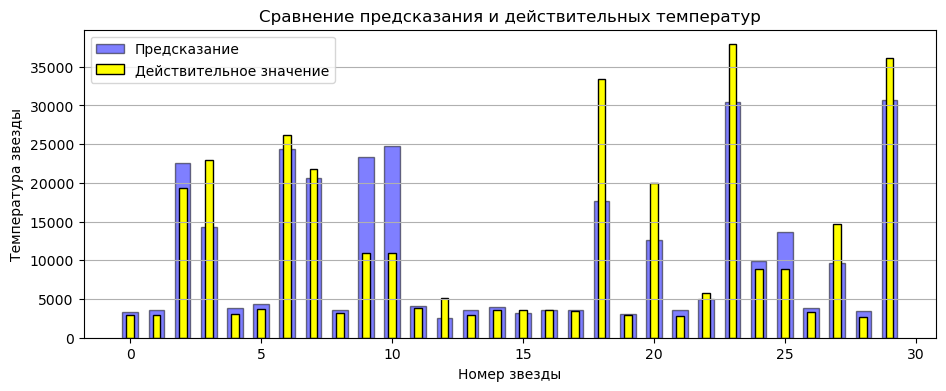

In [91]:
final_bar(test_preds.data.flatten())

Библиотека Optuna не дала существенное улучшение метрики RMSE. Вероятная причина - малое количество данных или плохое их качество. Как было видно из графика цветов в зависимости от температуры, некоторые не соответствуют их реальным интервалам распределения.

Результат улучшения модели позволил преодолеть минимальный порог требования заказчика.

Анализируя график сопоставления предсказанных и фактических значений температур звёзд видно, что нейронная сеть аналогично базовой моделе успешно предсказывает температуру для некоторых звёзд с высокой точностью и плохо для звезд под номерами 3, 9, 10, 18 и 23.

### Предсказания моделью XGBoost

В дополнение к разделу "Улучшение сети" хотелось бы решить задачу с помощью машинного обучения методом градиентного бустинга. Таким образом можно будет сравнить качество предсказания с типичными моделями машинного обучения.

В качестве подопытной модели возьмем XGBoost, которая предсказывает быстро и качественно. Аналогично нейронной сети подберем для модели гиперпараметры с помощью Optuna. Для корректного выбора модели будем использовать кросс-валидацию. Забегая вперед по результатам на каждом фолде, можно утверждать, что это правильное решение. Для нейросети не использовалась кросс-валидация по причине ручного подбора выборок по типу звезды.

Разделим данные на фичи и целевой признак.

In [92]:
data_features = data.drop('temperature', axis=1)
data_target = data['temperature']

Создаем функцию обучения и вывода результатов кроссвалидации.

In [93]:
def objective(trial: optuna.Trial):
    
    
    model_type = trial.suggest_categorical("model_type", ["XGBoost"])
    
    if model_type == "XGBoost":
        xgboost_params = {
            'tree_method':'gpu_hist',  
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.02, log=True),
            'n_estimators': 1000,
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
            'random_state': trial.suggest_categorical('random_state', [2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        
        model = XGBRegressor(**xgboost_params)
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), columns_numeric),
                ("category", TargetEncoder(), columns_category)
            ]
        )
       
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    cv = KFold(n_splits=4)
    
    score = cross_val_score(estimator=pipe,
                            X=data_features,
                            y=data_target,
                            scoring='neg_root_mean_squared_error',
                            cv=cv)
    
    trial.set_user_attr("model", pipe)
    trial.set_user_attr("cross_val_score", score)
    
    rmse = score.mean()
    return rmse 

In [94]:
# Определение Callback для вывода метрик
def custom_callback(study: optuna.Study, trial: optuna.Trial):
    trial.user_attrs["cross_val_score"]
    score = trial.user_attrs["cross_val_score"]
    print(f"Trial {trial.number}: cross_val_score={score}")

Проводим обучение с использованием аналогичных сэмплира и прунера. Так как метрика кросс-валидации negativ RMSE, нам необходимо подбирать максимальный результат.

In [95]:
study = optuna.create_study(direction="maximize", 
                            sampler = TPESampler(seed=42),
                            pruner = optuna.pruners.HyperbandPruner(),
                            study_name=f"Pipeline_training_example_{dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
study.optimize(objective, n_trials=100, callbacks=[custom_callback])

[I 2023-12-06 11:05:43,749] A new study created in memory with name: Pipeline_training_example_2023-12-06_11-05-43
[I 2023-12-06 11:05:50,189] Trial 0 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.03148911647956861, 'alpha': 6.351221010640703, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.010572072866769694, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 137}. Best is trial 0 with value: -13888.78734956282.


Trial 0: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:05:56,969] Trial 1 finished with value: -9772.19534805468 and parameters: {'model_type': 'XGBoost', 'lambda': 1.382623217936987, 'alpha': 0.006290644294586149, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.012593333102215698, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 56}. Best is trial 1 with value: -9772.19534805468.


Trial 1: cross_val_score=[ -8969.34711078  -9228.41287328  -8905.66295973 -11985.35844843]


[I 2023-12-06 11:06:04,422] Trial 2 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 7.556810141274429, 'alpha': 1.2604664585649468, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.009102682068690582, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 213}. Best is trial 1 with value: -9772.19534805468.


Trial 2: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:06:15,543] Trial 3 finished with value: -4905.979950969442 and parameters: {'model_type': 'XGBoost', 'lambda': 0.8241925264876453, 'alpha': 1.2164139351417065, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015378664546330346, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 33}. Best is trial 3 with value: -4905.979950969442.


Trial 3: cross_val_score=[-3925.65671572 -4146.57228421 -4816.73835332 -6734.95245063]


[I 2023-12-06 11:06:23,068] Trial 4 finished with value: -9770.217986754664 and parameters: {'model_type': 'XGBoost', 'lambda': 0.0013357240411974098, 'alpha': 0.35127047262708466, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.016707184177862246, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 69}. Best is trial 3 with value: -4905.979950969442.


Trial 4: cross_val_score=[ -8975.9182457   -9242.24056513  -8899.36716901 -11963.34596718]


[I 2023-12-06 11:06:30,237] Trial 5 finished with value: -9774.19568664143 and parameters: {'model_type': 'XGBoost', 'lambda': 0.05110120656497164, 'alpha': 1.8709365688887358, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.010075908986968668, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 84}. Best is trial 3 with value: -4905.979950969442.


Trial 5: cross_val_score=[ -8991.57729931  -9244.38321938  -8896.93875606 -11963.88347182]


[I 2023-12-06 11:06:37,351] Trial 6 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 4.295992790539128, 'alpha': 0.009083381663660588, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.010733496248335651, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 194}. Best is trial 3 with value: -4905.979950969442.


Trial 6: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:06:44,735] Trial 7 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.004982711200081134, 'alpha': 0.5804314717414073, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.018202374000859608, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 234}. Best is trial 3 with value: -4905.979950969442.


Trial 7: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:06:52,232] Trial 8 finished with value: -9774.308570674002 and parameters: {'model_type': 'XGBoost', 'lambda': 0.3699359899959751, 'alpha': 0.0021705003488711127, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.010779026650661274, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 80}. Best is trial 3 with value: -4905.979950969442.


Trial 8: cross_val_score=[ -8992.52301654  -9244.60673313  -8896.84076965 -11963.26376338]


[I 2023-12-06 11:06:59,312] Trial 9 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.009461469059966109, 'alpha': 7.799059237255681, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.019173276406114017, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 256}. Best is trial 3 with value: -4905.979950969442.


Trial 9: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:07:20,551] Trial 10 finished with value: -4751.0701398622205 and parameters: {'model_type': 'XGBoost', 'lambda': 0.29506902678473124, 'alpha': 0.07821846444899158, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01504484418962939, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 5}. Best is trial 10 with value: -4751.0701398622205.


Trial 10: cross_val_score=[-3391.94455382 -5086.44236562 -4653.88454401 -5872.009096  ]


[I 2023-12-06 11:07:38,104] Trial 11 finished with value: -4639.672268923315 and parameters: {'model_type': 'XGBoost', 'lambda': 0.31356971313563664, 'alpha': 0.09518690493721538, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015153613676290275, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 11 with value: -4639.672268923315.


Trial 11: cross_val_score=[-3242.3855261  -4968.14579489 -4560.25835599 -5787.89939872]


[I 2023-12-06 11:07:53,356] Trial 12 finished with value: -4723.8313758716495 and parameters: {'model_type': 'XGBoost', 'lambda': 0.154976121593835, 'alpha': 0.04239207808035895, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014011433145497654, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 14}. Best is trial 11 with value: -4639.672268923315.


Trial 12: cross_val_score=[-3610.21869436 -4691.36816705 -4647.37661282 -5946.36202926]


[I 2023-12-06 11:08:00,716] Trial 13 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.12915629316911445, 'alpha': 0.07495849797769741, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.01391033759813773, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 299}. Best is trial 11 with value: -4639.672268923315.


Trial 13: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:08:08,237] Trial 14 finished with value: -9772.634294760628 and parameters: {'model_type': 'XGBoost', 'lambda': 0.11399654597808385, 'alpha': 0.03197550437602923, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.012999833744021218, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 121}. Best is trial 11 with value: -4639.672268923315.


Trial 14: cross_val_score=[ -8984.80809622  -9242.44755597  -8898.21370396 -11965.06782289]


[I 2023-12-06 11:08:29,516] Trial 15 finished with value: -4774.509242120987 and parameters: {'model_type': 'XGBoost', 'lambda': 0.7675800265524454, 'alpha': 0.15282726063969262, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.016821298779697385, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 6}. Best is trial 11 with value: -4639.672268923315.


Trial 15: cross_val_score=[-3068.09552642 -5229.58966811 -5118.89471082 -5681.45706313]


[I 2023-12-06 11:08:43,572] Trial 16 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.21158311932123522, 'alpha': 0.03375414353603287, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.019904908162650677, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 113}. Best is trial 11 with value: -4639.672268923315.


Trial 16: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:09:04,636] Trial 17 finished with value: -4945.0914084451815 and parameters: {'model_type': 'XGBoost', 'lambda': 0.048018879311455646, 'alpha': 0.01913836536945014, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.012483005044782268, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 36}. Best is trial 11 with value: -4639.672268923315.


Trial 17: cross_val_score=[-4040.15369938 -4437.7131989  -4574.45497322 -6728.04376229]


[I 2023-12-06 11:09:20,102] Trial 18 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 2.281166987382634, 'alpha': 0.0011635780174365194, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.008117304044796703, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 187}. Best is trial 11 with value: -4639.672268923315.


Trial 18: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:09:41,192] Trial 19 finished with value: -4878.9158277442075 and parameters: {'model_type': 'XGBoost', 'lambda': 0.47762130877836684, 'alpha': 0.16511336391386494, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.014203357266510756, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 34}. Best is trial 11 with value: -4639.672268923315.


Trial 19: cross_val_score=[-3851.91167174 -4258.95815901 -4773.29674017 -6631.49674006]


[I 2023-12-06 11:09:55,731] Trial 20 finished with value: -9773.637863395275 and parameters: {'model_type': 'XGBoost', 'lambda': 2.213677352058041, 'alpha': 0.05580073998176011, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.016640774843032637, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 164}. Best is trial 11 with value: -4639.672268923315.


Trial 20: cross_val_score=[ -8983.71680893  -9242.44575251  -8896.11517678 -11972.27371535]


[I 2023-12-06 11:10:50,665] Trial 21 finished with value: -4868.992007641441 and parameters: {'model_type': 'XGBoost', 'lambda': 0.23231148662065335, 'alpha': 0.0809281633417025, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01506613339881421, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 3}. Best is trial 11 with value: -4639.672268923315.


Trial 21: cross_val_score=[-3691.2051736  -5050.14158548 -4375.65095982 -6358.97031167]


[I 2023-12-06 11:11:22,098] Trial 22 finished with value: -4632.751758830389 and parameters: {'model_type': 'XGBoost', 'lambda': 0.34756003983773737, 'alpha': 0.19381873659937163, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014983803778696769, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 11}. Best is trial 22 with value: -4632.751758830389.


Trial 22: cross_val_score=[-3251.39609098 -4875.47959276 -4562.23554997 -5841.89580161]


[I 2023-12-06 11:11:39,486] Trial 23 finished with value: -5665.469264855094 and parameters: {'model_type': 'XGBoost', 'lambda': 0.6394521753153621, 'alpha': 0.35480748170553833, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.013956169067418344, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 47}. Best is trial 22 with value: -4632.751758830389.


Trial 23: cross_val_score=[-4907.12075405 -4967.98303193 -5549.77957902 -7236.99369443]


[I 2023-12-06 11:11:51,747] Trial 24 finished with value: -9774.664154893795 and parameters: {'model_type': 'XGBoost', 'lambda': 0.11052342197927265, 'alpha': 0.18174559936657309, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.011828154163129661, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 100}. Best is trial 22 with value: -4632.751758830389.


Trial 24: cross_val_score=[ -8998.33276627  -9248.00369597  -8895.75506699 -11956.56509035]


[I 2023-12-06 11:12:12,047] Trial 25 finished with value: -4918.865463577381 and parameters: {'model_type': 'XGBoost', 'lambda': 0.2339645413785659, 'alpha': 0.019851381063929176, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.015947154297145914, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 20}. Best is trial 22 with value: -4632.751758830389.


Trial 25: cross_val_score=[-3583.06681278 -4165.86657589 -5207.37650864 -6719.151957  ]


[I 2023-12-06 11:12:25,787] Trial 26 finished with value: -9775.661404932582 and parameters: {'model_type': 'XGBoost', 'lambda': 0.9713653257656234, 'alpha': 0.12491508272675757, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.017973759910892007, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 61}. Best is trial 22 with value: -4632.751758830389.


Trial 26: cross_val_score=[ -8985.11917952  -9229.39969468  -8905.95437447 -11982.17237106]


[I 2023-12-06 11:12:50,138] Trial 27 finished with value: -4966.704396326357 and parameters: {'model_type': 'XGBoost', 'lambda': 0.4702572566470318, 'alpha': 0.04379277007235624, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.013492482358237759, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 23}. Best is trial 22 with value: -4632.751758830389.


Trial 27: cross_val_score=[-3549.20577726 -4198.95451241 -5315.72909439 -6802.92820124]


[I 2023-12-06 11:13:04,201] Trial 28 finished with value: -9774.704820206613 and parameters: {'model_type': 'XGBoost', 'lambda': 0.07062706686916531, 'alpha': 0.33669591351000616, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014511744696031326, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 95}. Best is trial 22 with value: -4632.751758830389.


Trial 28: cross_val_score=[ -8996.1381322   -9245.27274211  -8896.58431952 -11960.824087  ]


[I 2023-12-06 11:13:17,384] Trial 29 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.03628294690625198, 'alpha': 4.266885477872881, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.015505240880439416, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 155}. Best is trial 22 with value: -4632.751758830389.


Trial 29: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:13:31,162] Trial 30 finished with value: -9771.66829216832 and parameters: {'model_type': 'XGBoost', 'lambda': 0.017546264076352746, 'alpha': 0.20337020579771936, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.013409420363169357, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 128}. Best is trial 22 with value: -4632.751758830389.


Trial 30: cross_val_score=[ -8959.99951022  -9231.23434322  -8904.20676526 -11991.23254998]


[I 2023-12-06 11:14:12,644] Trial 31 finished with value: -4737.006781900958 and parameters: {'model_type': 'XGBoost', 'lambda': 0.22039647131944298, 'alpha': 0.08376317738085336, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01465961973661721, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 5}. Best is trial 22 with value: -4632.751758830389.


Trial 31: cross_val_score=[-3412.30125746 -5030.61282968 -4681.15717611 -5823.95586435]


[I 2023-12-06 11:15:15,828] Trial 32 finished with value: -4713.669126730993 and parameters: {'model_type': 'XGBoost', 'lambda': 0.15901905714960574, 'alpha': 0.10001556631177239, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014482918589647408, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 22 with value: -4632.751758830389.


Trial 32: cross_val_score=[-3600.6698665  -5114.9537573  -4319.34508539 -5819.70779774]


[I 2023-12-06 11:15:30,674] Trial 33 finished with value: -6272.5854265818925 and parameters: {'model_type': 'XGBoost', 'lambda': 0.07877735509137725, 'alpha': 0.10831706741010837, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.015890194019935817, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 54}. Best is trial 22 with value: -4632.751758830389.


Trial 33: cross_val_score=[-4895.77702308 -5099.62434444 -6634.14091933 -8460.79941948]


[I 2023-12-06 11:15:51,089] Trial 34 finished with value: -5237.319645270161 and parameters: {'model_type': 'XGBoost', 'lambda': 0.12394310647721625, 'alpha': 0.043389435764398986, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.012638025937490653, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 25}. Best is trial 22 with value: -4632.751758830389.


Trial 34: cross_val_score=[-4352.9535972  -4058.49554571 -5183.40488417 -7354.42455401]


[I 2023-12-06 11:16:07,123] Trial 35 finished with value: -5413.296324962433 and parameters: {'model_type': 'XGBoost', 'lambda': 0.5283379518997281, 'alpha': 0.023398095308171312, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01456736591690944, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 39}. Best is trial 22 with value: -4632.751758830389.


Trial 35: cross_val_score=[-4581.77397037 -4835.05153528 -5233.72377866 -7002.63601554]


[I 2023-12-06 11:16:19,142] Trial 36 finished with value: -9757.335192492865 and parameters: {'model_type': 'XGBoost', 'lambda': 1.2153522735484288, 'alpha': 0.01198316134356364, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.013614781322384755, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 71}. Best is trial 22 with value: -4632.751758830389.


Trial 36: cross_val_score=[ -8963.01563231  -9237.36421479  -8892.60882882 -11936.35209406]


[I 2023-12-06 11:16:42,474] Trial 37 finished with value: -4812.402777713025 and parameters: {'model_type': 'XGBoost', 'lambda': 0.17045008168207584, 'alpha': 0.05663681391753578, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.015877371880980106, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 18}. Best is trial 22 with value: -4632.751758830389.


Trial 37: cross_val_score=[-4111.67875884 -4360.04657843 -5069.20477066 -5708.68100292]


[I 2023-12-06 11:16:59,209] Trial 38 finished with value: -6097.935436450948 and parameters: {'model_type': 'XGBoost', 'lambda': 0.39473113089945866, 'alpha': 0.703942118533322, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.011975097858785316, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 51}. Best is trial 22 with value: -4632.751758830389.


Trial 38: cross_val_score=[-5007.01289579 -5103.47896895 -5963.5930654  -8317.65681566]


[I 2023-12-06 11:17:24,798] Trial 39 finished with value: -4767.875758669603 and parameters: {'model_type': 'XGBoost', 'lambda': 0.07406351233959388, 'alpha': 0.2800987362271731, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.015012269640561965, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 17}. Best is trial 22 with value: -4632.751758830389.


Trial 39: cross_val_score=[-3811.0152188  -4609.74446169 -4938.76675548 -5711.97659871]


[I 2023-12-06 11:17:40,723] Trial 40 finished with value: -6936.135635399591 and parameters: {'model_type': 'XGBoost', 'lambda': 0.3537753087522394, 'alpha': 0.11703009799471534, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.014267912634194928, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 68}. Best is trial 22 with value: -4632.751758830389.


Trial 40: cross_val_score=[-5848.7789376  -5197.48357841 -7441.55924507 -9256.72078052]


[I 2023-12-06 11:18:39,666] Trial 41 finished with value: -4806.587982187538 and parameters: {'model_type': 'XGBoost', 'lambda': 0.15739733273075499, 'alpha': 0.08562860851122792, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014839316138102236, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 2}. Best is trial 22 with value: -4632.751758830389.


Trial 41: cross_val_score=[-3704.90880562 -5025.67997855 -4177.38426183 -6318.37888276]


[I 2023-12-06 11:18:56,685] Trial 42 finished with value: -5191.736257784699 and parameters: {'model_type': 'XGBoost', 'lambda': 0.2544333345027169, 'alpha': 0.2167787511333673, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.013202715356039769, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 42}. Best is trial 22 with value: -4632.751758830389.


Trial 42: cross_val_score=[-4295.94565422 -4681.74310085 -4936.69691533 -6852.55936074]


[I 2023-12-06 11:19:22,617] Trial 43 finished with value: -4727.8909664787 and parameters: {'model_type': 'XGBoost', 'lambda': 0.17641060063333003, 'alpha': 0.055896768246675305, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014255362963538389, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 15}. Best is trial 22 with value: -4632.751758830389.


Trial 43: cross_val_score=[-3710.4568551  -4591.53015189 -4652.02104455 -5957.55581437]


[I 2023-12-06 11:19:43,213] Trial 44 finished with value: -4956.4141628344705 and parameters: {'model_type': 'XGBoost', 'lambda': 0.716757927182107, 'alpha': 0.055256940586624205, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.013961838975992368, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 21}. Best is trial 22 with value: -4632.751758830389.


Trial 44: cross_val_score=[-3729.83302768 -4184.61250431 -5170.22949742 -6740.98162192]


[I 2023-12-06 11:20:01,029] Trial 45 finished with value: -5016.353416026464 and parameters: {'model_type': 'XGBoost', 'lambda': 0.14339341375926812, 'alpha': 0.029655345026719925, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.012955816086129602, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 34}. Best is trial 22 with value: -4632.751758830389.


Trial 45: cross_val_score=[-4421.86413116 -4337.0660622  -4552.34888181 -6754.13458894]


[I 2023-12-06 11:20:13,432] Trial 46 finished with value: -9767.770659866375 and parameters: {'model_type': 'XGBoost', 'lambda': 0.3141096761537244, 'alpha': 0.4785739155181579, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.015381591238752006, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 83}. Best is trial 22 with value: -4632.751758830389.


Trial 46: cross_val_score=[ -8959.55087858  -9239.84333915  -8899.19920052 -11972.48922121]


[I 2023-12-06 11:20:37,864] Trial 47 finished with value: -4726.9284220864365 and parameters: {'model_type': 'XGBoost', 'lambda': 0.08703456442472908, 'alpha': 0.12913444066683832, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016377112740960514, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 15}. Best is trial 22 with value: -4632.751758830389.


Trial 47: cross_val_score=[-3751.23922462 -4621.56568623 -4621.30183275 -5913.60694475]


[I 2023-12-06 11:20:59,161] Trial 48 finished with value: -5037.038552047043 and parameters: {'model_type': 'XGBoost', 'lambda': 0.0848240357638172, 'alpha': 0.1101459621994825, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.017218057484687223, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 22 with value: -4632.751758830389.


Trial 48: cross_val_score=[-4630.04775456 -4397.94943892 -4010.44451791 -7109.7124968 ]


[I 2023-12-06 11:21:07,315] Trial 49 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.053127531148045706, 'alpha': 0.23845309187991334, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016259028542642794, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 259}. Best is trial 22 with value: -4632.751758830389.


Trial 49: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:21:17,331] Trial 50 finished with value: -6682.80655044818 and parameters: {'model_type': 'XGBoost', 'lambda': 0.027351387034245243, 'alpha': 0.16985603153413756, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017304558726518354, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 62}. Best is trial 22 with value: -4632.751758830389.


Trial 50: cross_val_score=[-5900.455666   -5555.95853535 -5883.22520596 -9391.58679448]


[I 2023-12-06 11:21:33,063] Trial 51 finished with value: -4721.409358863286 and parameters: {'model_type': 'XGBoost', 'lambda': 0.16337770736553966, 'alpha': 0.13731024122684626, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015135029272609651, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 15}. Best is trial 22 with value: -4632.751758830389.


Trial 51: cross_val_score=[-3710.77454309 -4603.63317897 -4644.3924519  -5926.83726149]


[I 2023-12-06 11:21:45,480] Trial 52 finished with value: -4984.975982632625 and parameters: {'model_type': 'XGBoost', 'lambda': 0.30301962879276373, 'alpha': 0.14535990187521924, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01663880537963132, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 29}. Best is trial 22 with value: -4632.751758830389.


Trial 52: cross_val_score=[-3779.75916908 -4029.73065784 -5191.43110469 -6938.98299892]


[I 2023-12-06 11:22:01,104] Trial 53 finished with value: -4698.45046558463 and parameters: {'model_type': 'XGBoost', 'lambda': 0.12393178166765516, 'alpha': 0.12330477771439471, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015285652770199073, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 13}. Best is trial 22 with value: -4632.751758830389.


Trial 53: cross_val_score=[-3470.02354086 -4807.09773204 -4576.5125296  -5940.16805984]


[I 2023-12-06 11:22:11,518] Trial 54 finished with value: -5698.5958796080595 and parameters: {'model_type': 'XGBoost', 'lambda': 0.1309434338519352, 'alpha': 0.07179419773485987, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015392126405818768, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 48}. Best is trial 22 with value: -4632.751758830389.


Trial 54: cross_val_score=[-4817.09176772 -4958.55139291 -5629.71068021 -7389.0296776 ]


[I 2023-12-06 11:22:23,537] Trial 55 finished with value: -4977.451513985584 and parameters: {'model_type': 'XGBoost', 'lambda': 0.5261438746258214, 'alpha': 0.28988602667335756, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.015001759443359994, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 32}. Best is trial 22 with value: -4632.751758830389.


Trial 55: cross_val_score=[-3811.79870116 -4157.27419485 -5076.45328074 -6864.27987919]


[I 2023-12-06 11:22:38,073] Trial 56 finished with value: -4737.016567467926 and parameters: {'model_type': 'XGBoost', 'lambda': 0.34790313830149333, 'alpha': 0.4554558744736014, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.013908239807099768, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 11}. Best is trial 22 with value: -4632.751758830389.


Trial 56: cross_val_score=[-3737.96198801 -4435.87346393 -4793.83004301 -5980.40077492]


[I 2023-12-06 11:22:48,676] Trial 57 finished with value: -5091.041799277558 and parameters: {'model_type': 'XGBoost', 'lambda': 0.18956782425914734, 'alpha': 0.10083967629179426, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.015384536685955767, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 43}. Best is trial 22 with value: -4632.751758830389.


Trial 57: cross_val_score=[-4020.75738435 -4584.7460515  -4922.15203304 -6836.51172821]


[I 2023-12-06 11:23:00,804] Trial 58 finished with value: -4955.775576762972 and parameters: {'model_type': 'XGBoost', 'lambda': 0.1264713719511976, 'alpha': 0.16806572883924267, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014466868591910272, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 29}. Best is trial 22 with value: -4632.751758830389.


Trial 58: cross_val_score=[-3409.20047863 -4096.52610835 -5364.91152288 -6952.4641972 ]


[I 2023-12-06 11:23:16,820] Trial 59 finished with value: -4619.311890320716 and parameters: {'model_type': 'XGBoost', 'lambda': 0.10226661012838406, 'alpha': 0.7905629859177375, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015877200977889673, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 11}. Best is trial 59 with value: -4619.311890320716.


Trial 59: cross_val_score=[-3252.57630825 -4874.30268722 -4574.85757974 -5775.51098607]


[I 2023-12-06 11:23:33,038] Trial 60 finished with value: -4658.813137300819 and parameters: {'model_type': 'XGBoost', 'lambda': 0.26568842839925966, 'alpha': 1.087130595787827, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015721096870879775, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 59 with value: -4619.311890320716.


Trial 60: cross_val_score=[-3280.77093277 -4967.15510033 -4609.38541277 -5777.94110333]


[I 2023-12-06 11:23:49,397] Trial 61 finished with value: -4666.352544319401 and parameters: {'model_type': 'XGBoost', 'lambda': 0.2964781722053017, 'alpha': 0.8666961504024306, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015890417126968898, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 8}. Best is trial 59 with value: -4619.311890320716.


Trial 61: cross_val_score=[-3275.97423699 -5017.74902857 -4591.47919584 -5780.20771588]


[I 2023-12-06 11:24:06,382] Trial 62 finished with value: -4853.499233390043 and parameters: {'model_type': 'XGBoost', 'lambda': 0.2694239163517329, 'alpha': 0.8687674328563197, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015991811413824993, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 2}. Best is trial 59 with value: -4619.311890320716.


Trial 62: cross_val_score=[-3501.33446149 -5025.38710374 -4485.19605556 -6402.07931277]


[I 2023-12-06 11:24:22,527] Trial 63 finished with value: -4656.926171281893 and parameters: {'model_type': 'XGBoost', 'lambda': 0.6843541626318369, 'alpha': 1.2679530266192958, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015727501817143455, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 59 with value: -4619.311890320716.


Trial 63: cross_val_score=[-3307.09232885 -4900.73992044 -4602.96900189 -5816.90343395]


[I 2023-12-06 11:24:33,913] Trial 64 finished with value: -4917.611285162453 and parameters: {'model_type': 'XGBoost', 'lambda': 0.9713751570981691, 'alpha': 1.811968497262887, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017286414590801186, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 26}. Best is trial 59 with value: -4619.311890320716.


Trial 64: cross_val_score=[-3887.48969259 -4292.03599064 -4821.30158846 -6669.61786896]


[I 2023-12-06 11:24:41,908] Trial 65 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.46667096577247347, 'alpha': 1.0836158968786778, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.016785363157433127, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 203}. Best is trial 59 with value: -4619.311890320716.


Trial 65: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:24:58,151] Trial 66 finished with value: -4670.573471726828 and parameters: {'model_type': 'XGBoost', 'lambda': 0.6165262566616811, 'alpha': 0.6021926700433079, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016012514332712446, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 59 with value: -4619.311890320716.


Trial 66: cross_val_score=[-3312.06460274 -4931.98061787 -4634.62885046 -5803.61981583]


[I 2023-12-06 11:25:08,453] Trial 67 finished with value: -5705.794270837441 and parameters: {'model_type': 'XGBoost', 'lambda': 0.6775028096895342, 'alpha': 1.3532703871189988, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.015739657408456384, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 42}. Best is trial 59 with value: -4619.311890320716.


Trial 67: cross_val_score=[-4864.44861624 -5004.03594186 -5638.25223463 -7316.44029062]


[I 2023-12-06 11:25:24,443] Trial 68 finished with value: -4731.770462765521 and parameters: {'model_type': 'XGBoost', 'lambda': 1.7240498368177122, 'alpha': 0.7249324458271863, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018004113964261038, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 59 with value: -4619.311890320716.


Trial 68: cross_val_score=[-3435.54650913 -4982.98359016 -4865.90789893 -5642.64385285]


[I 2023-12-06 11:25:32,396] Trial 69 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.602595663475013, 'alpha': 0.4918580415577088, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016301349614784598, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 176}. Best is trial 59 with value: -4619.311890320716.


Trial 69: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:25:40,306] Trial 70 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.9485182989460488, 'alpha': 2.5223063397845706, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.015967999331049143, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 234}. Best is trial 59 with value: -4619.311890320716.


Trial 70: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:25:56,667] Trial 71 finished with value: -4650.132108214805 and parameters: {'model_type': 'XGBoost', 'lambda': 0.41769069522923424, 'alpha': 0.6237914053832315, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015612479943380548, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 59 with value: -4619.311890320716.


Trial 71: cross_val_score=[-3290.11425583 -4902.18067059 -4616.52339474 -5791.7101117 ]


[I 2023-12-06 11:26:09,492] Trial 72 finished with value: -4942.292561543402 and parameters: {'model_type': 'XGBoost', 'lambda': 0.40248954784318364, 'alpha': 0.6175107584182662, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015655574043066663, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 26}. Best is trial 59 with value: -4619.311890320716.


Trial 72: cross_val_score=[-3623.41764906 -4104.61032062 -5239.06020226 -6802.08207423]


[I 2023-12-06 11:26:25,704] Trial 73 finished with value: -4647.168118623276 and parameters: {'model_type': 'XGBoost', 'lambda': 0.23943057467418943, 'alpha': 0.7859418049901677, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016914140958151174, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 59 with value: -4619.311890320716.


Trial 73: cross_val_score=[-3262.58401763 -4970.48223727 -4619.50274289 -5736.1034767 ]


[I 2023-12-06 11:26:33,732] Trial 74 finished with value: -12710.252317106584 and parameters: {'model_type': 'XGBoost', 'lambda': 0.22191893441495916, 'alpha': 0.8873703169056255, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.017026809239826187, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 141}. Best is trial 59 with value: -4619.311890320716.


Trial 74: cross_val_score=[ -8966.4947633  -11870.21773697 -13078.4368687  -16925.85989945]


[I 2023-12-06 11:26:44,053] Trial 75 finished with value: -6008.790653795853 and parameters: {'model_type': 'XGBoost', 'lambda': 0.2789309278694607, 'alpha': 1.3314212285539848, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.017730731439520916, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 56}. Best is trial 59 with value: -4619.311890320716.


Trial 75: cross_val_score=[-4822.98357708 -5024.55126369 -5758.46501253 -8429.16276188]


[I 2023-12-06 11:26:55,599] Trial 76 finished with value: -4862.452623076844 and parameters: {'model_type': 'XGBoost', 'lambda': 0.4059191929176195, 'alpha': 0.38107230410489573, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014753523005680393, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 35}. Best is trial 59 with value: -4619.311890320716.


Trial 76: cross_val_score=[-4083.32377643 -4272.95875142 -4438.07243742 -6655.45552703]


[I 2023-12-06 11:27:15,455] Trial 77 finished with value: -4653.53189246136 and parameters: {'model_type': 'XGBoost', 'lambda': 0.23507968671860885, 'alpha': 1.0177006800122872, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01652016448762883, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 8}. Best is trial 59 with value: -4619.311890320716.


Trial 77: cross_val_score=[-3234.07417276 -5003.56273955 -4635.1826902  -5741.30796734]


[I 2023-12-06 11:27:29,325] Trial 78 finished with value: -4755.151843130744 and parameters: {'model_type': 'XGBoost', 'lambda': 0.21197704004469434, 'alpha': 1.8726503637706529, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.018750219131643254, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 22}. Best is trial 59 with value: -4619.311890320716.


Trial 78: cross_val_score=[-3735.90685372 -4188.61928543 -4989.71101088 -6106.37022249]


[I 2023-12-06 11:27:37,070] Trial 79 finished with value: -9774.306425751838 and parameters: {'model_type': 'XGBoost', 'lambda': 0.09927568253793312, 'alpha': 1.1087273223447318, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.016549684239435775, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 74}. Best is trial 59 with value: -4619.311890320716.


Trial 79: cross_val_score=[ -9001.63267168  -9249.19951263  -8895.31731281 -11951.07620589]


[I 2023-12-06 11:27:44,974] Trial 80 finished with value: -13888.78734956282 and parameters: {'model_type': 'XGBoost', 'lambda': 0.8027333007355402, 'alpha': 0.37792747885664635, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01765974263580822, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 300}. Best is trial 59 with value: -4619.311890320716.


Trial 80: cross_val_score=[-10114.44590446 -13046.29816781 -14313.08152996 -18081.32379602]


[I 2023-12-06 11:27:58,754] Trial 81 finished with value: -4776.043143583127 and parameters: {'model_type': 'XGBoost', 'lambda': 0.3022357625704344, 'alpha': 0.7983467136352665, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01558745761406379, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 22}. Best is trial 59 with value: -4619.311890320716.


Trial 81: cross_val_score=[-3622.74730302 -4231.207341   -5027.79580553 -6222.42212479]


[I 2023-12-06 11:28:17,192] Trial 82 finished with value: -4667.3773177237545 and parameters: {'model_type': 'XGBoost', 'lambda': 0.447667168596384, 'alpha': 0.9608048729779632, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016868292831370087, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 59 with value: -4619.311890320716.


Trial 82: cross_val_score=[-3290.35381446 -4942.33309278 -4625.47479437 -5811.34756929]


[I 2023-12-06 11:28:33,249] Trial 83 finished with value: -4706.403723075311 and parameters: {'model_type': 'XGBoost', 'lambda': 0.25061337740526, 'alpha': 0.6737312249025789, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01624451289222523, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 59 with value: -4619.311890320716.


Trial 83: cross_val_score=[-3272.86178912 -5124.76184191 -4532.35807664 -5895.63318463]


[I 2023-12-06 11:28:52,400] Trial 84 finished with value: -4652.635279430806 and parameters: {'model_type': 'XGBoost', 'lambda': 0.36266123176300796, 'alpha': 0.5124993639062554, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01645277437255383, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 59 with value: -4619.311890320716.


Trial 84: cross_val_score=[-3265.87270879 -4971.74140935 -4610.1311537  -5762.79584587]


[I 2023-12-06 11:29:04,260] Trial 85 finished with value: -4893.8102218737595 and parameters: {'model_type': 'XGBoost', 'lambda': 0.19234235685244958, 'alpha': 0.5452692302594525, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016675765395505672, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 33}. Best is trial 59 with value: -4619.311890320716.


Trial 85: cross_val_score=[-3928.62856475 -4121.08583803 -4807.66041143 -6717.86607328]


[I 2023-12-06 11:29:18,162] Trial 86 finished with value: -4754.877830813263 and parameters: {'model_type': 'XGBoost', 'lambda': 0.3715049264798972, 'alpha': 0.4679174310652846, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.014843324671211775, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 18}. Best is trial 59 with value: -4619.311890320716.


Trial 86: cross_val_score=[-3675.46345543 -4233.05063146 -4956.75202271 -6154.24521365]


[I 2023-12-06 11:29:29,174] Trial 87 finished with value: -4887.021619015944 and parameters: {'model_type': 'XGBoost', 'lambda': 0.5206146987027804, 'alpha': 0.2829659268646325, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016387118647916206, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 37}. Best is trial 59 with value: -4619.311890320716.


Trial 87: cross_val_score=[-4013.35703764 -4355.15251684 -4460.91137192 -6718.66554966]


[I 2023-12-06 11:29:49,566] Trial 88 finished with value: -4686.534300215318 and parameters: {'model_type': 'XGBoost', 'lambda': 0.3606251836068647, 'alpha': 0.6279622509397654, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015162657545450597, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 7}. Best is trial 59 with value: -4619.311890320716.


Trial 88: cross_val_score=[-3282.94687861 -5030.09619949 -4618.42273254 -5814.67139022]


[I 2023-12-06 11:30:03,629] Trial 89 finished with value: -4829.876931682633 and parameters: {'model_type': 'XGBoost', 'lambda': 0.21418630191035154, 'alpha': 1.1178022368229295, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.017057650771260927, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 26}. Best is trial 59 with value: -4619.311890320716.


Trial 89: cross_val_score=[-3914.96208659 -4180.03972169 -5102.83062037 -6121.67529808]


[I 2023-12-06 11:30:18,767] Trial 90 finished with value: -4784.284438720964 and parameters: {'model_type': 'XGBoost', 'lambda': 0.5673362638352976, 'alpha': 1.425199788667038, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.015600737991696083, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 18}. Best is trial 59 with value: -4619.311890320716.


Trial 90: cross_val_score=[-3994.57586281 -4328.30147681 -4934.94215493 -5879.31826033]


[I 2023-12-06 11:30:34,827] Trial 91 finished with value: -4657.302112543959 and parameters: {'model_type': 'XGBoost', 'lambda': 0.2706413846377675, 'alpha': 0.6920497074756687, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01578466259962953, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 59 with value: -4619.311890320716.


Trial 91: cross_val_score=[-3269.08800004 -4976.88270398 -4611.58693658 -5771.65080958]


[I 2023-12-06 11:30:53,709] Trial 92 finished with value: -4652.30033893132 and parameters: {'model_type': 'XGBoost', 'lambda': 0.15531665959012855, 'alpha': 0.7181088676108046, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016185093460039348, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 59 with value: -4619.311890320716.


Trial 92: cross_val_score=[-3264.6000948  -4996.32669285 -4634.56910635 -5713.70546173]


[I 2023-12-06 11:31:15,307] Trial 93 finished with value: -4725.161486853997 and parameters: {'model_type': 'XGBoost', 'lambda': 0.14809857724189288, 'alpha': 0.7312352918840263, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01615003894123478, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 59 with value: -4619.311890320716.


Trial 93: cross_val_score=[-3510.09427573 -5152.67088026 -4427.03212488 -5810.84866655]


[I 2023-12-06 11:31:30,455] Trial 94 finished with value: -4741.684157862754 and parameters: {'model_type': 'XGBoost', 'lambda': 0.1076291898241171, 'alpha': 0.5335838558416742, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.016534711961472902, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 16}. Best is trial 59 with value: -4619.311890320716.


Trial 94: cross_val_score=[-3867.60613184 -4491.47814994 -4676.90694112 -5930.74540855]


[I 2023-12-06 11:31:41,325] Trial 95 finished with value: -4947.069120692827 and parameters: {'model_type': 'XGBoost', 'lambda': 0.16770839113639371, 'alpha': 0.33606889673836415, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.017596569107347165, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 45}. Best is trial 59 with value: -4619.311890320716.


Trial 95: cross_val_score=[-3898.72567952 -4422.41940957 -4635.40349986 -6831.72789382]


[I 2023-12-06 11:31:53,738] Trial 96 finished with value: -5007.968990563895 and parameters: {'model_type': 'XGBoost', 'lambda': 0.44709427360357484, 'alpha': 0.40332963228500546, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.015232634448673328, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 30}. Best is trial 59 with value: -4619.311890320716.


Trial 96: cross_val_score=[-3799.45956751 -4089.74524076 -5204.32034321 -6938.35081077]


[I 2023-12-06 11:32:04,511] Trial 97 finished with value: -5146.667908504492 and parameters: {'model_type': 'XGBoost', 'lambda': 0.19035080044023603, 'alpha': 0.23532555626049878, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.016875595782841493, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 23}. Best is trial 59 with value: -4619.311890320716.


Trial 97: cross_val_score=[-4342.41819618 -4526.03303318 -4714.98508176 -7003.2353229 ]


[I 2023-12-06 11:32:12,548] Trial 98 finished with value: -9774.262251719761 and parameters: {'model_type': 'XGBoost', 'lambda': 0.23604151978900986, 'alpha': 0.7227958998931211, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.017345680105915633, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 99}. Best is trial 59 with value: -4619.311890320716.


Trial 98: cross_val_score=[ -9002.09156916  -9249.33093958  -8895.27871915 -11950.34777898]


[I 2023-12-06 11:32:30,506] Trial 99 finished with value: -4716.296095884592 and parameters: {'model_type': 'XGBoost', 'lambda': 0.331330281308689, 'alpha': 0.9515811505369083, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.018372392324601024, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 59 with value: -4619.311890320716.


Trial 99: cross_val_score=[-3627.48496978 -4848.39357176 -4283.16571789 -6106.14012412]


**Важное замечание:** кросс-валидация проходит на 4 фолдах. Метрика RMSE отличается для каждого фолд, в особенности на первом. Для модели с наилучшими гиперпараметрами RMSE для первого фолда составляет **3 252** К, в то время как для остальных от 4 575 до 5 776 К. Такой результат получается из-за неравномерного распределения данных звезд в малом количестве данных. Этот факт указывает на важность использования кросс-валидации при подборе параметров моделей!

Выводим лучшие гиперпараметры.

In [96]:
print("Параметры лучшей модели:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Параметры лучшей модели:
	model_type: XGBoost
	lambda: 0.10226661012838406
	alpha: 0.7905629859177375
	colsample_bytree: 0.6
	subsample: 0.7
	learning_rate: 0.015877200977889673
	max_depth: 5
	random_state: 2020
	min_child_weight: 11


Подготовим данные аналогично тому, как сделано в Optuna, вместо OHE будем использовать TargetEncoder, который не "раздувает" выборку и является решением лучше чем ОНЕ.

In [97]:
preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), columns_numeric),
                ("category", TargetEncoder(), columns_category)
            ]
        )

preprocessor.fit(features_train, target_train)

features_train_boost = preprocessor.transform(features_train)
features_test_boost = preprocessor.transform(features_test)

Проводим тестирование с выводом результата.

In [98]:
%%time

model_xgboost = XGBRegressor(reg_lambda=0.10226661012838406, alpha=0.7905629859177375, 
                             colsample_bytree=0.6, subsample=0.7, learning_rate=0.015877200977889673, 
                             max_depth=5, random_state=2020, min_child_weight=11, n_estimators=1000)
model_xgboost.fit(features_train_boost, target_train)
prediction_xgb = model_xgboost.predict(features_test_boost)
rmse_xgb = mean_squared_error(target_test, prediction_xgb, squared=False)
rmse_xgb

Wall time: 356 ms


5008.843932344368

Построим график сравнения "Факт-прогноз".

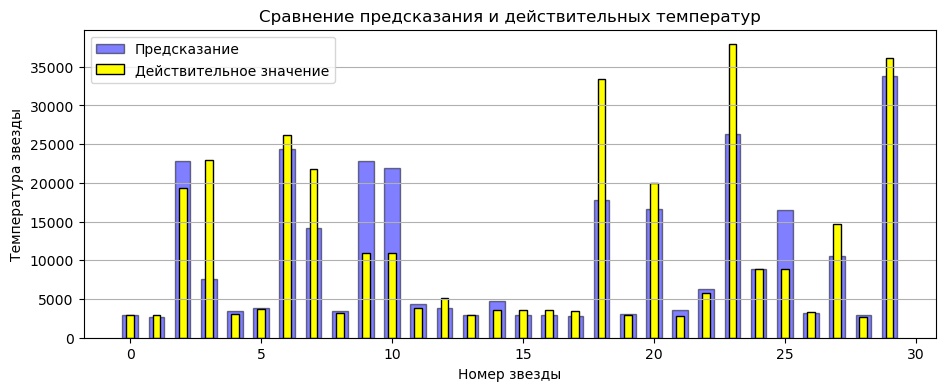

In [99]:
final_bar(prediction_xgb)

Модель XGBoost предсказывает с результатом хуже можделей нейронных сетей. Ошибка в 9 и 10 звезде аналогична. Стоит проверить эти звезды на отличие от типичных.

### Звезды с номером 9 и 10 

Выясним номера этих звезд, так как в тестовом целевом признаке звезды перемешаны.

In [100]:
target_test[9:11]

177    11000.0
227    10930.0
Name: temperature, dtype: float64

Выведем исходные признаки этих звезд.

In [101]:
data.loc[[177,227], :'color']

temperature  luminosity_relative  radius_relative  abs_magnitude  type  \
177      11000.0             170000.0           1779.0         -9.900     5   
227      10930.0             783930.0             25.0         -6.224     4   

    color  
177    bw  
227     b

#### Звезда под номером 227

Построим графики сравнения разных признаков с зависимостью от температуры. Отметим искомую звезду красным цветом

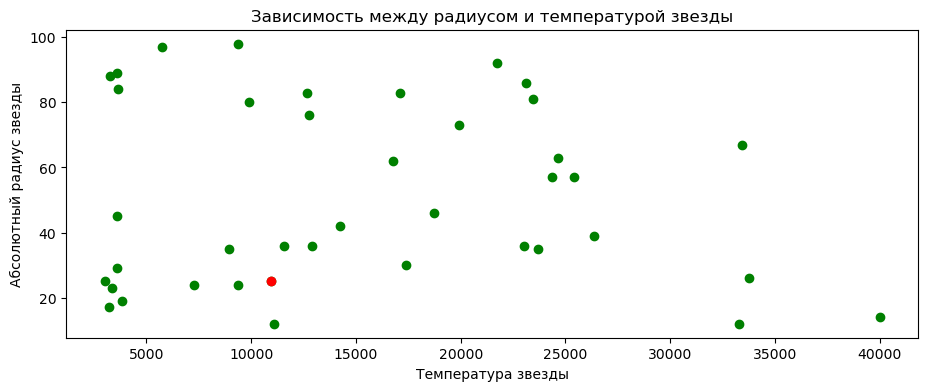

In [102]:
plt.figure(figsize = (11,4))
plt.plot(data[data['type']==4]['temperature'], 
         data[data['type']==4]['radius_relative'], 'go')
plt.plot(data.loc[[227]]['temperature'], 
         data.loc[[227]]['radius_relative'], 'ro')
plt.title('Зависимость между радиусом и температурой звезды')
plt.ylabel('Абсолютный радиус звезды')
plt.xlabel('Температура звезды')
plt.show()

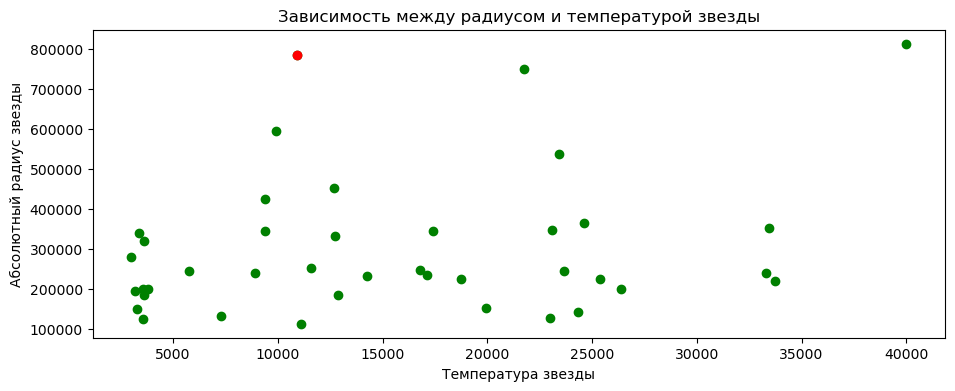

In [103]:
plt.figure(figsize = (11,4))
plt.plot(data[data['type']==4]['temperature'], 
         data[data['type']==4]['luminosity_relative'], 'go')
plt.plot(data.loc[[227]]['temperature'], 
         data.loc[[227]]['luminosity_relative'], 'ro')
plt.title('Зависимость между радиусом и температурой звезды')
plt.ylabel('Абсолютный радиус звезды')
plt.xlabel('Температура звезды')
plt.show()

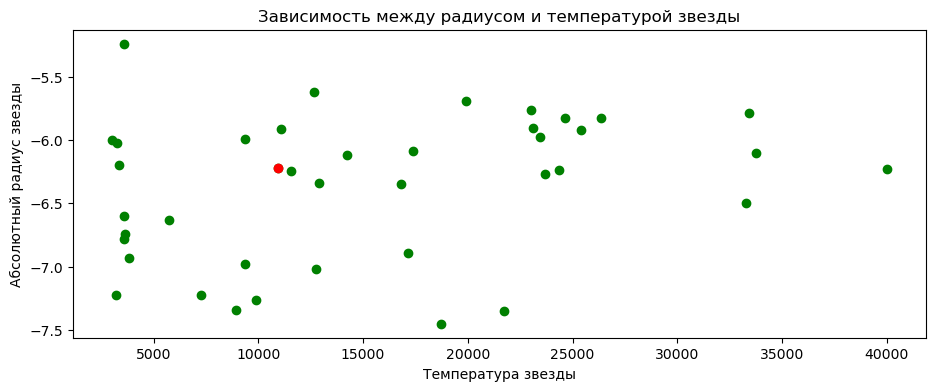

In [104]:
plt.figure(figsize = (11,4))
plt.plot(data[data['type']==4]['temperature'], 
         data[data['type']==4]['abs_magnitude'], 'go')
plt.plot(data.loc[[227]]['temperature'], 
         data.loc[[227]]['abs_magnitude'], 'ro')
plt.title('Зависимость между радиусом и температурой звезды')
plt.ylabel('Абсолютный радиус звезды')
plt.xlabel('Температура звезды')
plt.show()

Вывод: звезда является типичным представителем своего класса, они принимает среднее значение по каждому из своих признаков и не находится на границе интервалов признаков.

#### Звезда под номером 177

Аналогично предыдущей звезде построим графики зависимостей фичей к целевому признаку, выделив звезду красным цветом.

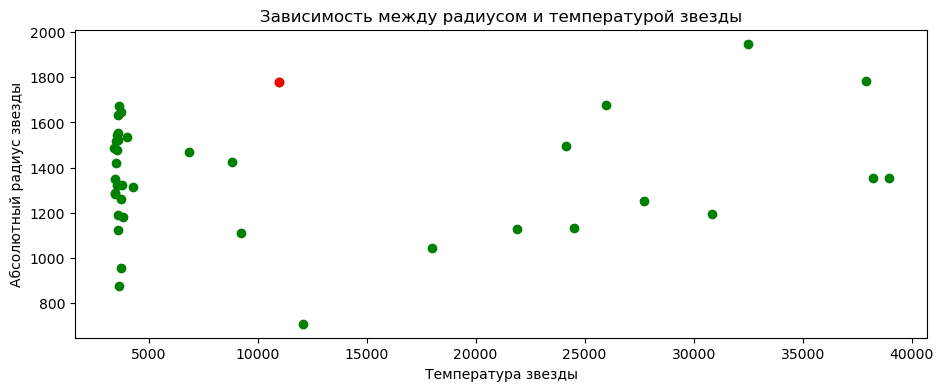

In [105]:
plt.figure(figsize = (11,4))
plt.plot(data[data['type']==5]['temperature'], 
         data[data['type']==5]['radius_relative'], 'go')
plt.plot(data.loc[[177]]['temperature'], 
         data.loc[[177]]['radius_relative'], 'ro')
plt.title('Зависимость между радиусом и температурой звезды')
plt.ylabel('Абсолютный радиус звезды')
plt.xlabel('Температура звезды')
plt.show()

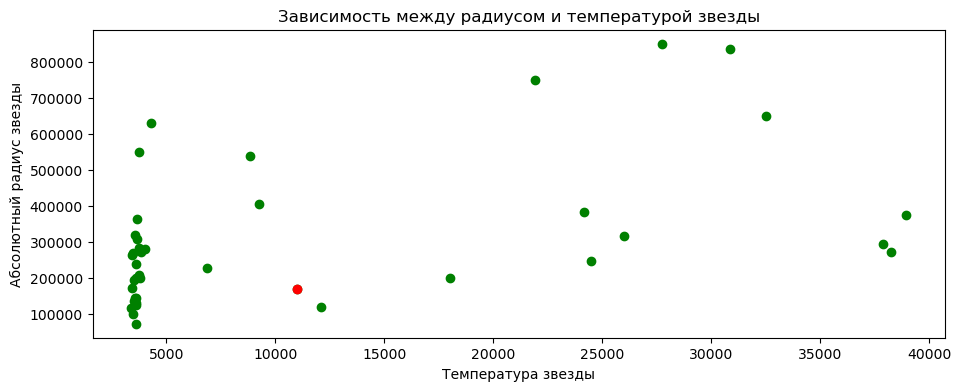

In [106]:
plt.figure(figsize = (11,4))
plt.plot(data[data['type']==5]['temperature'], 
         data[data['type']==5]['luminosity_relative'], 'go')
plt.plot(data.loc[[177]]['temperature'], 
         data.loc[[177]]['luminosity_relative'], 'ro')
plt.title('Зависимость между радиусом и температурой звезды')
plt.ylabel('Абсолютный радиус звезды')
plt.xlabel('Температура звезды')
plt.show()

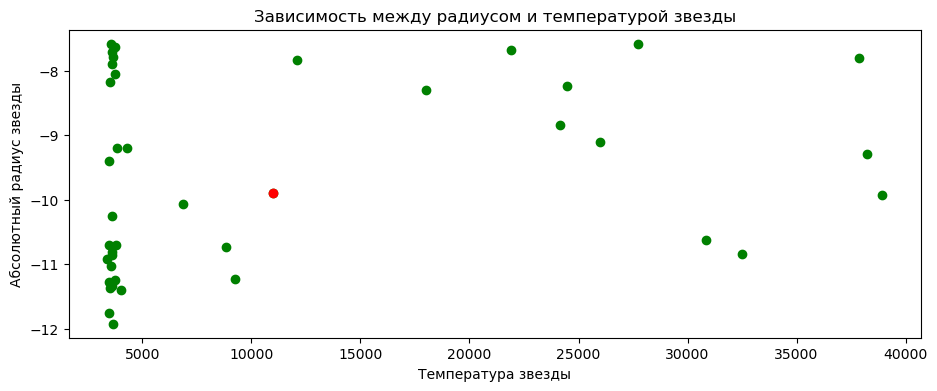

In [107]:
plt.figure(figsize = (11,4))
plt.plot(data[data['type']==5]['temperature'], 
         data[data['type']==5]['abs_magnitude'], 'go')
plt.plot(data.loc[[177]]['temperature'], 
         data.loc[[177]]['abs_magnitude'], 'ro')
plt.title('Зависимость между радиусом и температурой звезды')
plt.ylabel('Абсолютный радиус звезды')
plt.xlabel('Температура звезды')
plt.show()

**Вывод:** Звезда является типичным представителем своего класса. Находится вали от границ интервала изменения признака.

## Выводы

Для обсерватории "Небо на ладони" подготовлены 2 нейронной сети и модель градиентного бустинга для предсказывания температуру звезды на основе их характеристик с точностью **не хуже 5 000**. 

Проведен разведывательный анализ данных для каждого класса звезд. Выявлены закономерности для каждого из классов. В признак цвета звезды внесена корректировка исходя из названия. При этом, отмечено несоответствие цвета интервалам распределения температур. Данный факт ухудшил результат предсказаний моделей.

Исходные данные были подготовлены и разбиты на тренировочную и тестовую выборки. Тип данных изменен для корректного использования нейронными сетями и бустингом.

**Базовая модель нейронной сети** предсказывает температуру звезды с ошибкой RMSE около **4 550 К**. Модель включает в себя 3 скрытых слоев с различным количеством нейронов в каждом слое. В качестве функций активации выбрана ReLU, оптимизатор Adam со скоростью обучения 0.01. 

**Улучшенная модель нейронной сети** предсказывает температуру звезды с ошибкой RMSE около **4 480 К**. Модель включает в себя 2 скрытых слоев с различным количеством нейронов в каждом слое, регуляризацию BatchNorm и Dropuout. В качестве функций активации выбрана ReLU, оптимизатор Adam со скоростью обучения 0.0095. Подобраны оптимальные параметры модели и архитектура с помощью библиотеки Optuna.

**Модель градиентного бустинга XGBoost** предсказывает температуру звезды с ошибкой RMSE около **5 000 К**. Для модели подобраны оптимальные гиперпараметры на 100 попытках библиотекой Optuna.

Результаты всех моделей демонстрируют примерно одинаковые значени целевой метрики. Наибольшие отклонения в предсказаниях у моделей наблюдаются для звезд с номерами 177 и 227. При анализе их типов было выявлено, что параметры этих звезд не отличаются от средних значений в пределах соответсвующих классов.

Единый результат предсказания различных моделей свидетельствует о качественном разведывательном анализе данных, корректном обнаружении выбросов. Синтетические признаки также сыграли ключевую роль в улучшении точности предсказаний моделей.